In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from scipy.stats import kstest
import numpy as np
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import powerlaw
from statsmodels.api import qqplot
from datetime import datetime, timedelta
from collections import defaultdict

import utils.processing_utils as pu
import utils.simulation_utils as su

np.set_printoptions(legacy='1.25')

In [2]:
save_figs = False
start_str="reddit-sim_qwen_subreddit-1-25h"

In [3]:
pu.batch_convert_db_contents(start_str=start_str)

Connecting to reddit-sim_qwen_subreddit-1-25h
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_8/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_7/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_1/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_6/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_9/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_2/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_10/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_subreddit-1-25h/topic_5/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qw

***
# Load Sim Data

In [4]:
data, user, trace = pu.load_db_json_data(
    "/../abyss/home/oasis/oasis-rutschmanna/data/db_json/",
    start_str,
    to_df=True
)

data_json, user_json, trace_json = pu.load_db_json_data(
    "/../abyss/home/oasis/oasis-rutschmanna/data/db_json/",
    start_str
)

subreddit_mapping = {
    1: 80,
    2: 85,
    3: 85,
    4: 82,
    5: 85,
    6: 100
}

for i in list(data.keys()):
    data[i]["n_agents"] = data[i]["subreddit"].map(
        subreddit_mapping
    )

Reading:  reddit-sim_qwen_subreddit-1-25h
Reading:  reddit-sim_qwen_subreddit-1-25h


In [23]:
sim_sample_data.merge(user["reddit-sim_qwen_subreddit-1-25h"], left_on="seed_user_id", right_on="user_name", how="right")

user_id_x  subreddit seed_user_id  n_agents  sim_comment_count  user_id_y  \
0         NaN        NaN          NaN       NaN                NaN          0   
1         1.0        1.0   f232063f58      80.0                3.0          1   
2         2.0        1.0   e34e6c69cd      80.0               13.0          2   
3         3.0        1.0   536f973f0c      80.0               17.0          3   
4         4.0        1.0   7e3d73c71f      80.0               16.0          4   
..        ...        ...          ...       ...                ...        ...   
75       75.0        1.0   208ca50452      80.0               23.0         75   
76       76.0        1.0   81dcfb0aa7      80.0                6.0         76   
77        NaN        NaN          NaN       NaN                NaN         77   
78       78.0        1.0   fb895ad8b8      80.0                9.0         78   
79       79.0        1.0   c5f06ce4c6      80.0               28.0         79   

     user_name                  created_at  
0   2b7239befb  2025-07-06 12:02:08.747220  
1   f232063f58  2025-07-06 12:02:09.138840  
2   e34e6c69cd  2025-07-06 12:02:09.419100  
3   536f973f0c  2025-07-06 12:02:09.665220  
4   7e3d73c71f  2025-07-06 12:02:09.940020  
..         ...                         ...  
75  208ca50452  2025-07-06 12:02:32.219640  
76  81dcfb0aa7  2025-07-06 12:02:32.550180  
77  7574e0154a  2025-07-06 12:02:32.894880  
78  fb895ad8b8  2025-07-06 12:02:33.229380  
79  c5f06ce4c6  2025-07-06 12:02:33.580500  

[80 rows x 8 columns]

In [24]:
# data_json["reddit-sim_qwen_subreddit-2-24h"][:5]

In [7]:
structure_data = {}
for i in list(data.keys()):
    vol, width, depth, scale, active, comment_lengths = pu.structure_analysis(
        data[i]
    )
    structure_data[i] = {
        "volume" : vol,
        "width" : width,
        "depth" : depth,
        "scale" : scale,
        "active" : active,
        "comment_lengths" : comment_lengths
    }

In [8]:
for i in structure_data.values():
    print("vol", i["volume"])
    print("width", i["width"])
    print("depth", i["depth"])
    print("scale", i["scale"])
    print("active", i["active"])

vol [104, 96, 121, 115, 139, 150, 95, 132, 107, 90, 89, 34]
width [41, 42, 43, 45, 43, 43, 37, 45, 41, 47, 22, 10]
depth [4, 5, 4, 5, 4, 4, 4, 4, 6, 3, 4, 2]
scale [47, 47, 45, 50, 50, 47, 43, 43, 48, 46, 45, 14]
active [0.588, 0.588, 0.562, 0.625, 0.625, 0.588, 0.537, 0.537, 0.6, 0.575, 0.562, 0.175]


In [10]:
sim_data = pd.DataFrame()

for i in data.values():
    sim_data = pd.concat([sim_data, i]).reset_index(drop=True)

sim_data["sim_score_comment"] = sim_data["num_likes"] - sim_data["num_dislikes"]
sim_data["sim_comment_count"] = sim_data.groupby("user_id")["user_id"].transform("size")
# sim_data["sim_is_reply"] = 

print(f"SIM: N contributions: {len(sim_data)}")

SIM: N contributions: 1272


In [11]:
# fig, ax = plt.subplots(1, 1, figsize=(12,8))
# l = 1

# for i in list(trace.values()):

#     try:
#         temp = i
#         temp = temp[~temp["action"].isin(["refresh", "sign_up"])].sort_values("action")
#     except:
#         pass
#     cats = temp["action"].unique()
#     counts = temp.groupby("action").size()
    
#     ax.bar(cats, counts, alpha=0.6, label=f"Sub {l}")
#     ax.tick_params(axis="x", labelrotation=0, labelsize=5.5)

#     ax.set_xlabel("Action")
#     ax.set_ylabel("Counts")
#     ax.set_title("SIM - Action Distributions")
#     l += 1

# plt.legend()
# if save_figs:
#     plt.savefig("figures/sim_action-dists.jpg")
# plt.show()

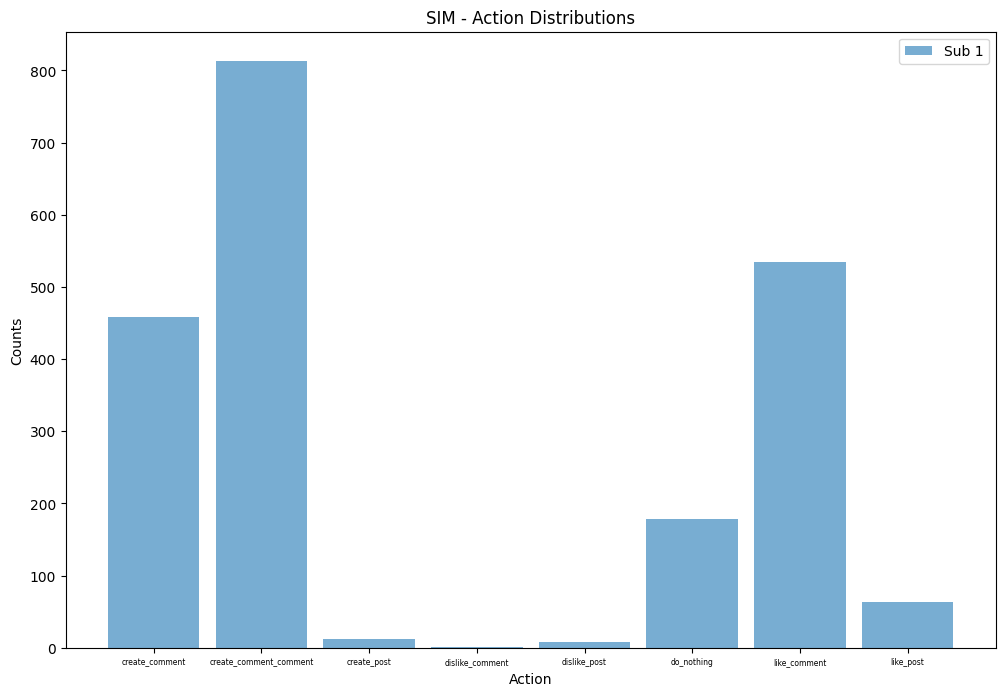

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
l = 1
bar_width = 0.85 / len(trace.values())  # Adjust the width of the bars based on the number of subsets

# Get all unique actions to ensure consistent x-axis
all_actions = set()
for i in list(trace.values()):
    try:
        temp = i[~i["action"].isin(["refresh", "sign_up"])].sort_values("action")
        all_actions.update(temp["action"].unique())
    except:
        pass
all_actions = sorted(all_actions)

x = np.arange(len(all_actions))  # Label locations

for i in list(trace.values()):
    try:
        temp = i[~i["action"].isin(["refresh", "sign_up"])].sort_values("action")
        cats = temp["action"].unique()
        counts = temp.groupby("action").size()

        # Create a dictionary to map actions to their counts
        counts_dict = dict(zip(cats, counts))

        # Ensure all actions are represented in the counts
        counts = [counts_dict.get(action, 0) for action in all_actions]

        # Calculate the position for this set of bars
        bar_positions = x + (l - 1) * bar_width

        ax.bar(bar_positions, counts, width=bar_width, alpha=0.6, label=f"Sub {l}")
        ax.tick_params(axis="x", labelsize=5.5)

        ax.set_xlabel("Action")
        ax.set_ylabel("Counts")
        ax.set_title("SIM - Action Distributions")
        ax.set_xticks(x + bar_width * (len(trace.values()) - 1) / 2)
        ax.set_xticklabels(all_actions)

        l += 1
    except Exception as e:
        print(f"Error processing subset {l}: {e}")
        l += 1

ax.legend()
plt.show()

***
# Structural Analysis

In [13]:
# Print avg. share of actives in SIM
temp = [[], []]
for i in list(structure_data.keys()):
    temp[0].append(structure_data[i]["scale"])
    temp[1].append(structure_data[i]["active"])

print("SIM: Average Scale:", np.mean(temp[0]))
print("SIM: Average % active Users per Topic:", np.mean(temp[1]))

print("SIM: % active Users", data[start_str].nunique()["user_id"] / 80)

SIM: Average Scale: 43.75
SIM: Average % active Users per Topic: 0.5468333333333334
SIM: % active Users 0.9125


In [14]:
# Load User data and discussions data
seed_data = pd.read_csv(
    "/../abyss/home/oasis/oswald-et-al_2025/pre_survey_anon.csv",
    index_col=0
)
sample_data = pd.read_csv(
    "/../abyss/home/oasis/oswald-et-al_2025/sample_anon.csv",
    index_col=0
)

seed_data.drop_duplicates("ParticipantID", inplace=True)
seed_data = seed_data.loc[seed_data["on_reddit"] == 1]
print("Oswald: N users:", len(seed_data))

discussions_data = pd.read_csv(
    "/../abyss/home/oasis/oswald-et-al_2025/discussions_anon.csv",
    index_col=0
)
discussions_data.dropna(subset="ParticipantID", inplace=True)
print("Oswald: N posts:", len(discussions_data))

# Group by participant and count number of submissions created during experiment
discussions_data["comment_count"] = discussions_data.groupby(
    "ParticipantID"
)["ParticipantID"].transform("count").map(int)

discussions_data_merge = discussions_data[[
    "ParticipantID", "comment_count"
]].drop_duplicates()

seed_data = seed_data.merge(discussions_data_merge,
                            how="left",on="ParticipantID")

seed_data.fillna({"comment_count" : 0}, inplace=True)
# Print total user # and share of active
print("Oswald: N users:", len(seed_data))
seed_active_users = len(
    seed_data[seed_data["comment_count"] != 0].drop_duplicates("ParticipantID")
) / len(seed_data)
print("Oswald: % active users:", seed_active_users)

Oswald: N users: 520
Oswald: N posts: 5792
Oswald: N users: 520
Oswald: % active users: 0.6365384615384615


In [15]:
# Replace NAs with 0 for further analysis (0 comments, 0 likes, etc.)
sample_data = sample_data[[
    "ParticipantID",
    "subreddit",
    "polinterest",
    "time_online",
    "social_media",
    "comments_online",
    "comment_count",
    "comment_mean_lenght",
    "comment_mean_score",
    "comment_mean_tox"
]]

sample_data.rename(columns={"comment_mean_lenght":"comment_mean_length"},
                  inplace=True)

sample_data.fillna(0, inplace=True)
print(len(sample_data))

sample_sub_1_data = sample_data[sample_data["subreddit"] == "DiscussPolitics1"]

520


In [17]:
# Comparison of 

def round_mean(data, mode="mean", digits=3):
    if mode == "mean":
        return round(np.mean(data), digits)
    elif mode == "median":
        return round(np.median(data), digits)


sim_sample_data = sim_data.drop_duplicates(
    ["user_id", "subreddit"]
).sort_values("user_id").reset_index(drop="True")

sim_sample_data = sim_sample_data[[
    "user_id",
    "subreddit",
    "seed_user_id",
    "n_agents",
    "sim_comment_count"
]]


seed_avg_comment_count = round_mean(sample_data["comment_count"])
seed_median_comment_count = round_mean(
    sample_data["comment_count"], mode="median"
)
seed_avg_score_comment = round_mean(discussions_data["score_comment"])
seed_median_score_comment = round_mean(
    discussions_data["score_comment"], mode="median"
)
seed_min_score_comment = min(discussions_data["score_comment"])
seed_max_score_comment = max(discussions_data["score_comment"])


sim_avg_comment_count = round_mean(sim_sample_data["sim_comment_count"])
sim_median_comment_count = round_mean(
    sim_sample_data["sim_comment_count"], mode="median"
)
sim_avg_score_comment = round_mean(sim_data["sim_score_comment"])
sim_median_score_comment = round_mean(
    sim_data["sim_score_comment"], mode="median"
)
sim_min_score_comment = min(sim_data["sim_score_comment"])
sim_max_score_comment = max(sim_data["sim_score_comment"])


print("{:<30}{:^10}|{:^10}".format("All Users/Agents", "Seed", "Sim Active"))
print("-"*50)
print("{:<30}{:^10}|{:^10}".format("N Agents", len(sample_data), len(sim_sample_data)))
print("{:<30}{:^10}|{:^10}".format("N Comments", len(discussions_data), len(sim_data)))
print("-"*50)
print("{:<30}{:^10}|{:^10}".format("Average Comment Count:", seed_avg_comment_count, sim_avg_comment_count))
print("{:<30}{:^10}|{:^10}".format("Median Comment Count:", seed_median_comment_count, sim_median_comment_count))
print("{:<30}{:^10}|{:^10}".format("Average Comment Score:", seed_avg_score_comment, sim_avg_score_comment))
print("{:<30}{:^10}|{:^10}".format("Median Comment Score:", seed_median_score_comment, sim_median_score_comment))
print("{:<30}{:^10}|{:^10}".format("Min Comment Score:", seed_min_score_comment, sim_min_score_comment))
print("{:<30}{:^10}|{:^10}".format("Max Comment Score:", seed_max_score_comment, sim_max_score_comment))

All Users/Agents                 Seed   |Sim Active
--------------------------------------------------
N Agents                         520    |    73    
N Comments                       5792   |   1272   
--------------------------------------------------
Average Comment Count:          11.046  |  17.425  
Median Comment Count:            3.0    |   17.0   
Average Comment Score:          2.428   |  0.419   
Median Comment Score:            2.0    |   0.0    
Min Comment Score:                -9    |    0     
Max Comment Score:                23    |    16    


(array([189.,  35.,  39.,  32.,  41.,  57.,  59.,  38.,  21.,   9.]),
 array([0.        , 0.47449321, 0.94898643, 1.42347964, 1.89797285,
        2.37246606, 2.84695928, 3.32145249, 3.7959457 , 4.27043892,
        4.74493213]),
 <BarContainer object of 10 artists>)

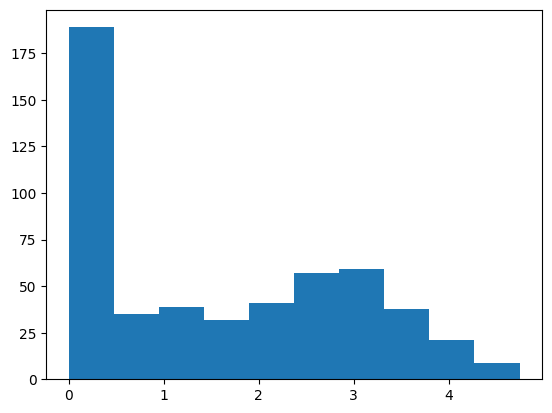

In [30]:
plt.hist(np.log(sample_data["comment_count"]+1))
# plt.xscale("log")

(array([31.,  7.,  6.,  3.,  3.,  8.,  8.,  5.,  4.,  5.]),
 array([0.        , 0.44773368, 0.89546736, 1.34320104, 1.79093473,
        2.23866841, 2.68640209, 3.13413577, 3.58186945, 4.02960313,
        4.47733681]),
 <BarContainer object of 10 artists>)

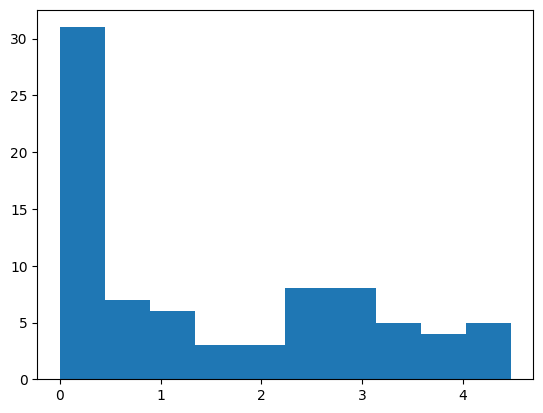

In [31]:
plt.hist(np.log(sample_data[sample_data["subreddit"] == "DiscussPolitics1"]["comment_count"]+1))

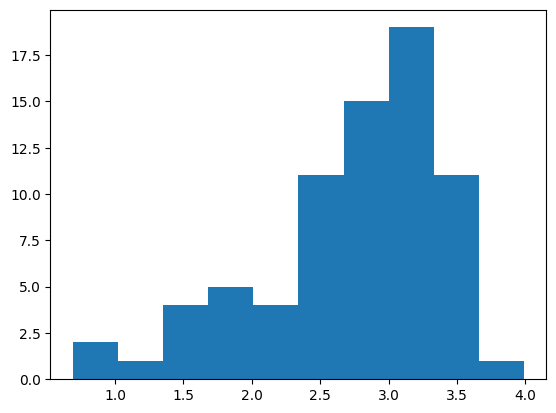

In [34]:
plt.hist(np.log(sim_sample_data["sim_comment_count"]+1))
plt.show()

(array([3490.,  989.,  527.,  334.,  215.,   80.,   40.,   12.,    6.,
           5.]),
 array([0.00208911, 0.09233164, 0.18257417, 0.2728167 , 0.36305924,
        0.45330177, 0.5435443 , 0.63378683, 0.72402937, 0.8142719 ,
        0.90451443]),
 <BarContainer object of 10 artists>)

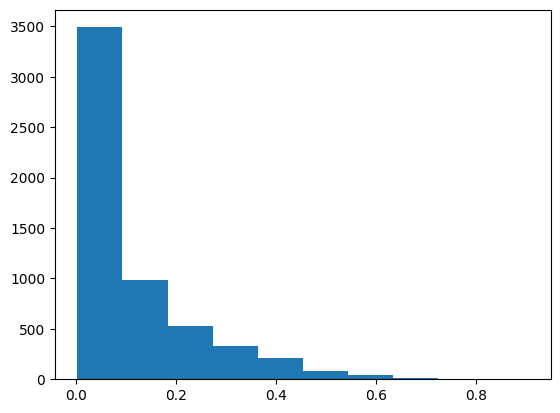

In [36]:
plt.hist(discussions_data["comment_toxicity"])

In [18]:
def process_plot_data(data, metric, cummulate=True):
    if cummulate:
        return [i for j in [i[metric] for i in data.values()] for i in j]
    else:
        return [i[metric] for i in data.values()]

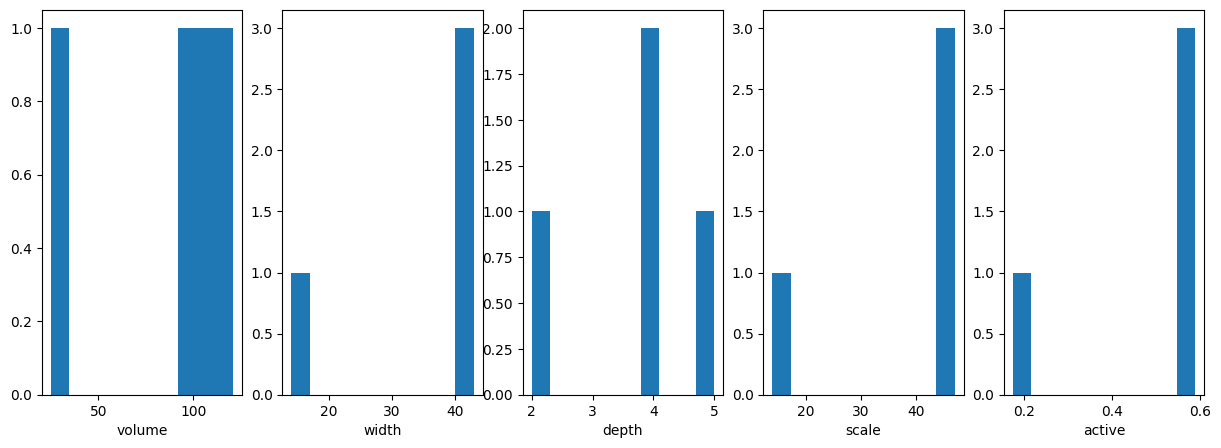

In [28]:
# Plot simulation descriptives
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].hist(process_plot_data(structure_data, "volume"))
axs[0].set_xlabel("volume")

axs[1].hist(process_plot_data(structure_data, "width"))
axs[1].set_xlabel("width")

axs[2].hist(process_plot_data(structure_data, "depth"))
axs[2].set_xlabel("depth")

axs[3].hist(process_plot_data(structure_data, "scale"))
axs[3].set_xlabel("scale")

axs[4].hist(process_plot_data(structure_data, "active"))
axs[4].set_xlabel("active")

if save_figs:
    plt.savefig("figures/sim_descriptives.jpg")
plt.show()

5792


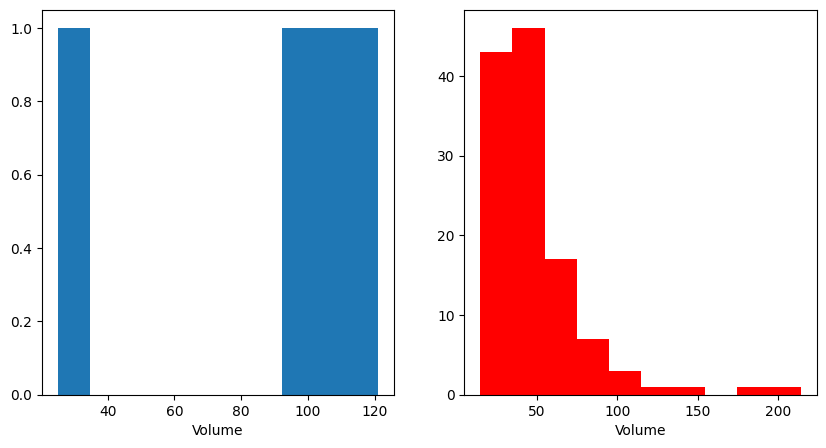

In [32]:
# Plot dist of volume across sim and seed threads
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(process_plot_data(structure_data, "volume"))
axs[0].set_xlabel("Volume")

temp = discussions_data.groupby(["subreddit", "post_title"]).count()["comment_id"]

print(discussions_data.groupby([
    "subreddit", "post_title"
]).count()["ParticipantID"].sum())

axs[1].hist(temp, color="r", label="Seed")
axs[1].set_xlabel("Volume")

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_vol.jpg")
plt.show()

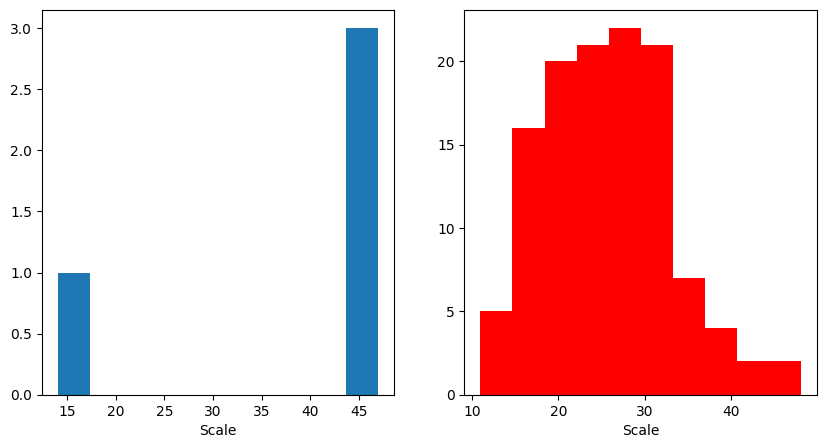

In [33]:
# Plot dist of scale across sim and seed threads
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(process_plot_data(structure_data, "scale"), label="SIM")
axs[0].set_xlabel("Scale")

temp = discussions_data.groupby([
    "subreddit", "post_title"
]).nunique("ParticipantID")

axs[1].hist(temp["ParticipantID"], color="r", label="Seed")
axs[1].set_xlabel("Scale")

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_dist_scale.jpg")
plt.show()

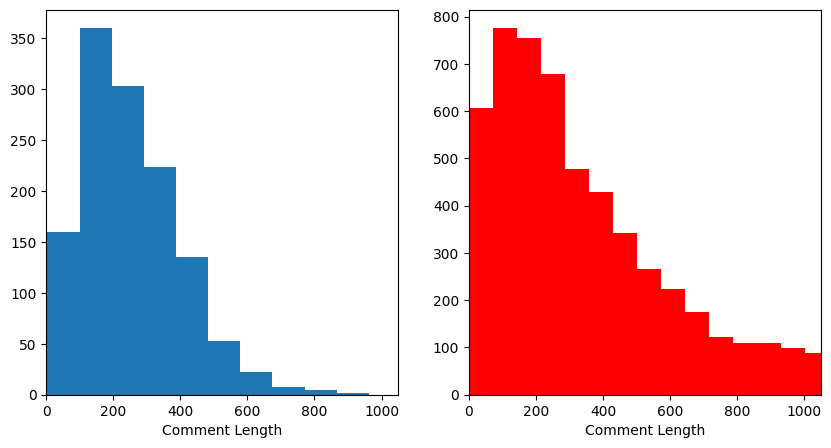

In [19]:
# Plot dist of comment lengths for all Sims
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist([i for j in process_plot_data(
    structure_data, "comment_lengths"
) for i in j],
            # bins=20,
            label="Sim")

axs[0].set_xlabel("Comment Length")
axs[0].set_xlim(0, 1050)

axs[1].hist(
    discussions_data["length_comment_char"], color="r", bins=100, label="Seed"
)
axs[1].set_xlabel("Comment Length")
axs[1].set_xlim(0, 1050)

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_dist_comment-lengths.jpg")
plt.show()

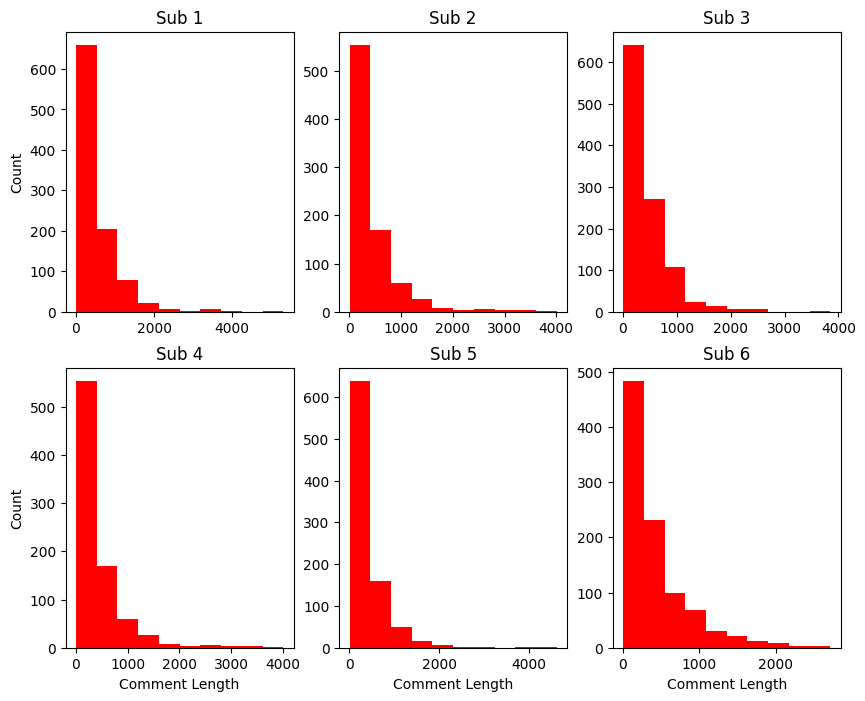

In [85]:
# Plot dist of comment lengths for all Sims
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
k = 1
for i in range(2):
    for j in range(3):
        temp = discussions_data.loc[discussions_data["subreddit"] == f"DiscussPolitics{(i+1)*(j+1)}"]
        axs[i][j].hist(
            temp["length_comment_char"], color="r", label="Seed"
        )
        axs[i][j].set_title(f"Sub {k}")
        if i > 0:
            axs[i][j].set_xlabel("Comment Length")
        # axs[i][j].set_xlim(0, 2000)
        if j == 0 or j == 3:
            axs[i][j].set_ylabel("Count")
        k += 1

# plt.legend()
if save_figs:
    plt.savefig("figures/seed_dist_sub-comment-lengths.jpg")
plt.show()

In [100]:
# Visualize the thread structure in tree form

def visualize_thread_tree(subreddit_data, data_type):

    # Create tree levels and record nodes present
    def populate_levels(node, level):
        levels[level] += 1
        for neighbor in bfs_tree.neighbors(node):
            if bfs_tree.nodes[neighbor].get("level", None) is None:
                bfs_tree.nodes[neighbor]["level"] = level + 1
                populate_levels(neighbor, level + 1)

    if data_type == "seed":
        seed_post_id_col = "post_id"
        parent_id_col = "parent_id"
        user_id_col = "ParticipantID"
        topic_post_content_col = "post_title"
    elif data_type == "sim":
        seed_post_id_col = "seed_post"
        parent_id_col = "parent_comment_id"
        user_id_col = "user_id"
        topic_post_content_col = "seed_post_content"
    else:
        raise ValueError("Select either 'seed' or 'sim'.")

    tree_metrics = {
        "degree_centrality": [],
        "degrees": [],
        "density": [],
        "depth": [],
        "width": [],
        "size": [],
        "avg_degree": None,
        "median_degree": None,
        "node_connectivity": [],
    }               
    
    for i in list(subreddit_data[seed_post_id_col].drop_duplicates())[:]:
        thread_tree = []
        node_labels = {}
        
        temp = subreddit_data[subreddit_data[seed_post_id_col] == i]
        
        for j, r in temp.iterrows():
            if data_type == "sim":
                if r[parent_id_col] == -1:
                    thread_tree.append((0, r["comment_id"]))
                else:
                    thread_tree.append((r[parent_id_col], r["comment_id"]))
            else:
                if r[parent_id_col] == r[seed_post_id_col]:
                    thread_tree.append((0, r["comment_id"]))
                else:
                    thread_tree.append((r[parent_id_col], r["comment_id"]))
            node_labels[r["comment_id"]] = r[user_id_col]
        
        G = nx.Graph()
        G.add_edges_from(thread_tree)
        pos = graphviz_layout(G, prog="dot")
        
        fig, axs = plt.subplots(1, 1, figsize=(40, 10))
        nx.draw(
            G, pos, with_labels=True, labels=node_labels, node_size=300,
            node_color='lightblue', font_weight='bold', font_size=8
        )

        plt.suptitle(f"{data_type.upper()} - Tree Structure Topic {i}")
        plt.title(f"{list(temp[topic_post_content_col])[0]}")
        if save_figs:
            plt.savefig(
                f"figures/{data_type}_trees/{data_type}_topic-{i}_thread-tree.jpg"
            )
        plt.show()

        levels = defaultdict(int)
        bfs_tree = nx.bfs_tree(G, source=0)
        populate_levels(0, 0)

        tree_metrics["degree_centrality"].append(nx.degree_centrality(G))
        tree_metrics["degrees"].append(list(dict(nx.degree(G)).values()))
        tree_metrics["density"].append(nx.density(G))
        tree_metrics["depth"].append(max(levels.keys()))
        tree_metrics["width"].append(max(levels.values()))
        tree_metrics["size"].append(nx.number_of_nodes(G))
        tree_metrics["node_connectivity"].append(nx.node_connectivity(G))

    tree_metrics["avg_degree"] = round_mean(
        [i for j in tree_metrics["degrees"] for i in j]
    )
    tree_metrics["median_degree"] = round_mean(
        [i for j in tree_metrics["degrees"] for i in j], mode="median"
    )

    return tree_metrics

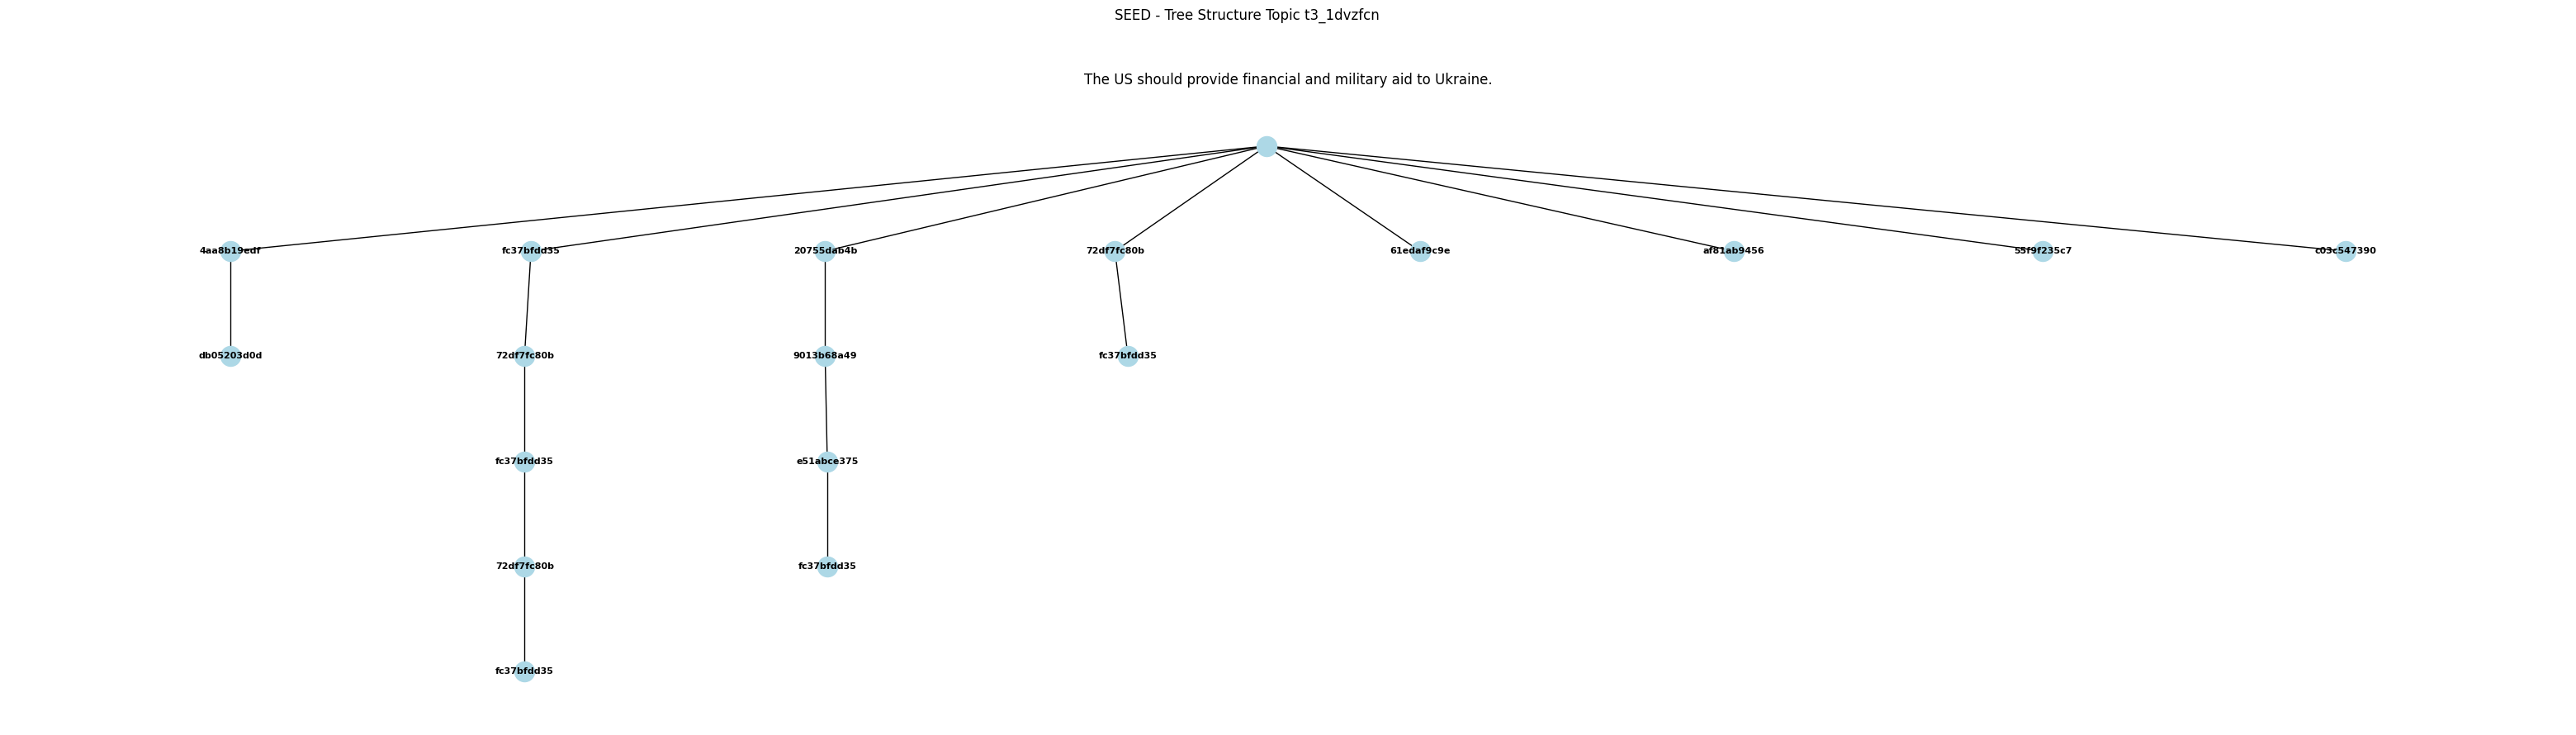

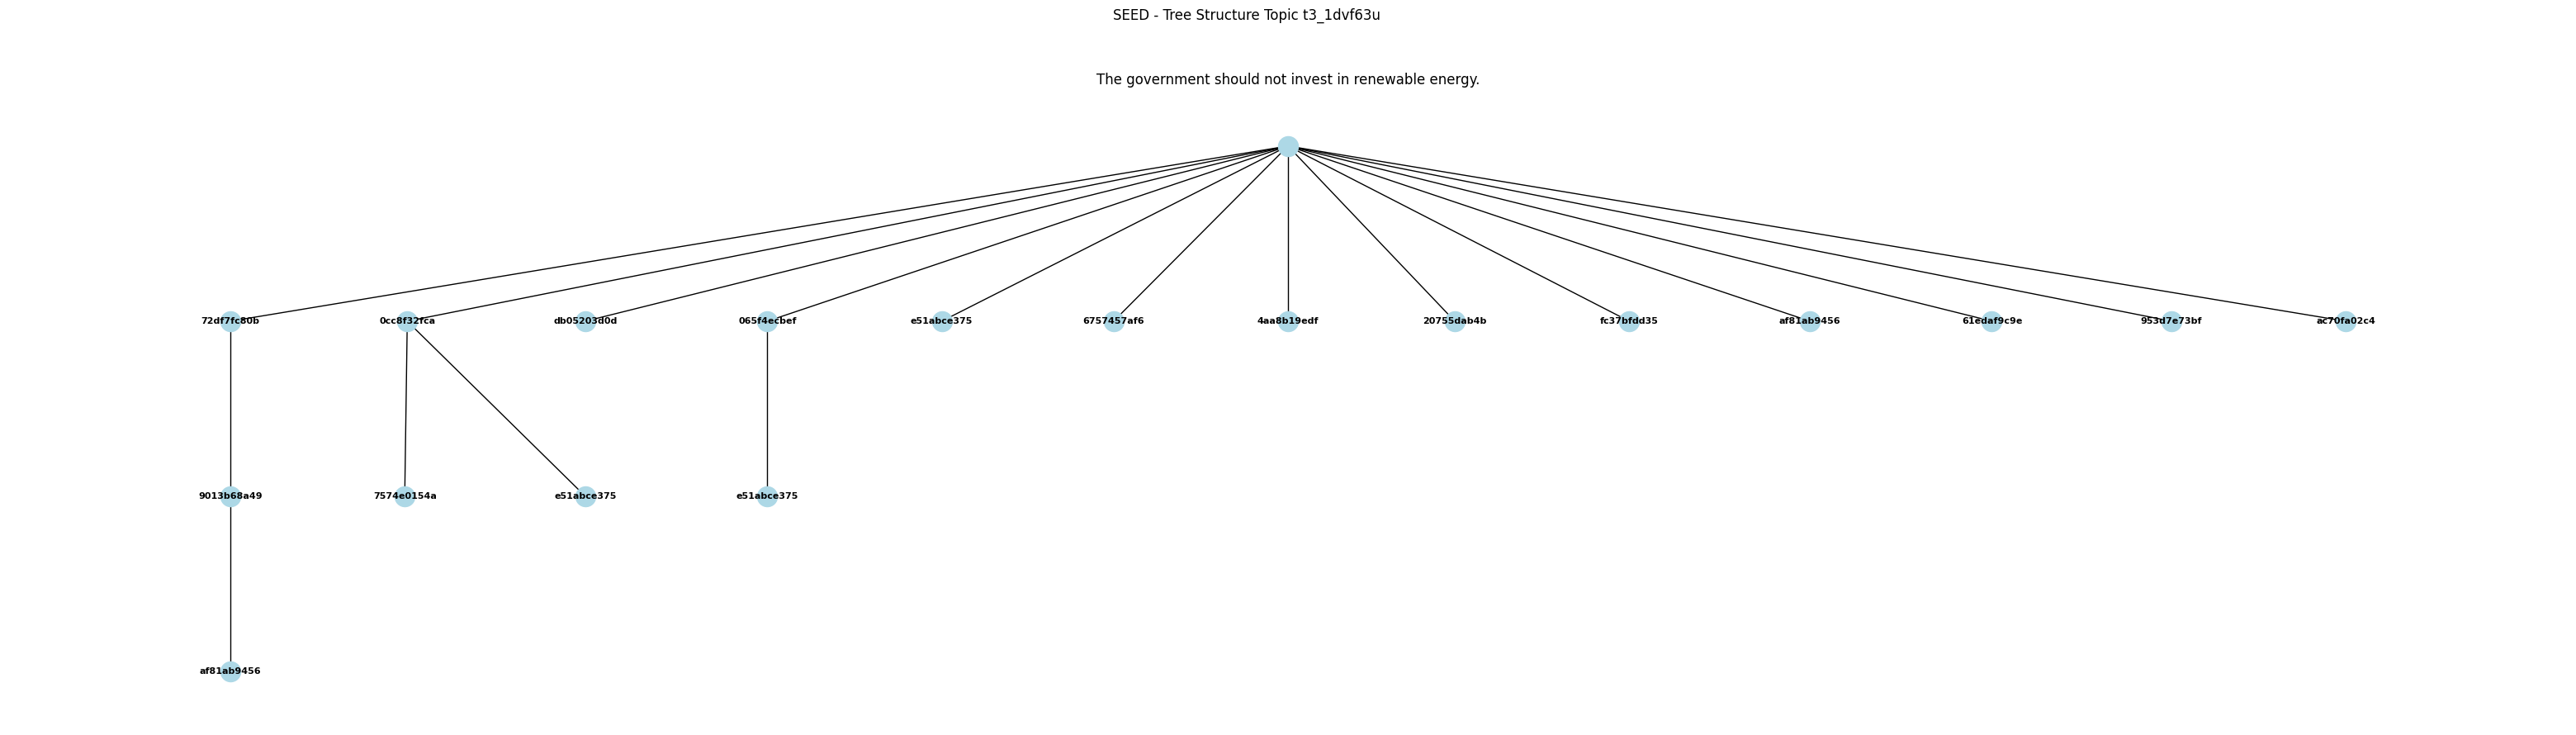

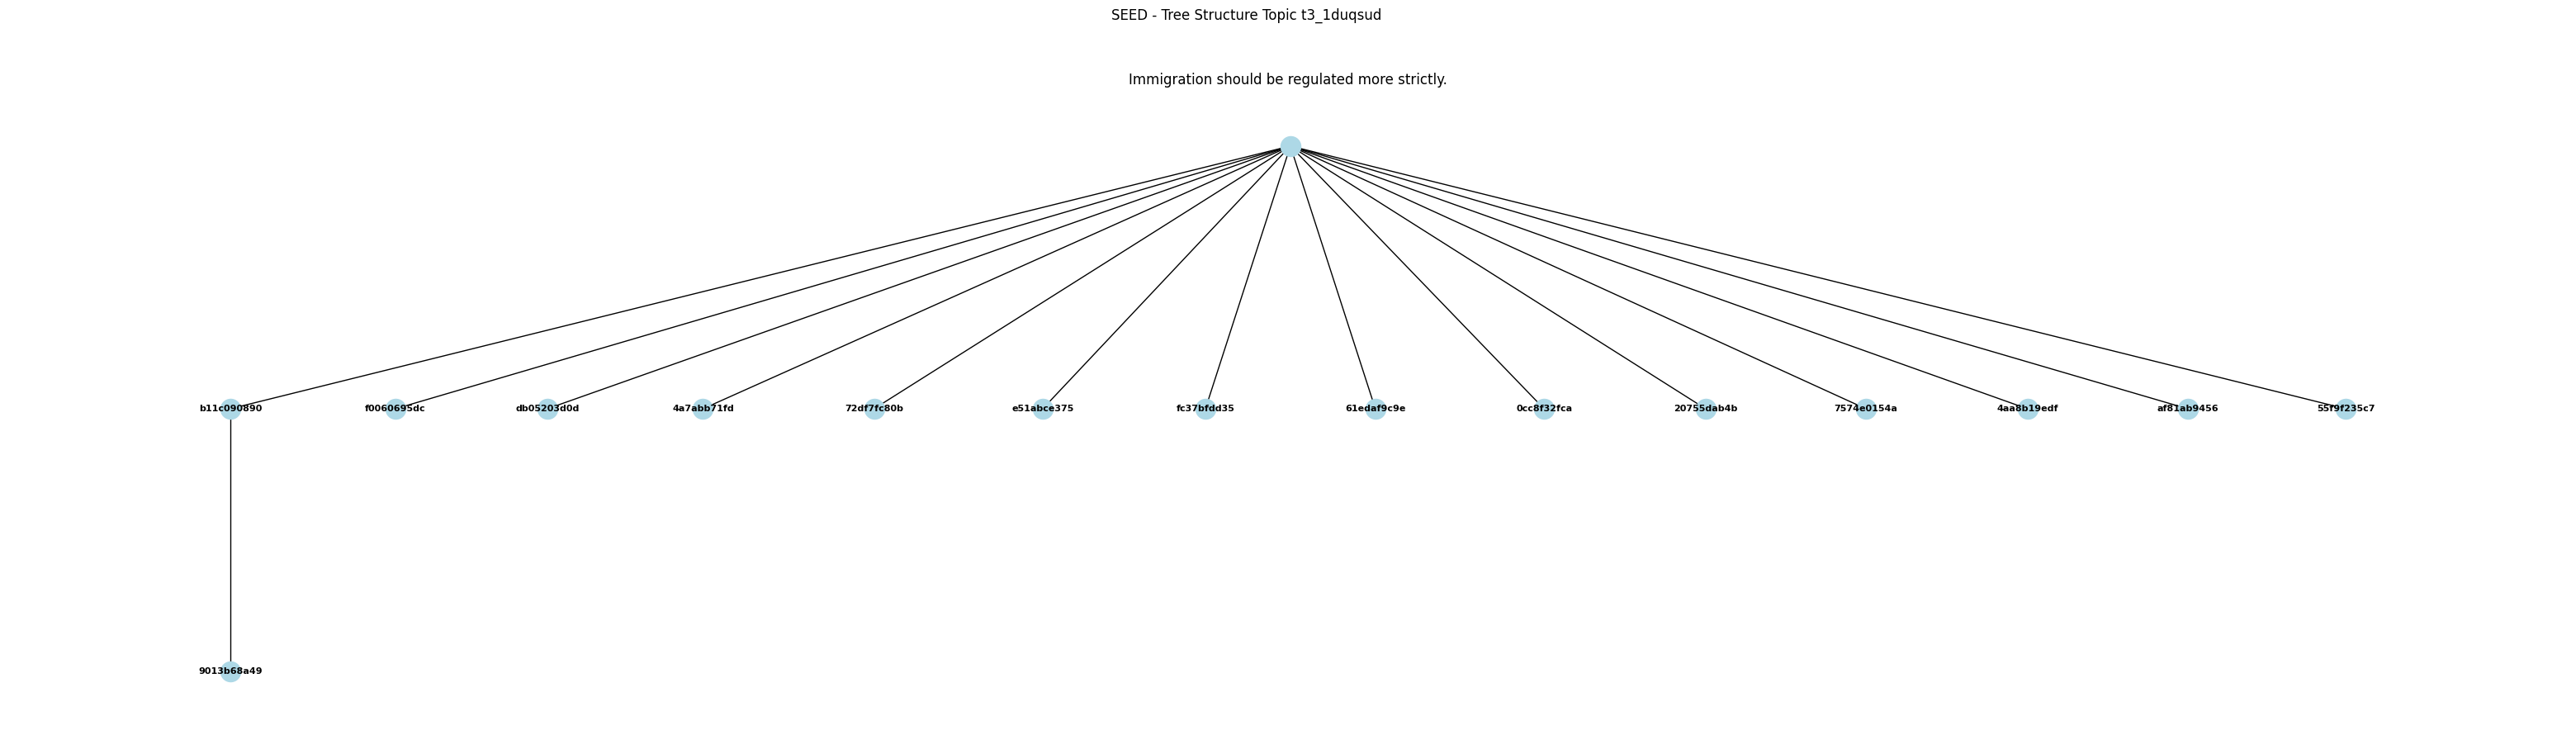

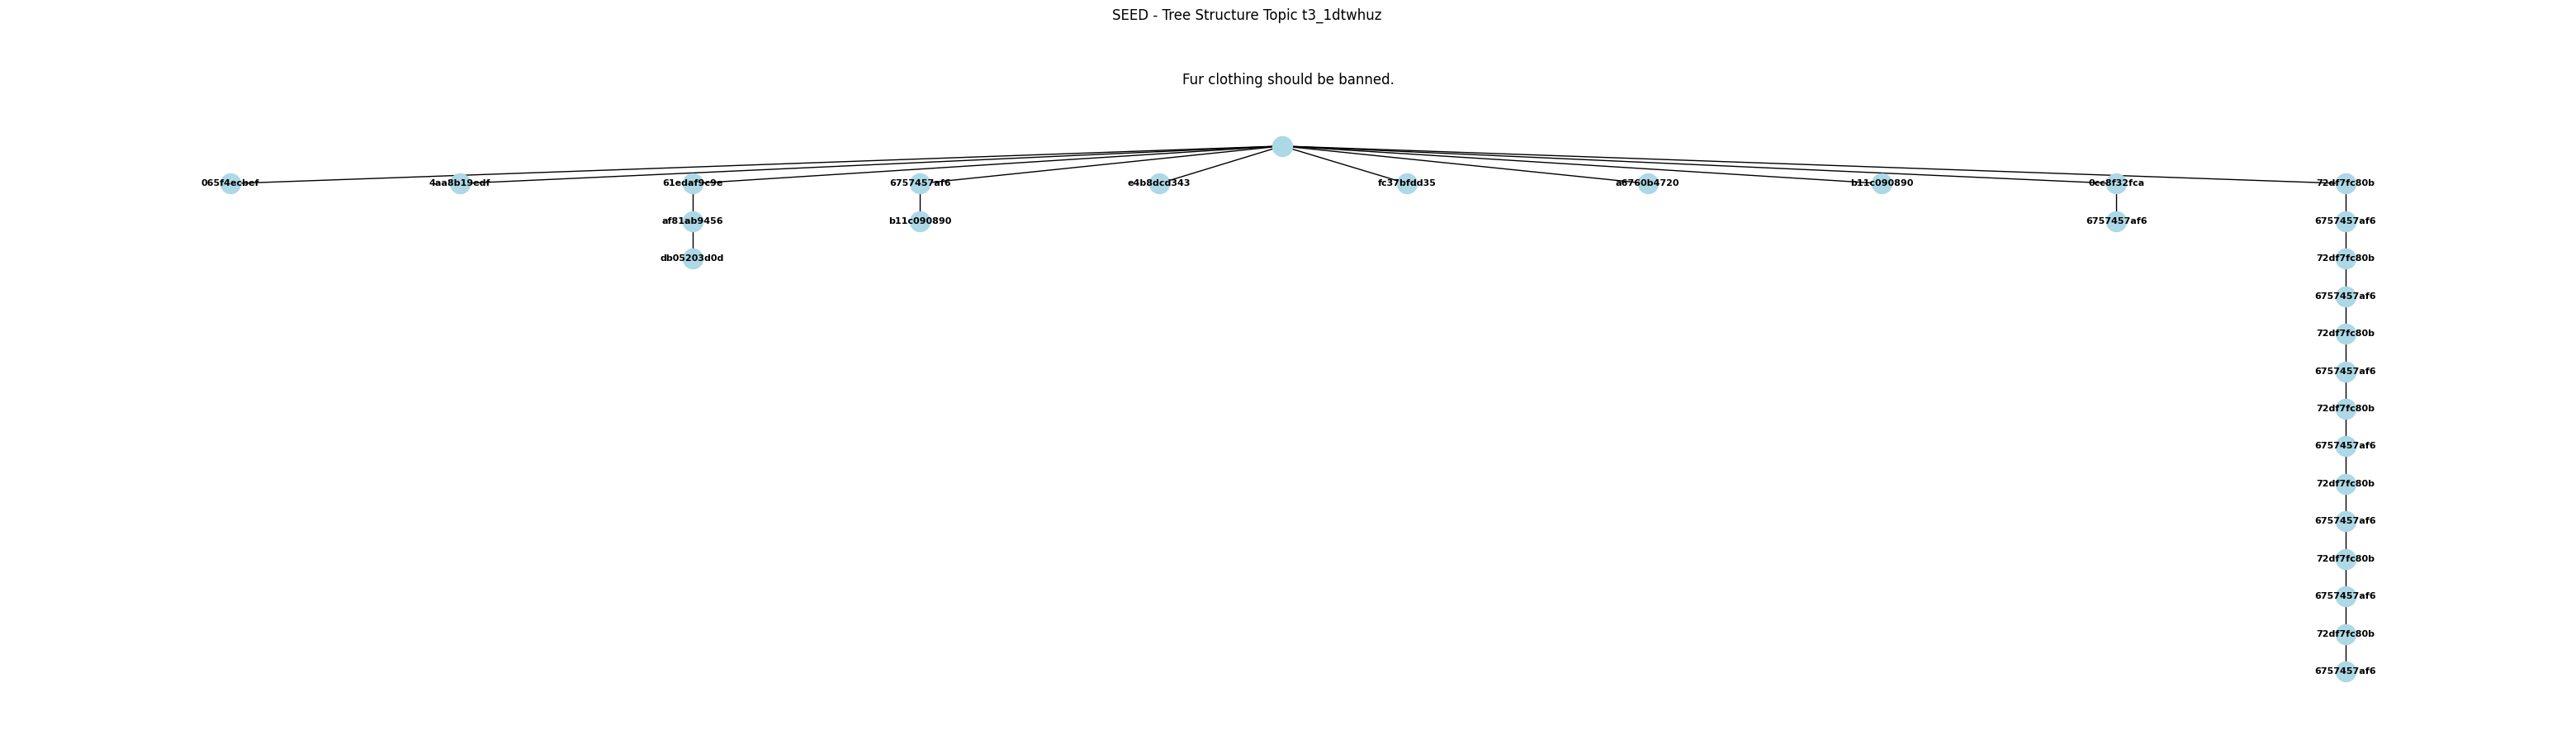

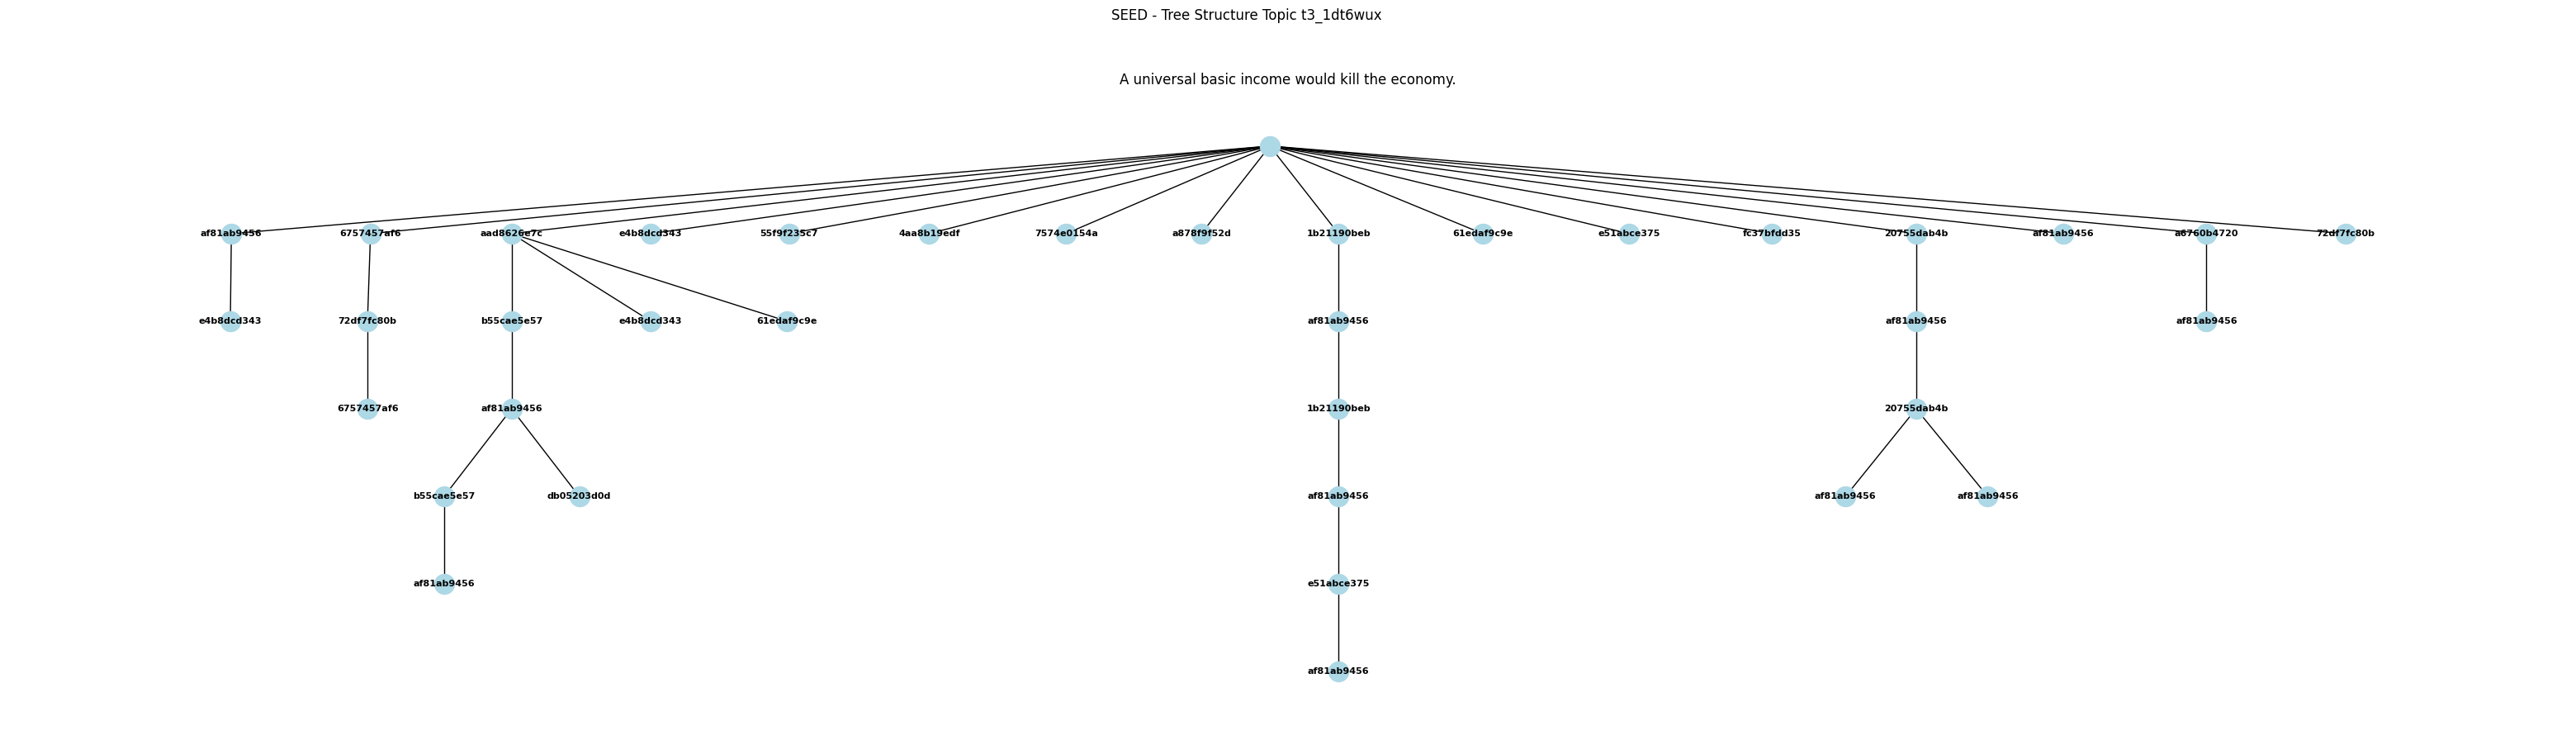

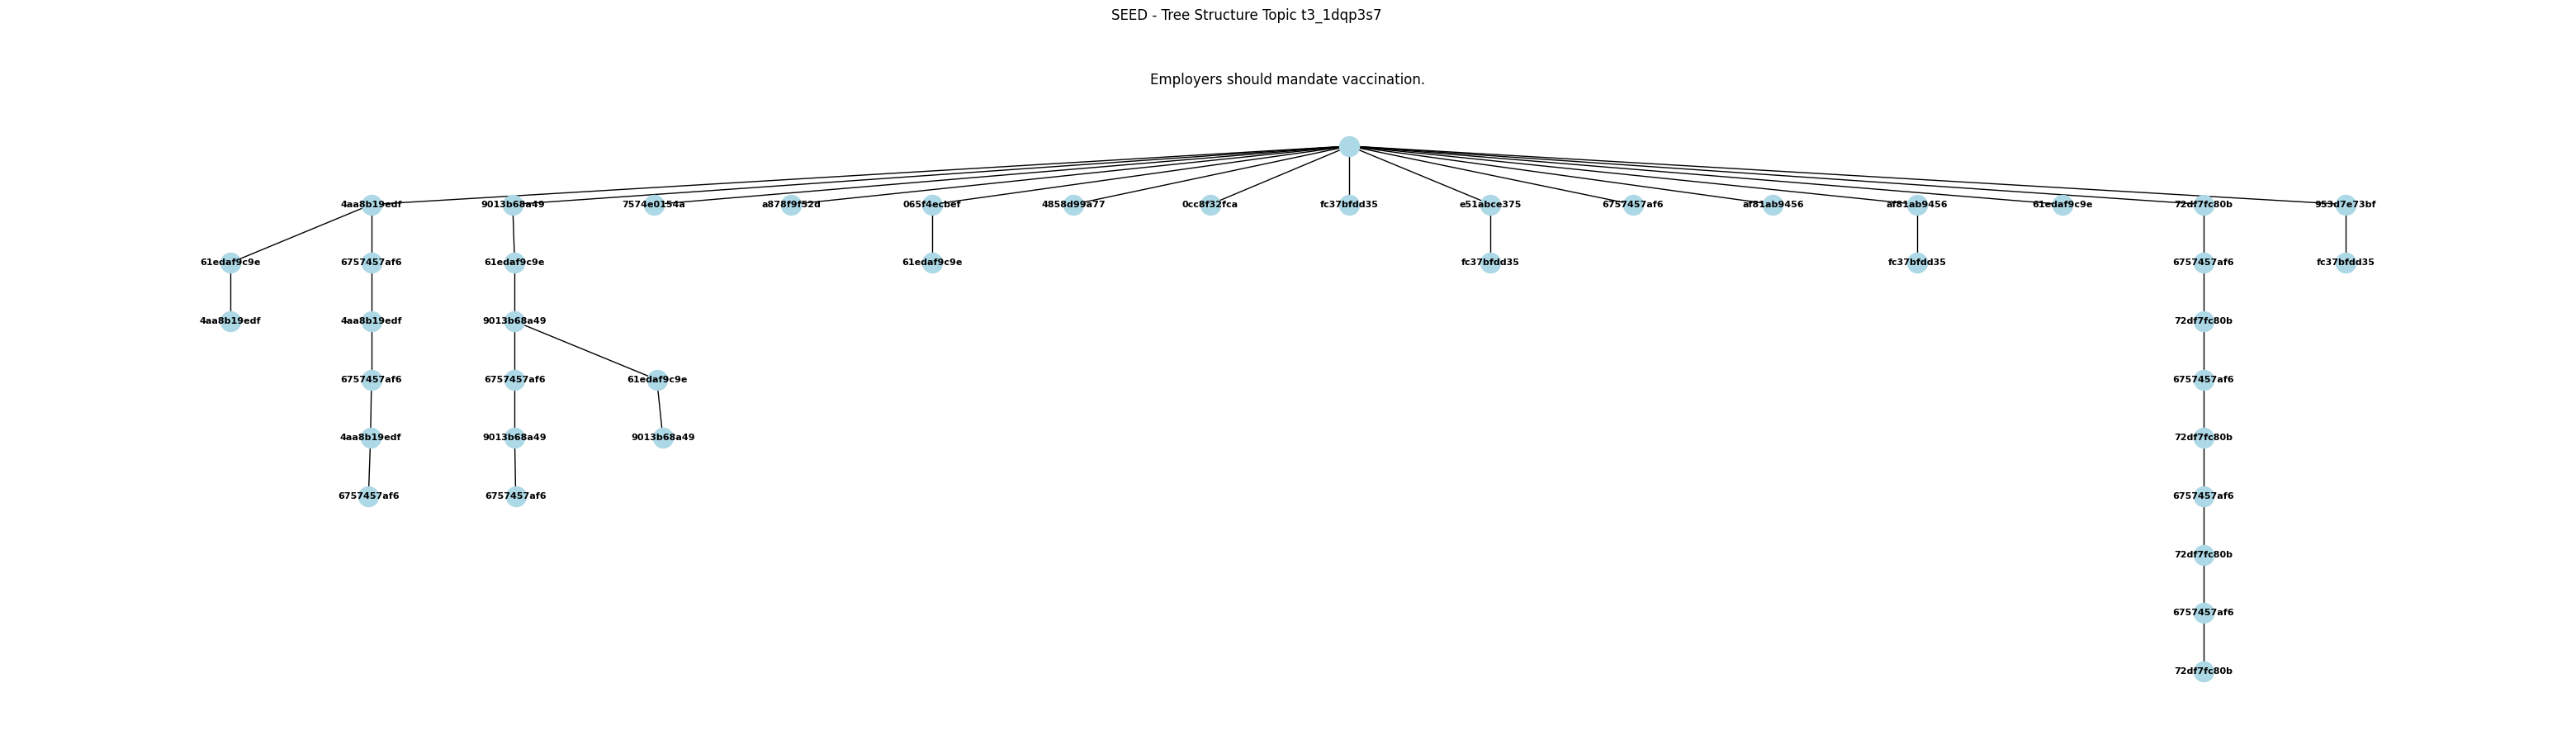

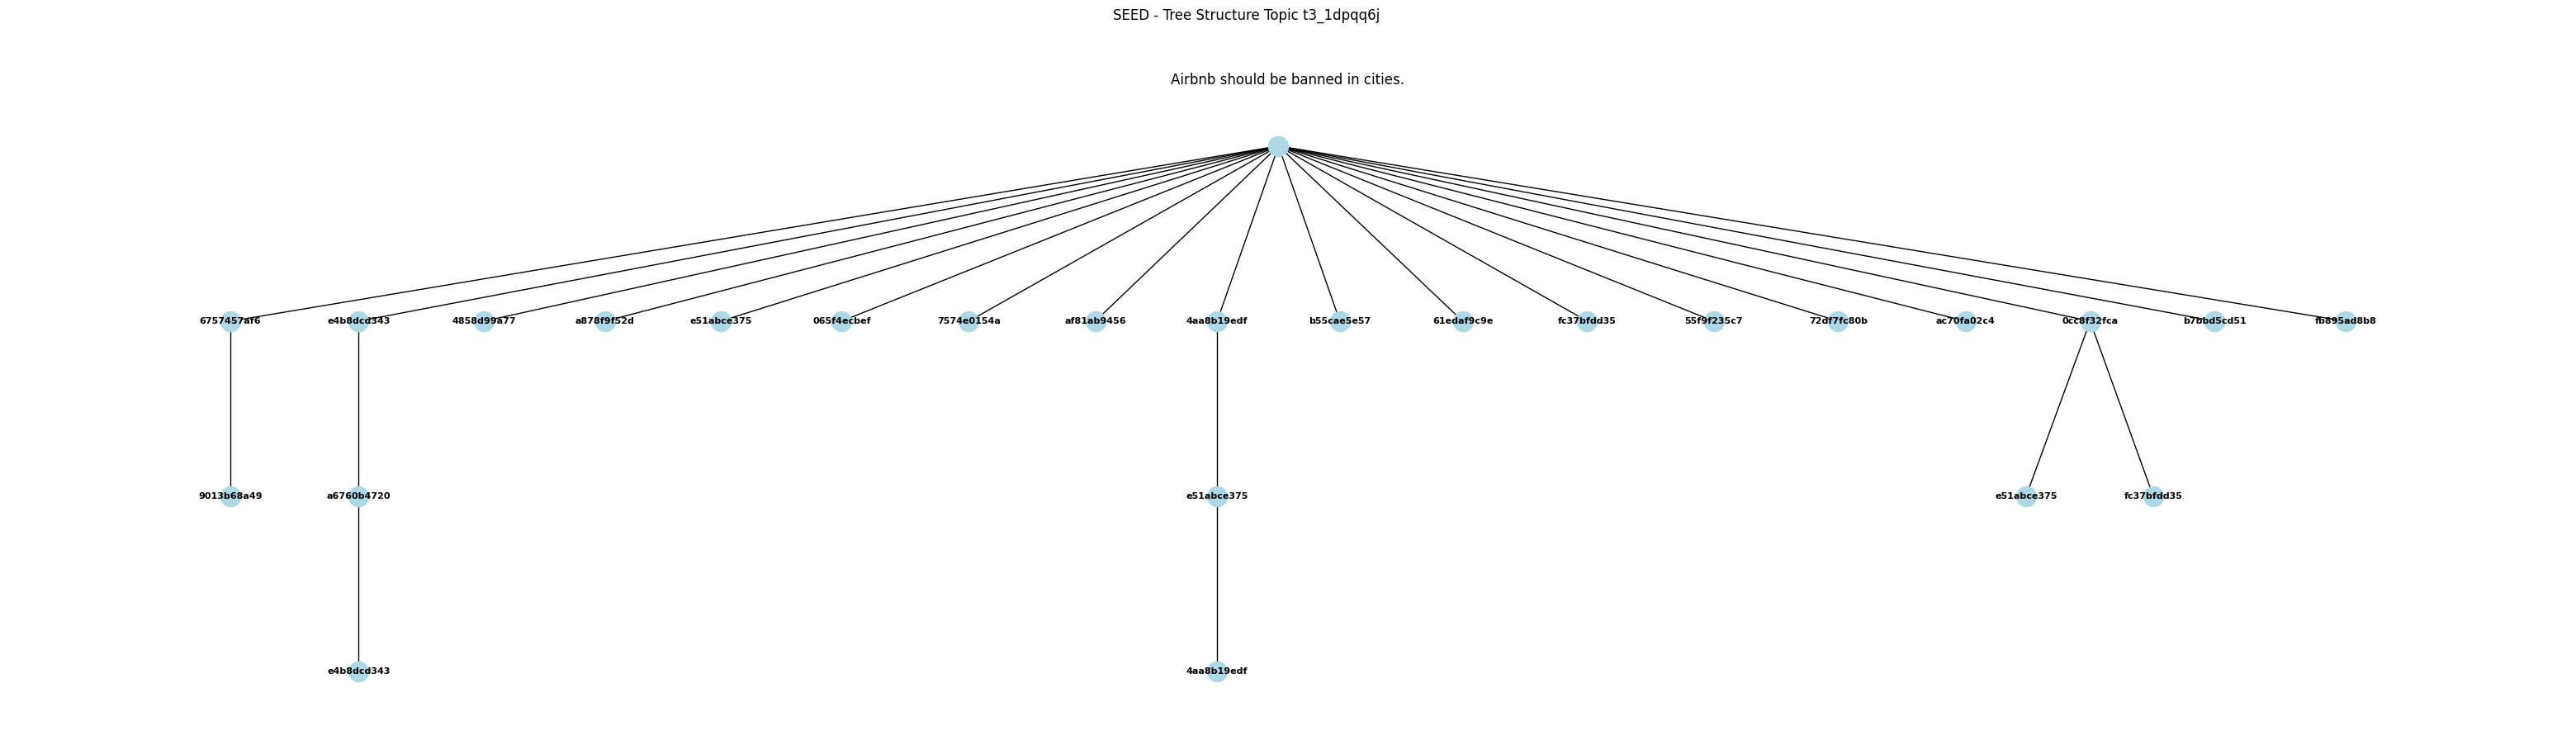

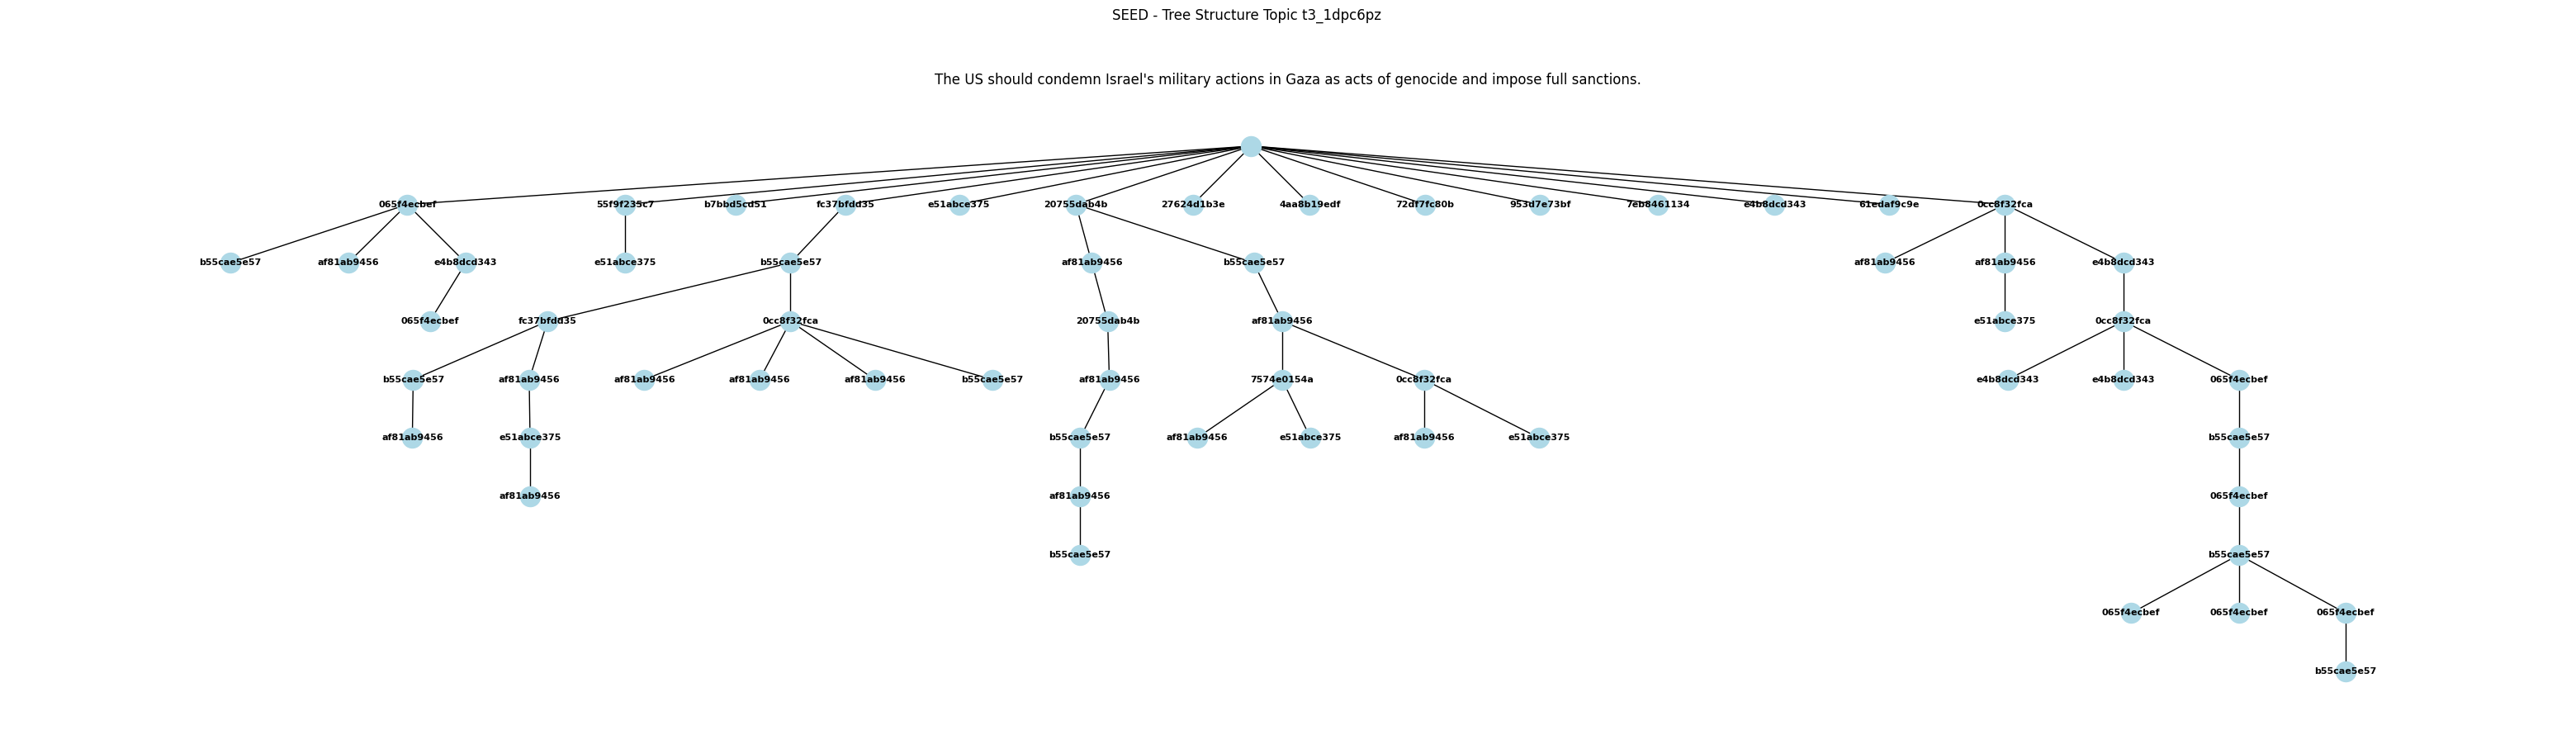

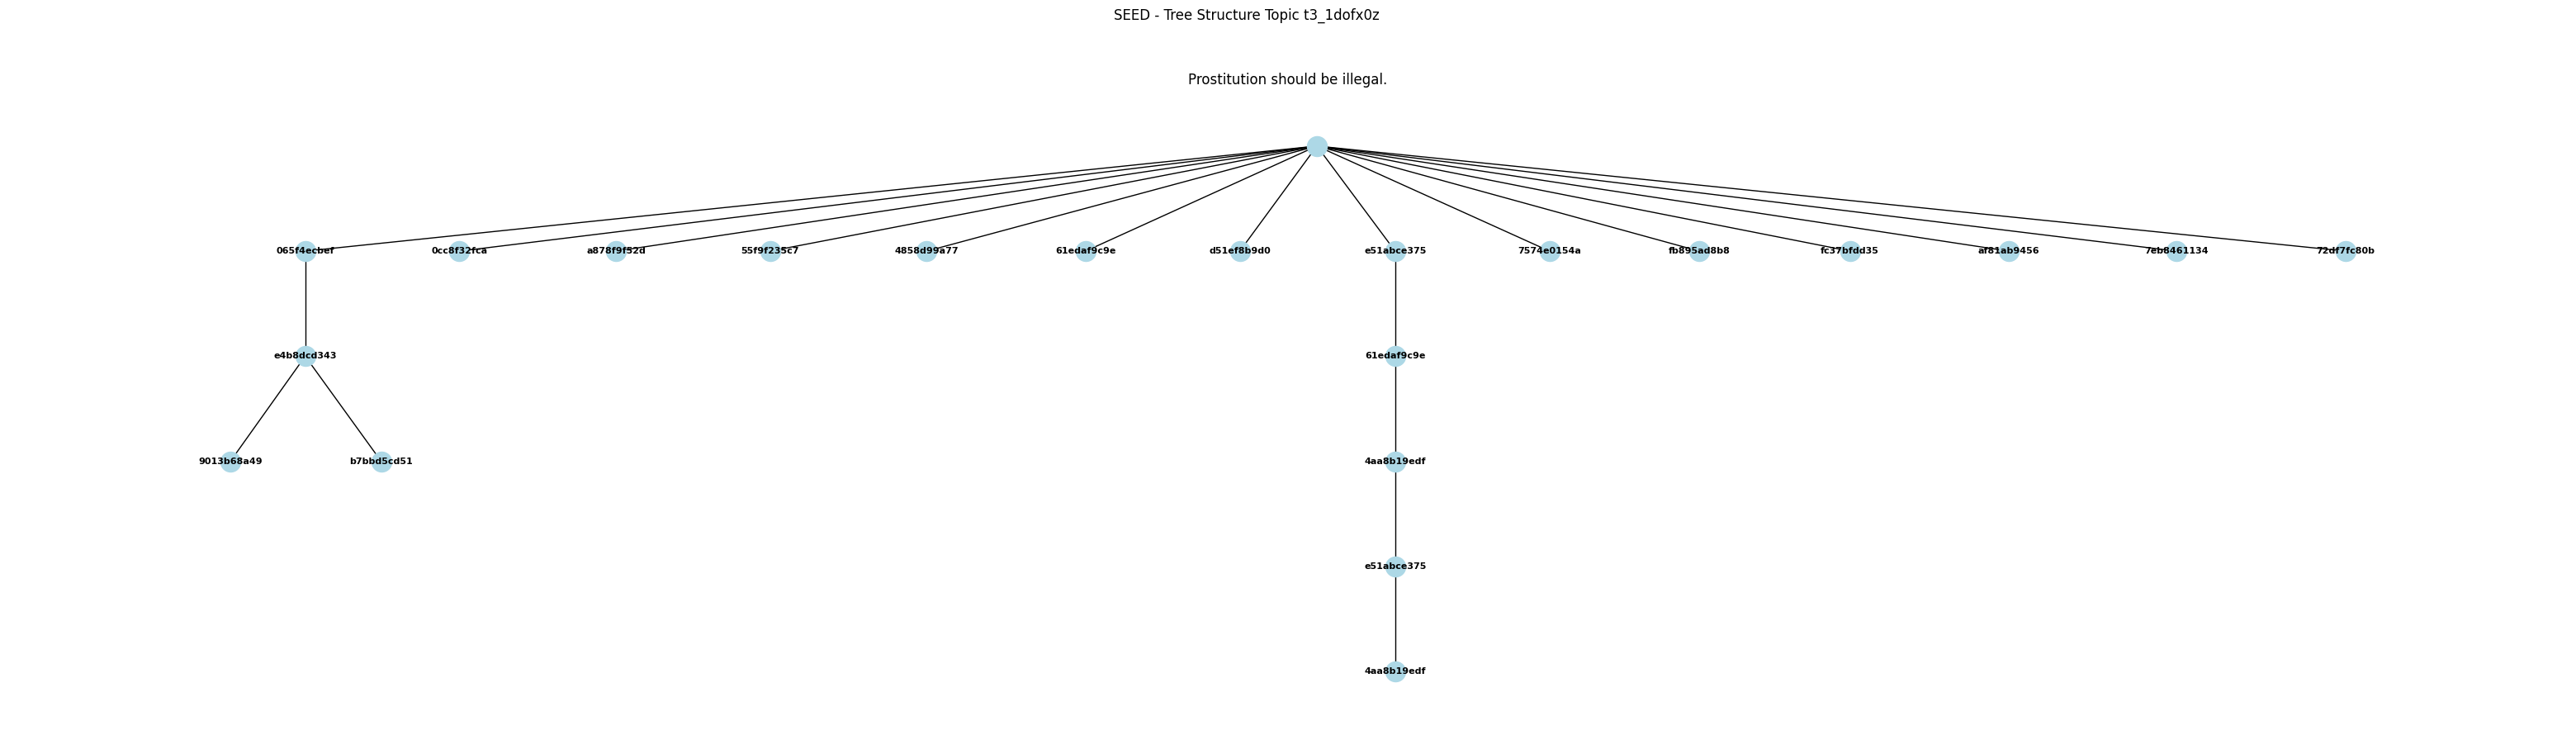

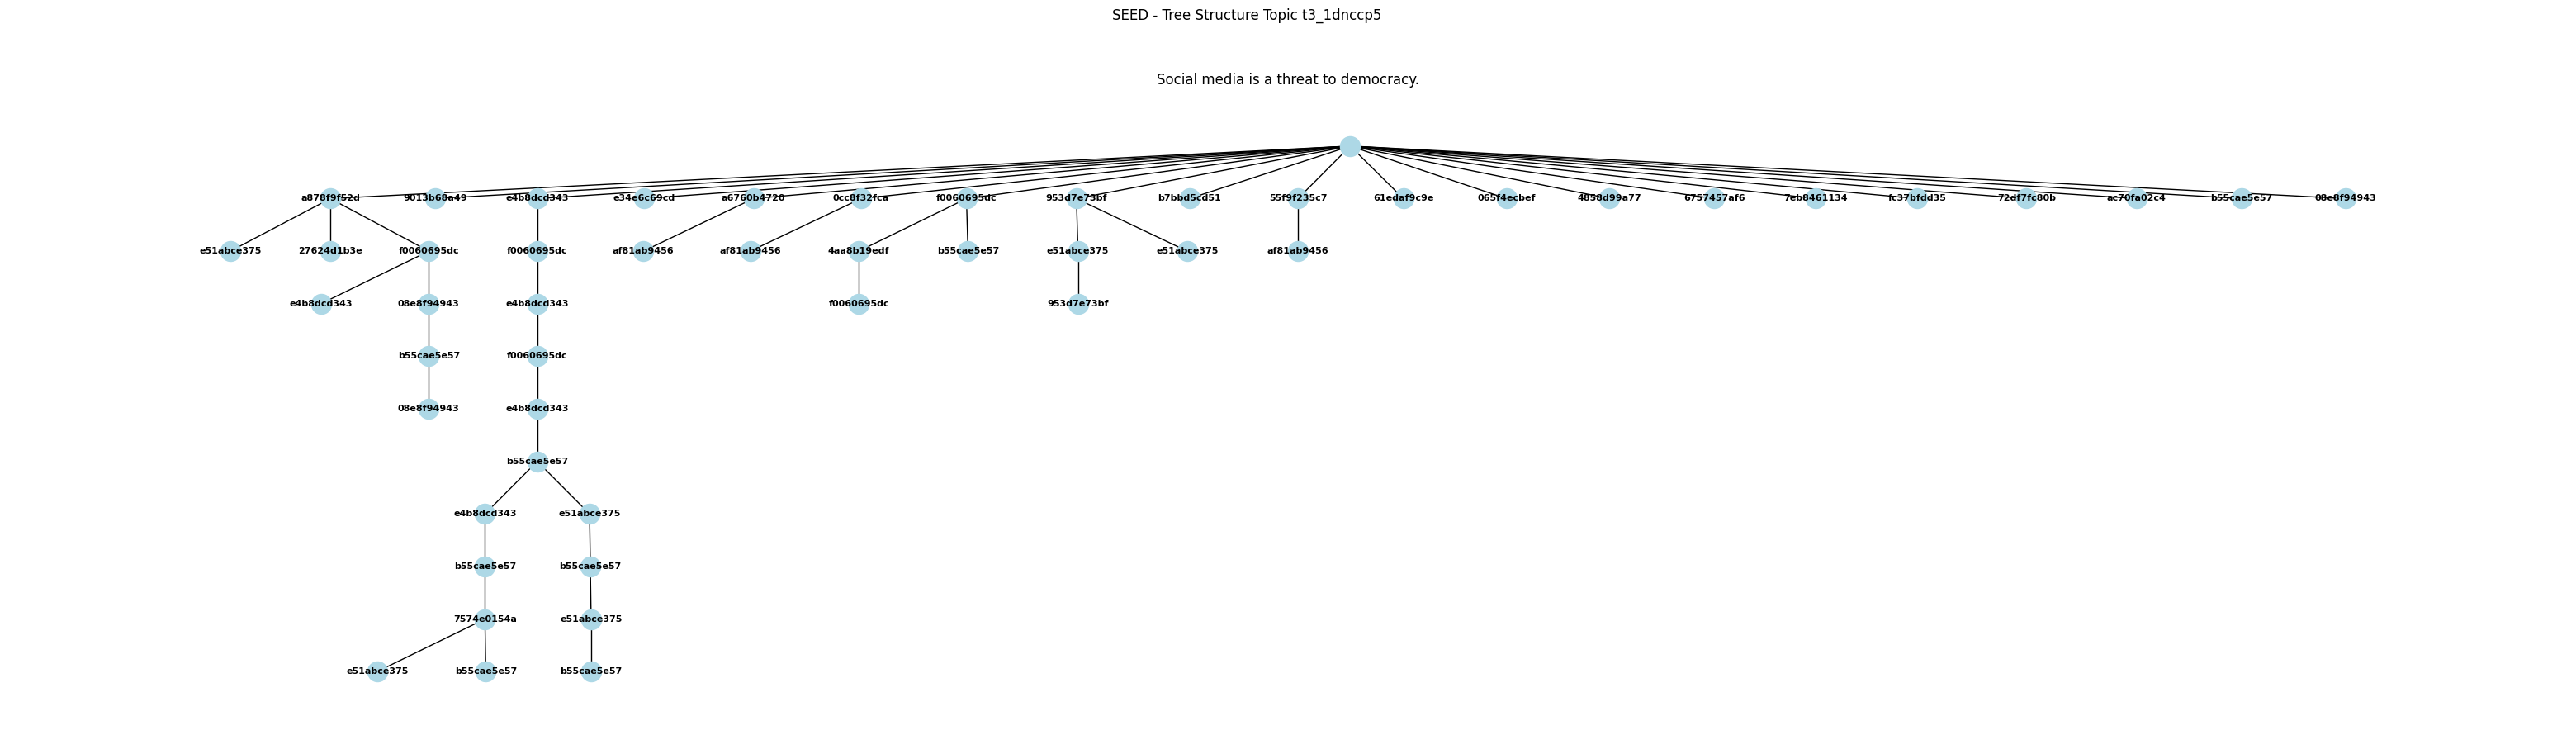

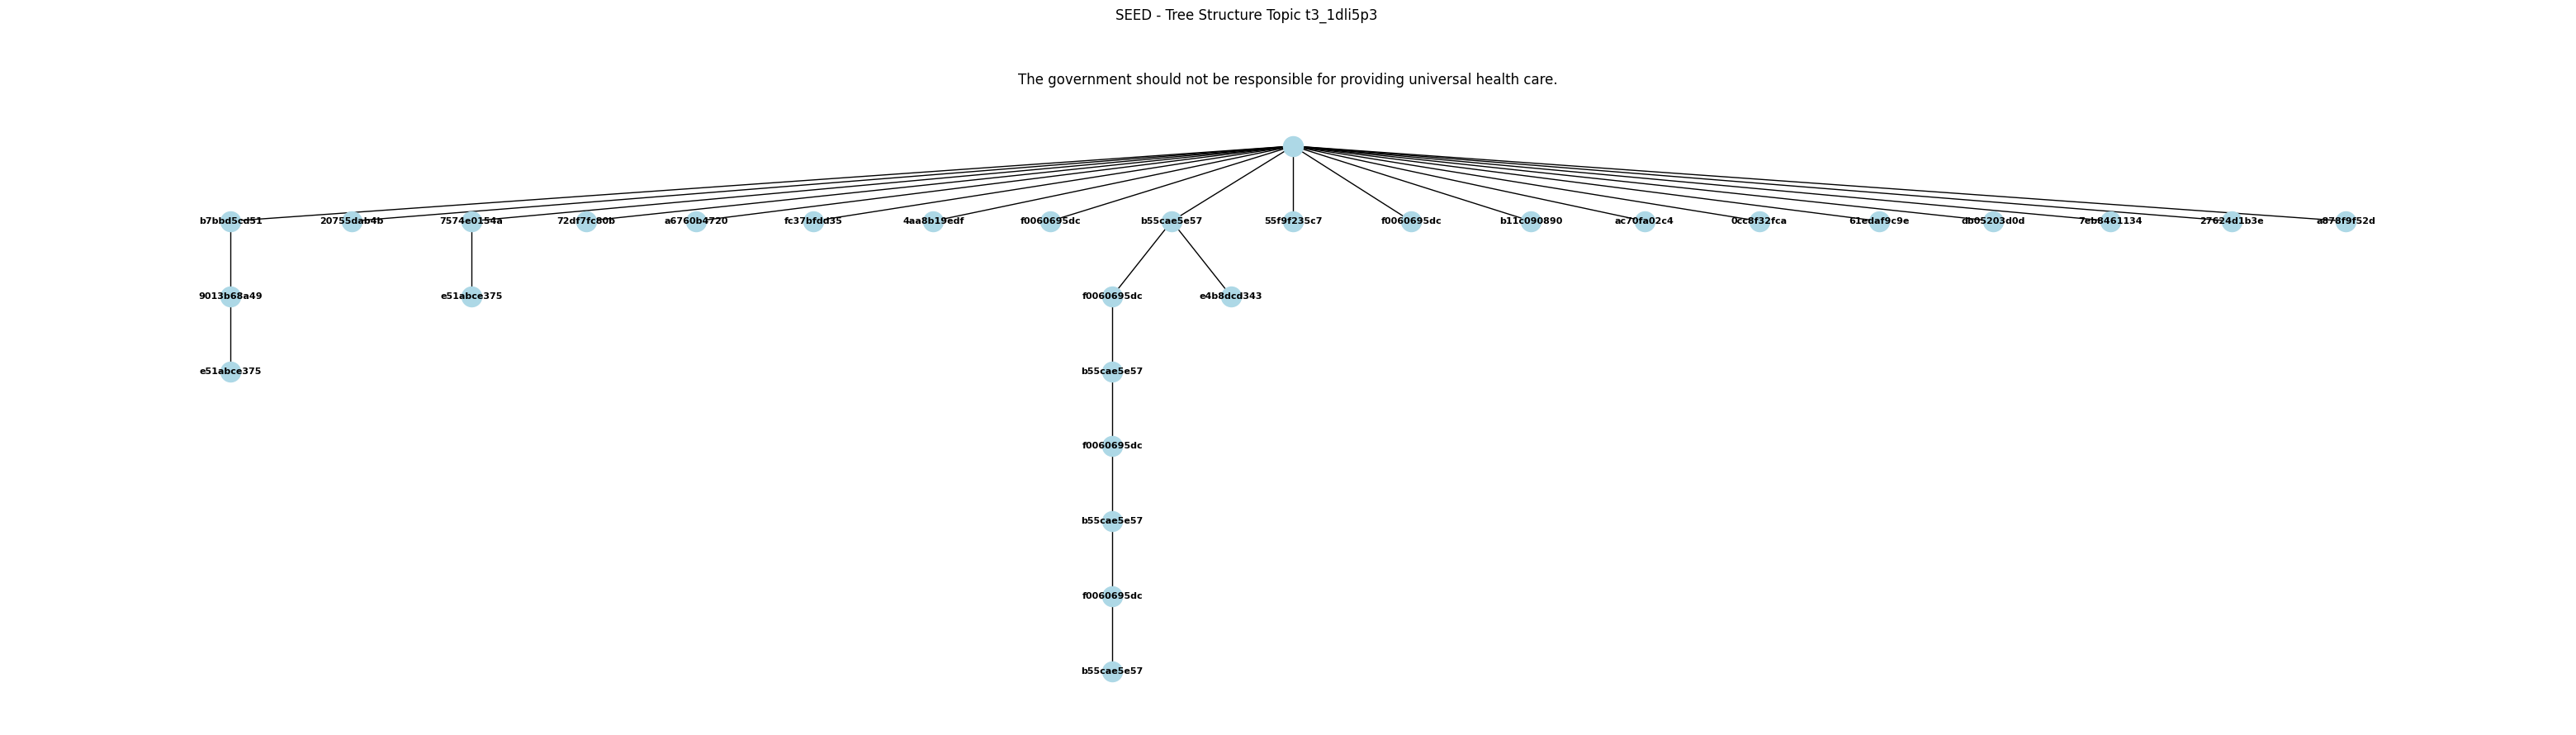

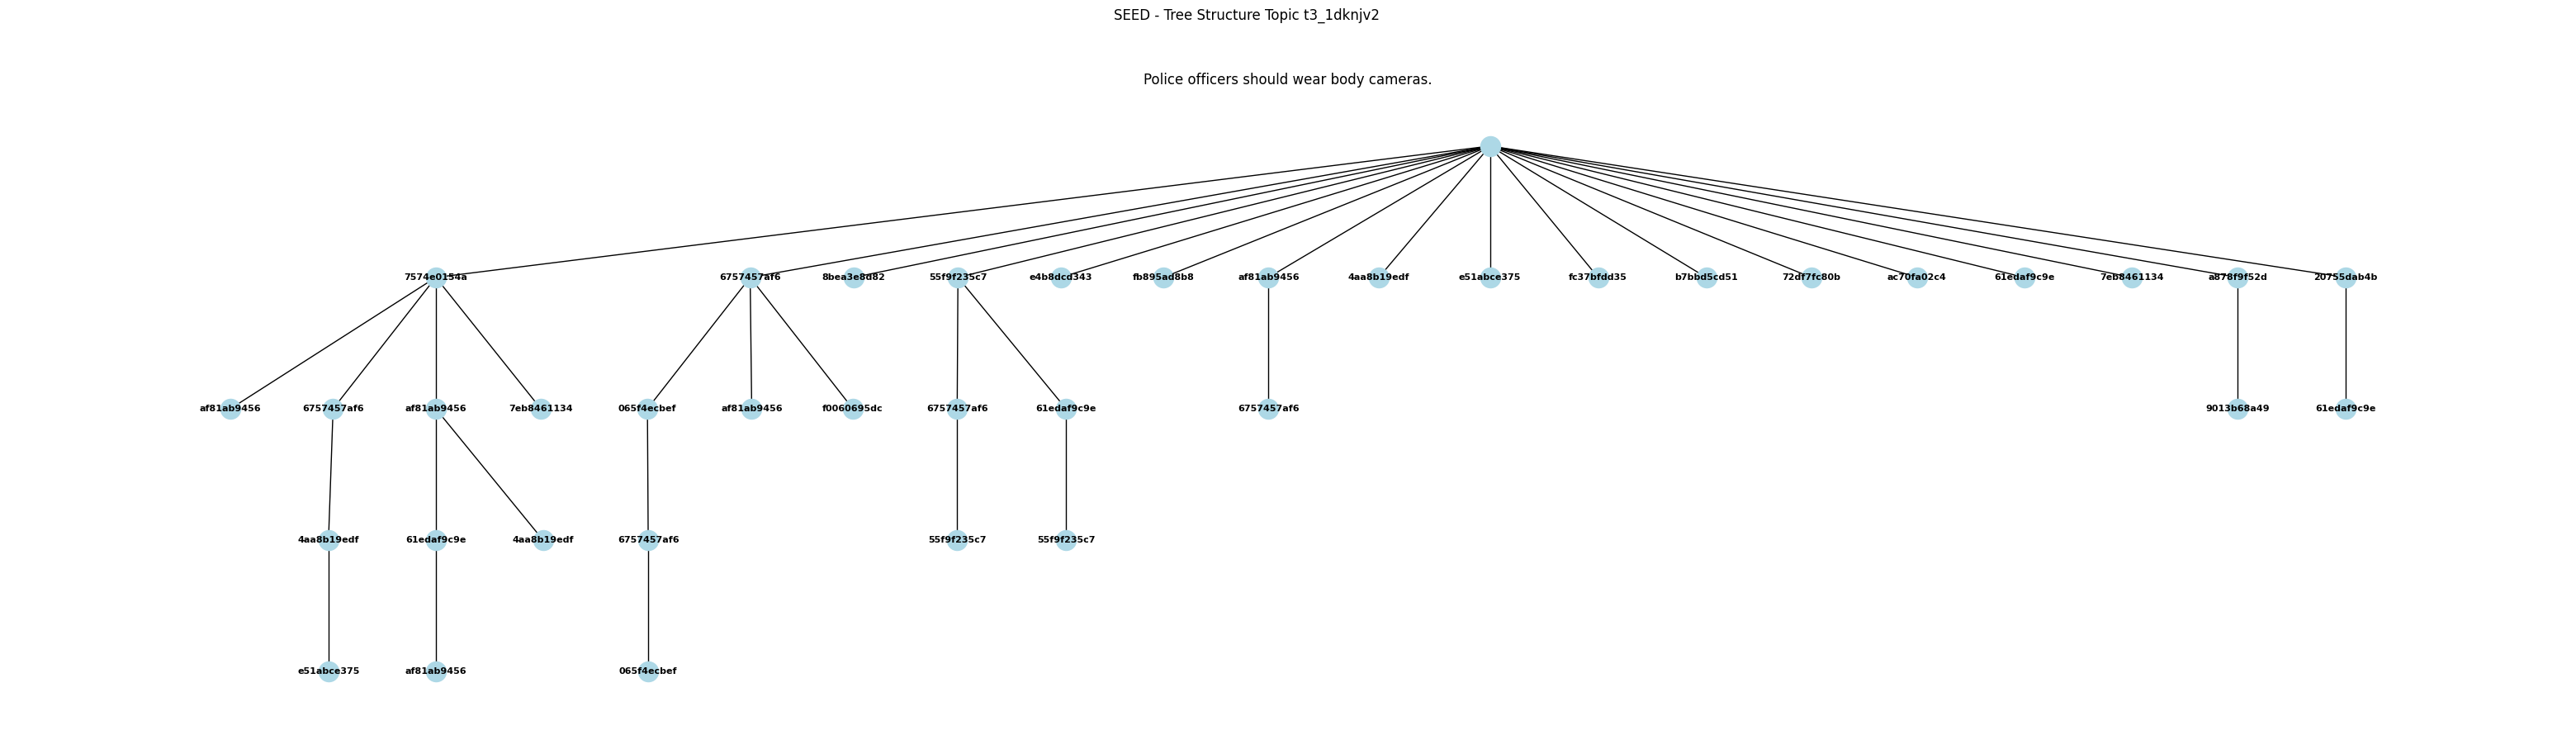

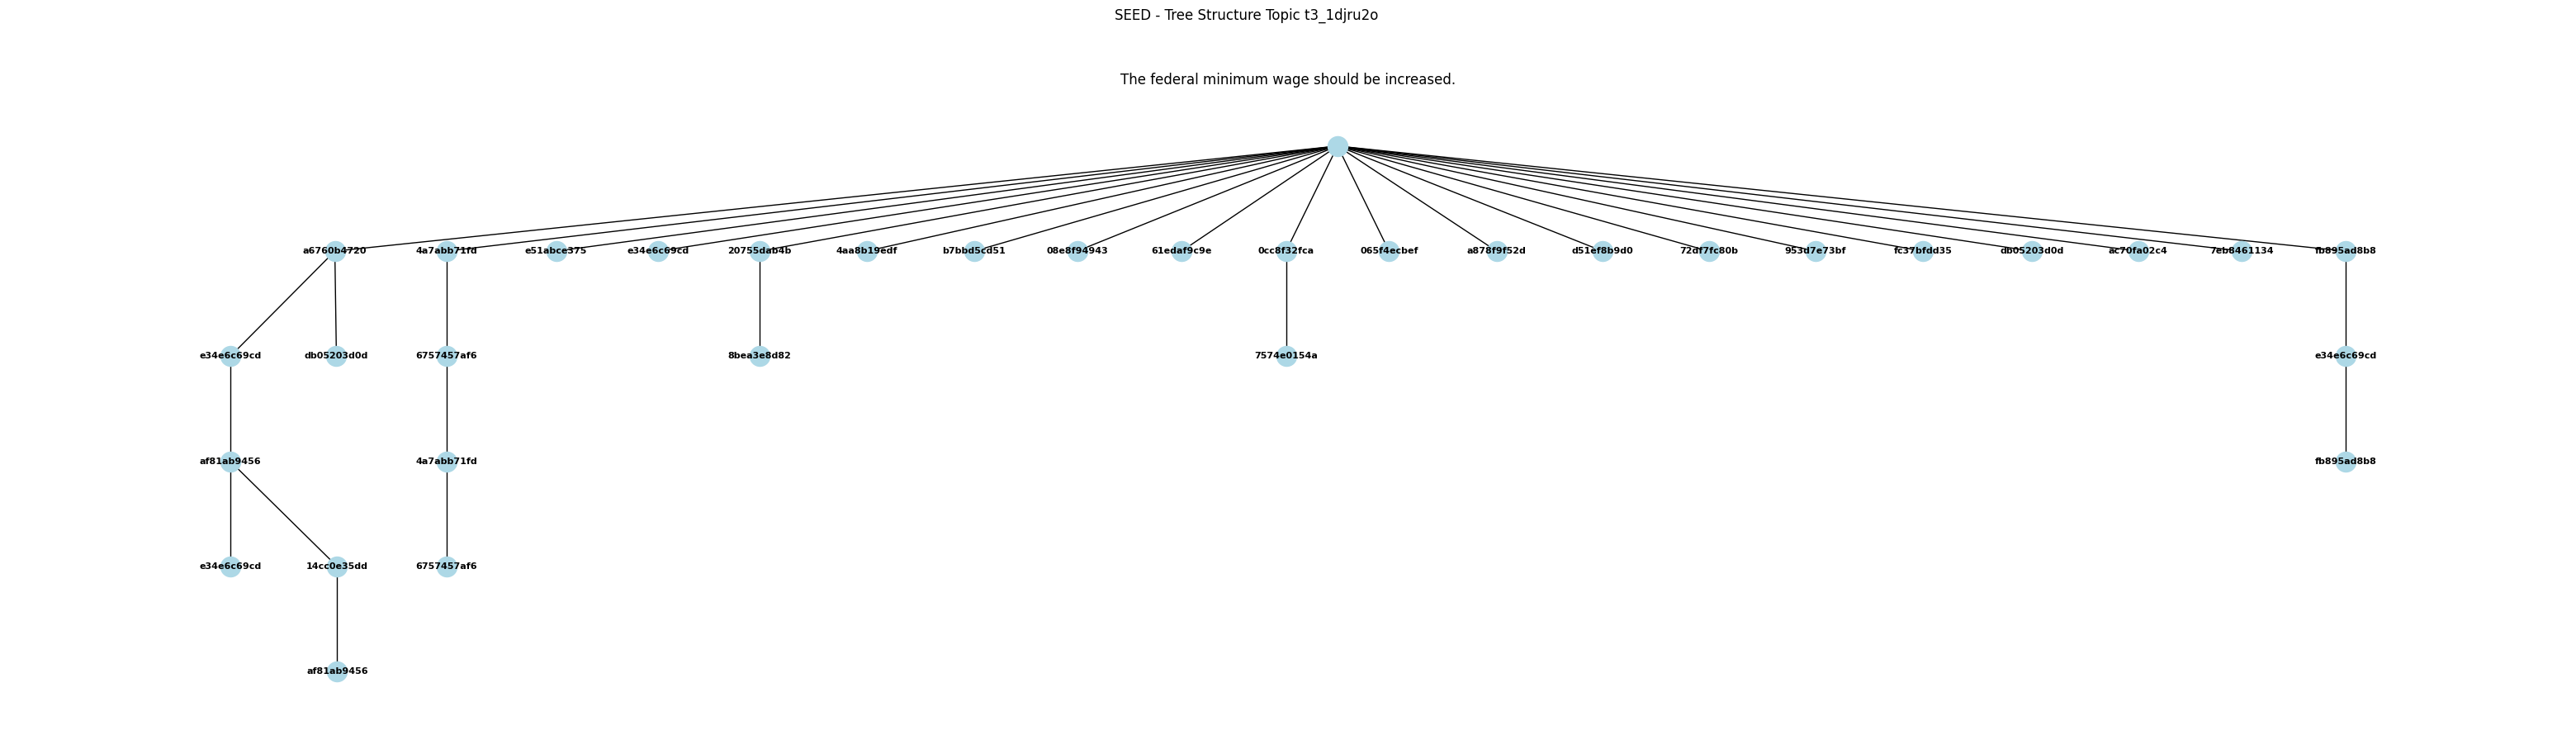

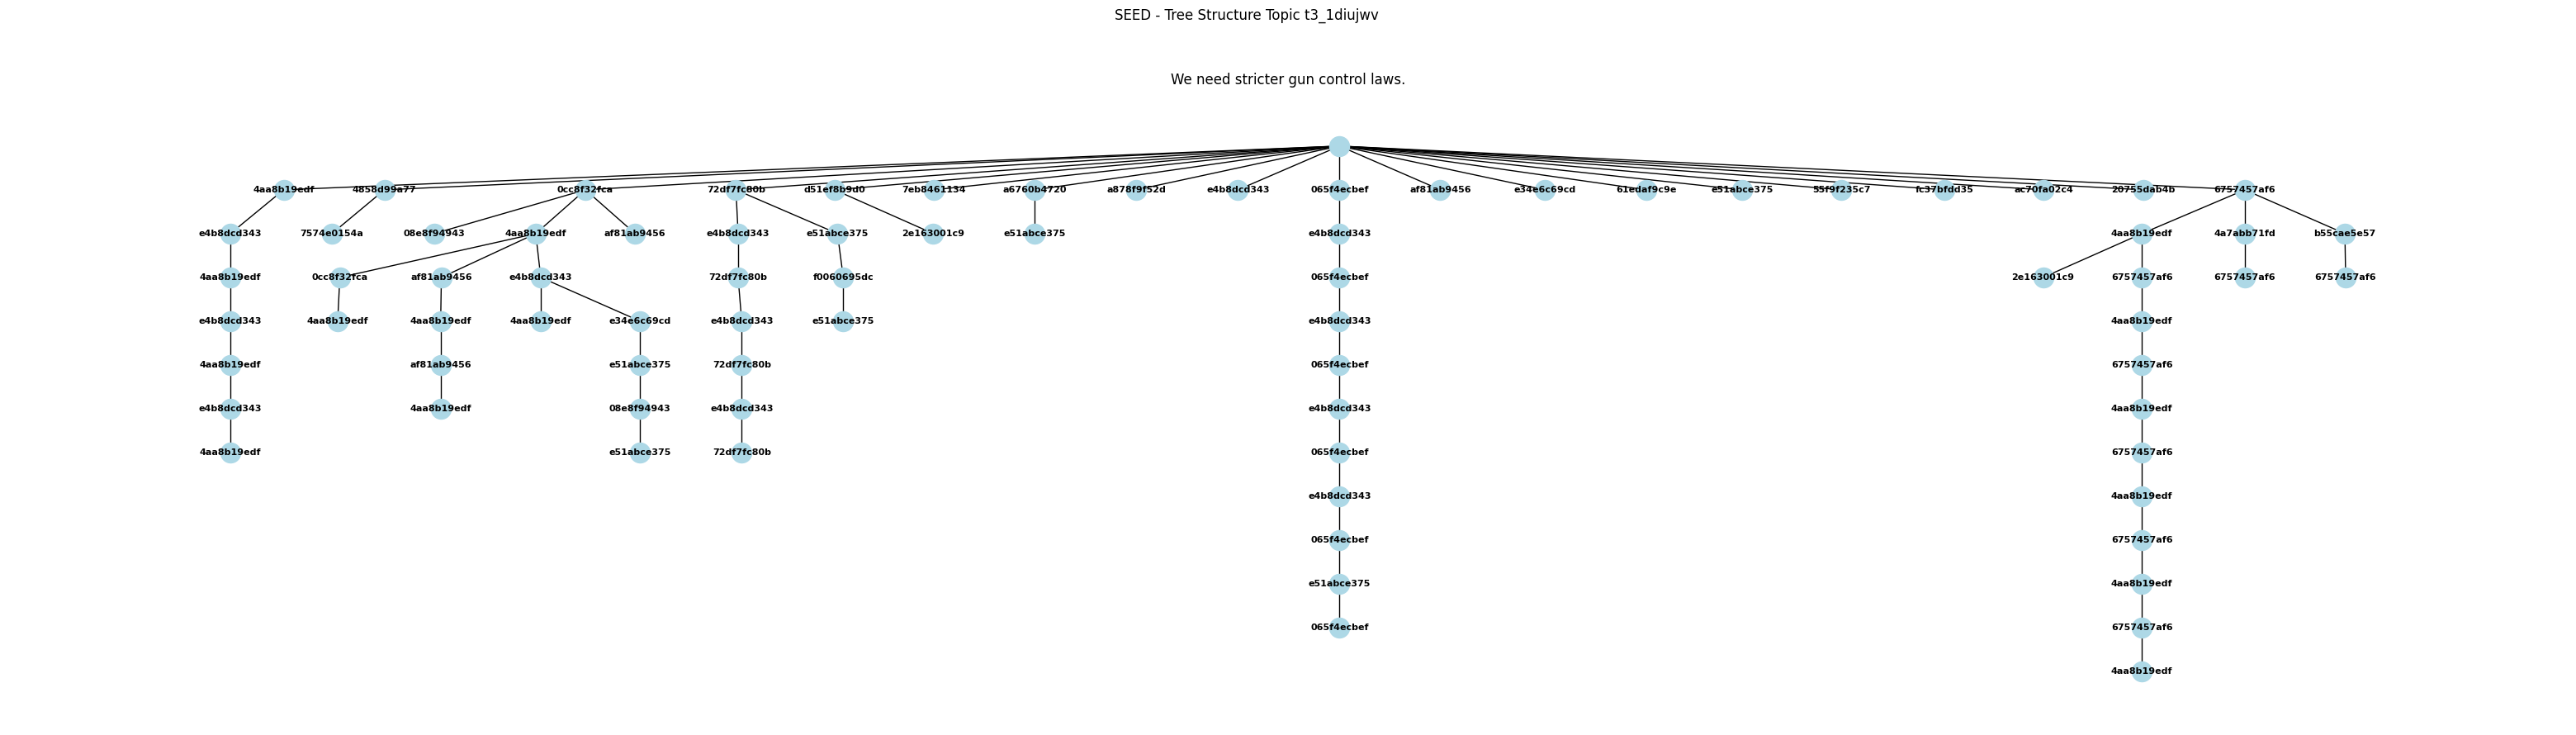

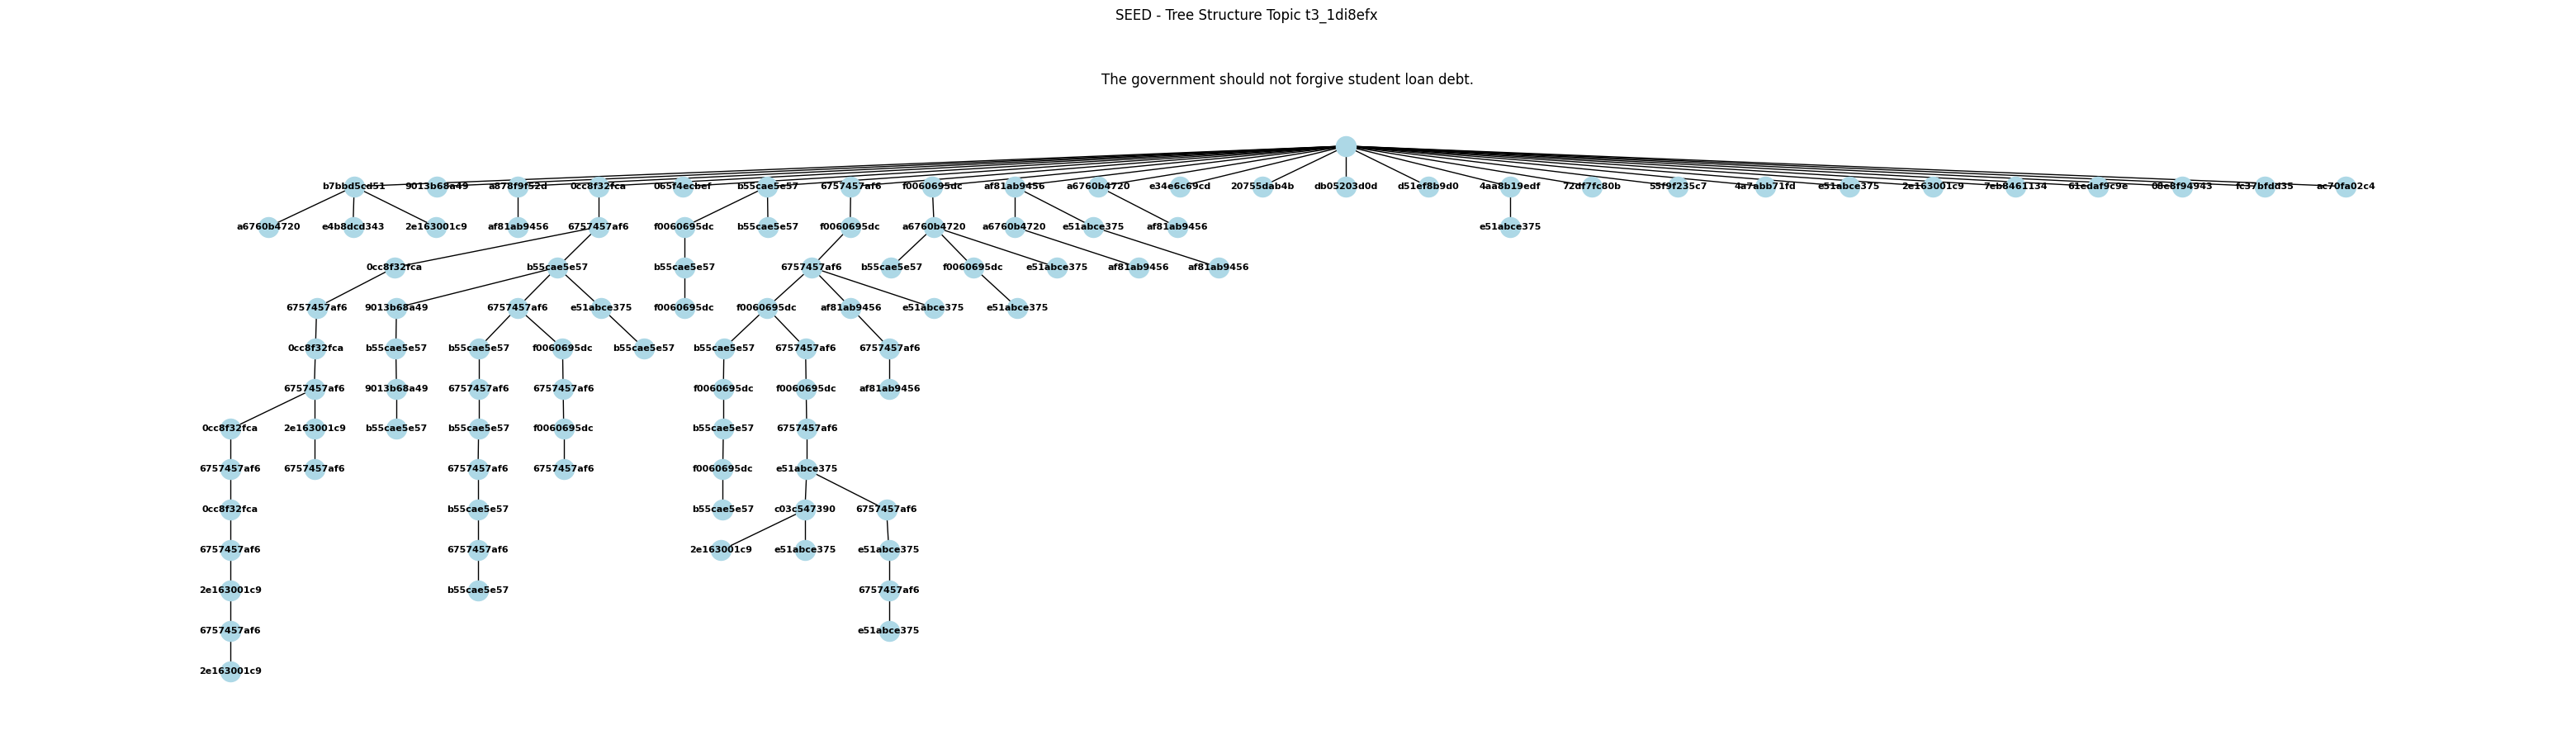

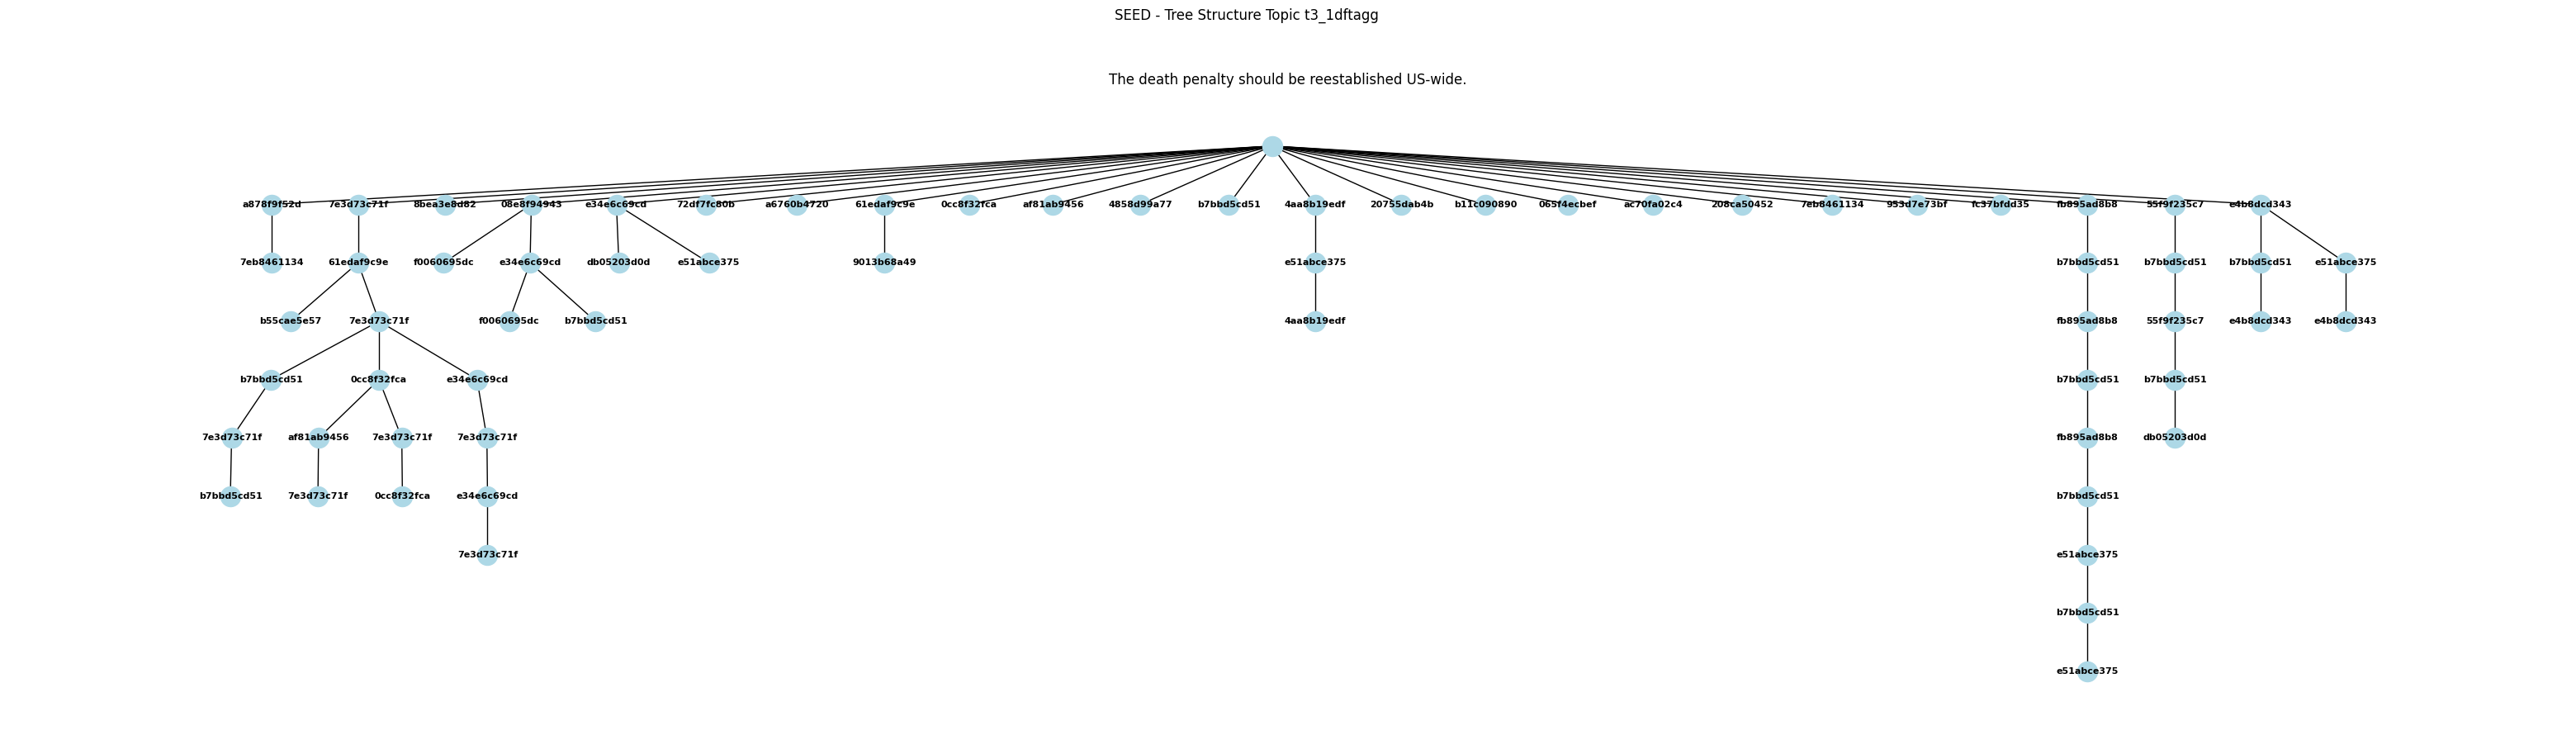

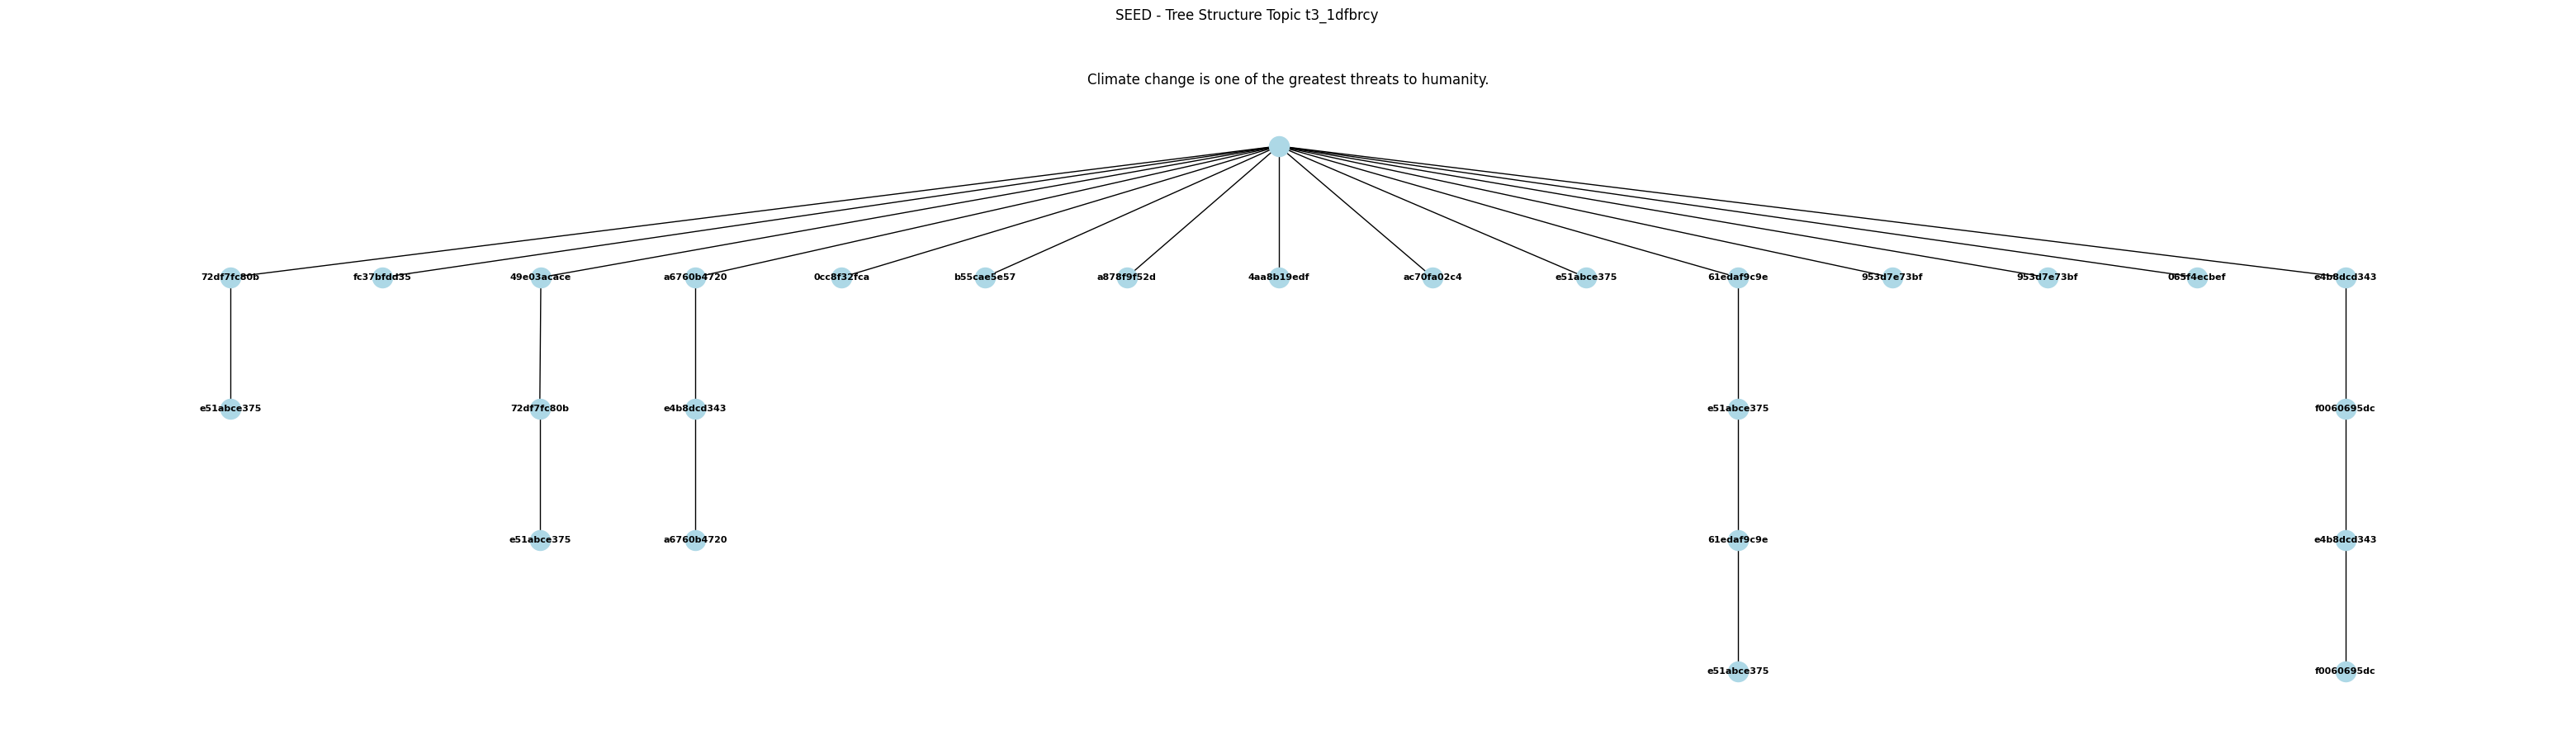

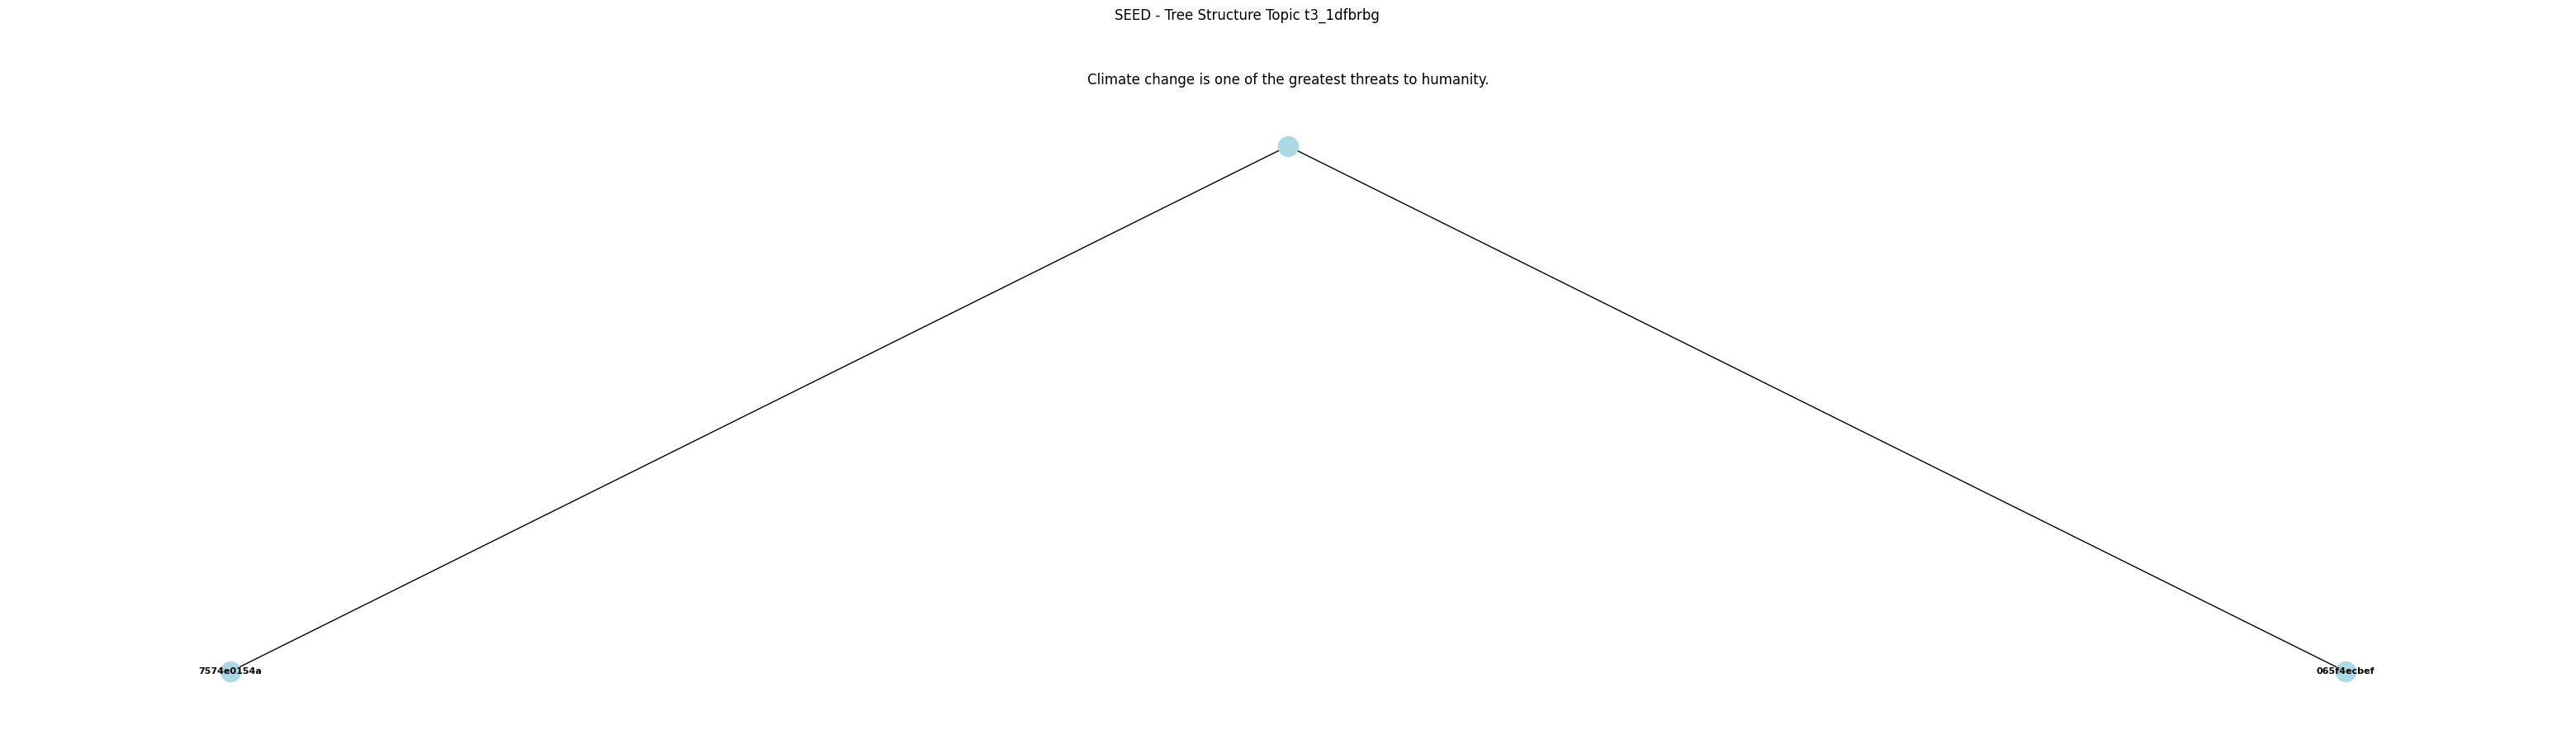

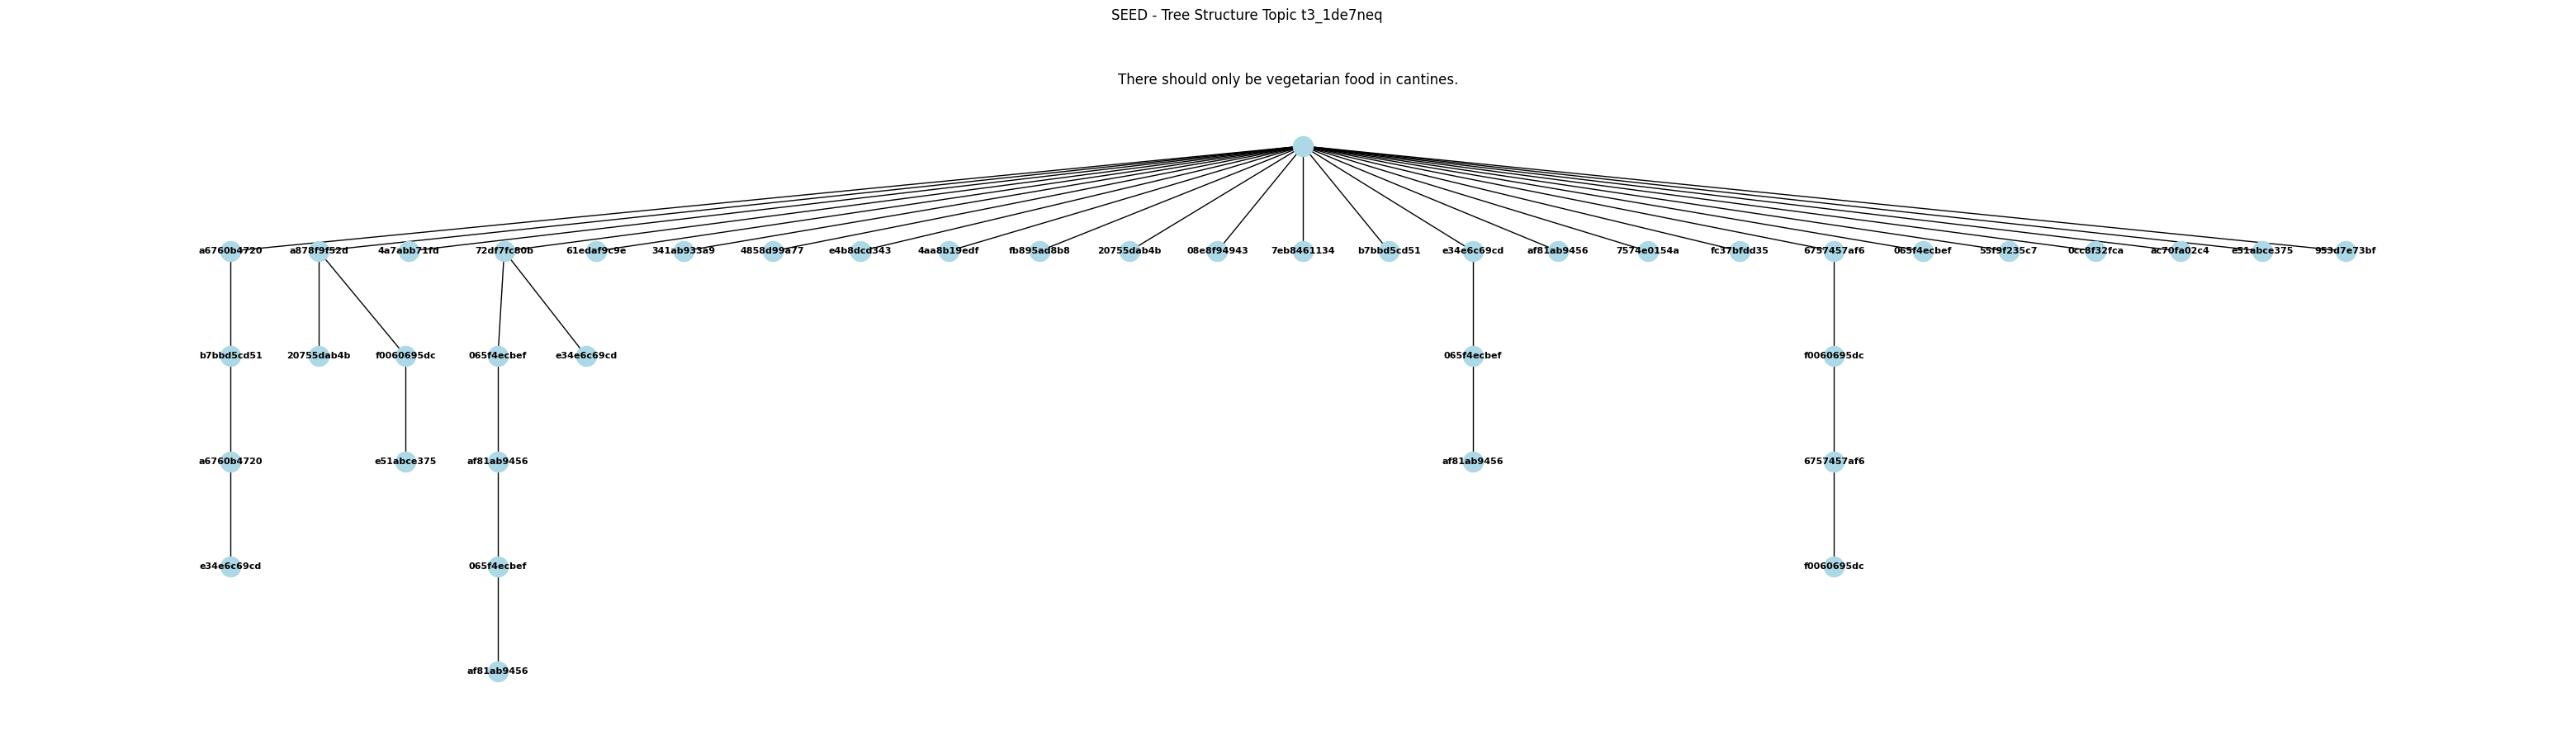

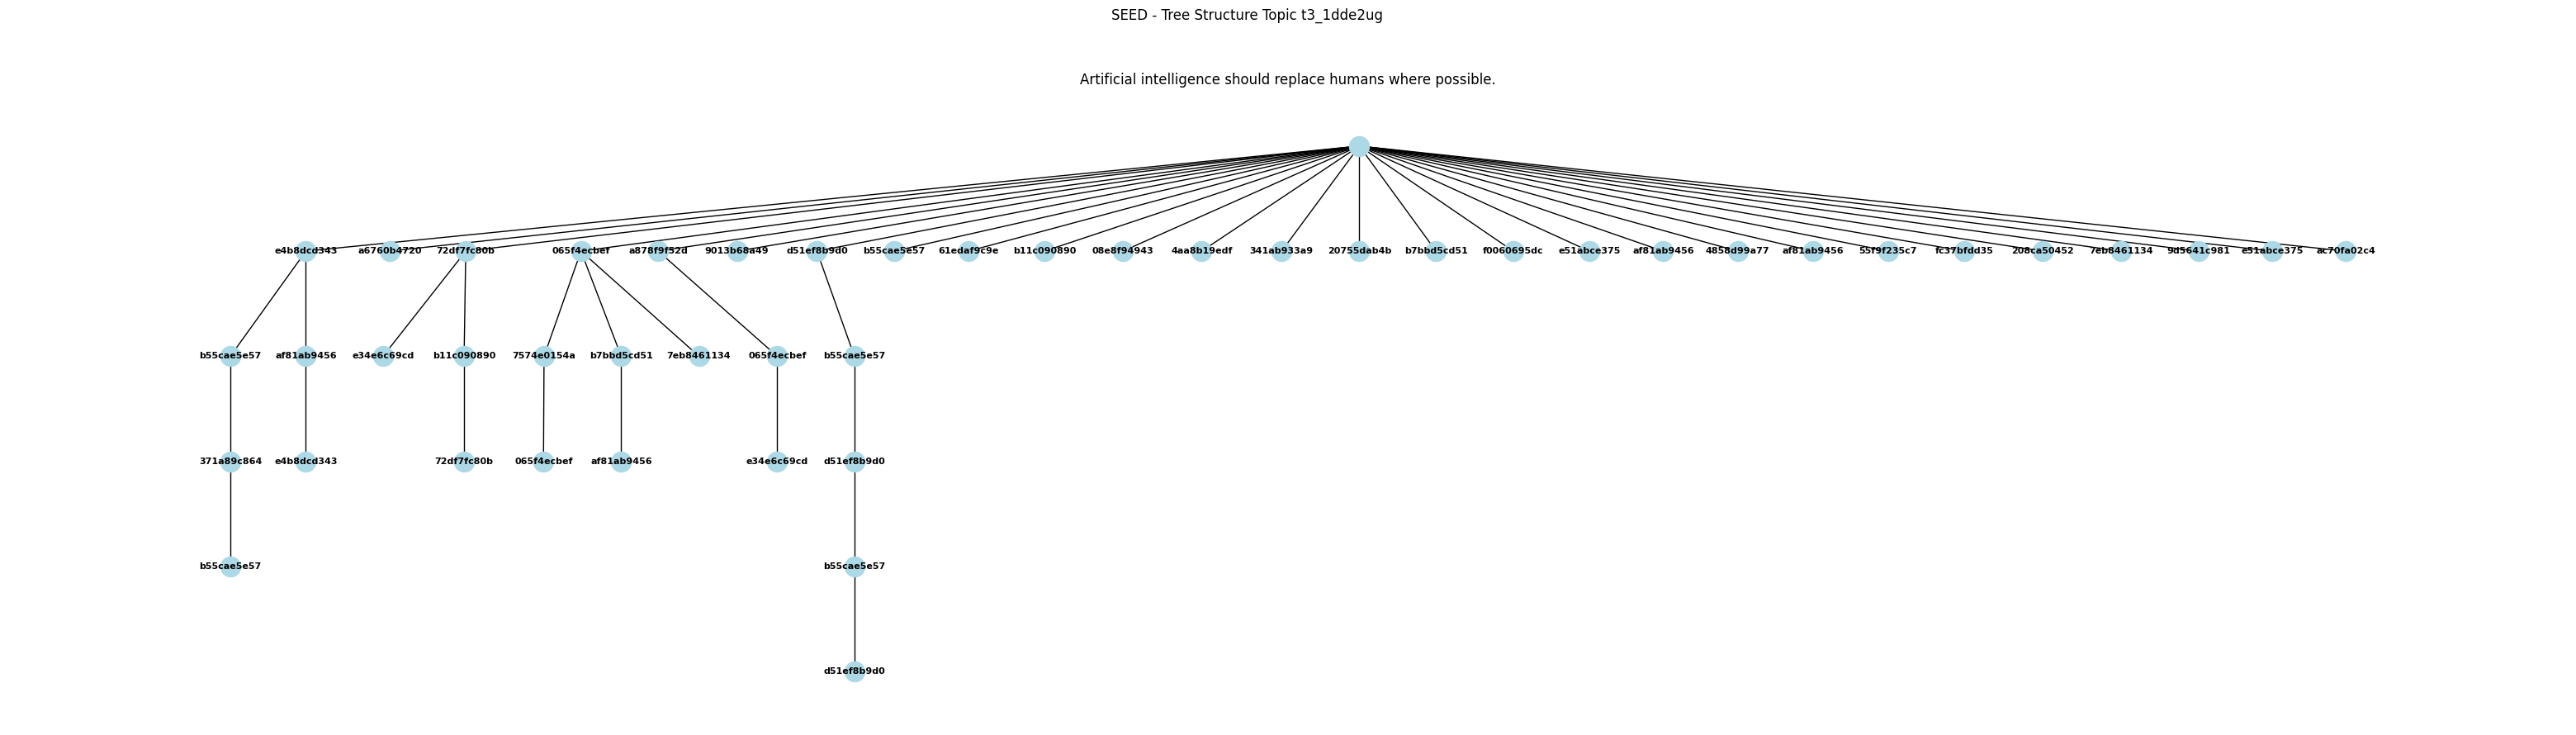

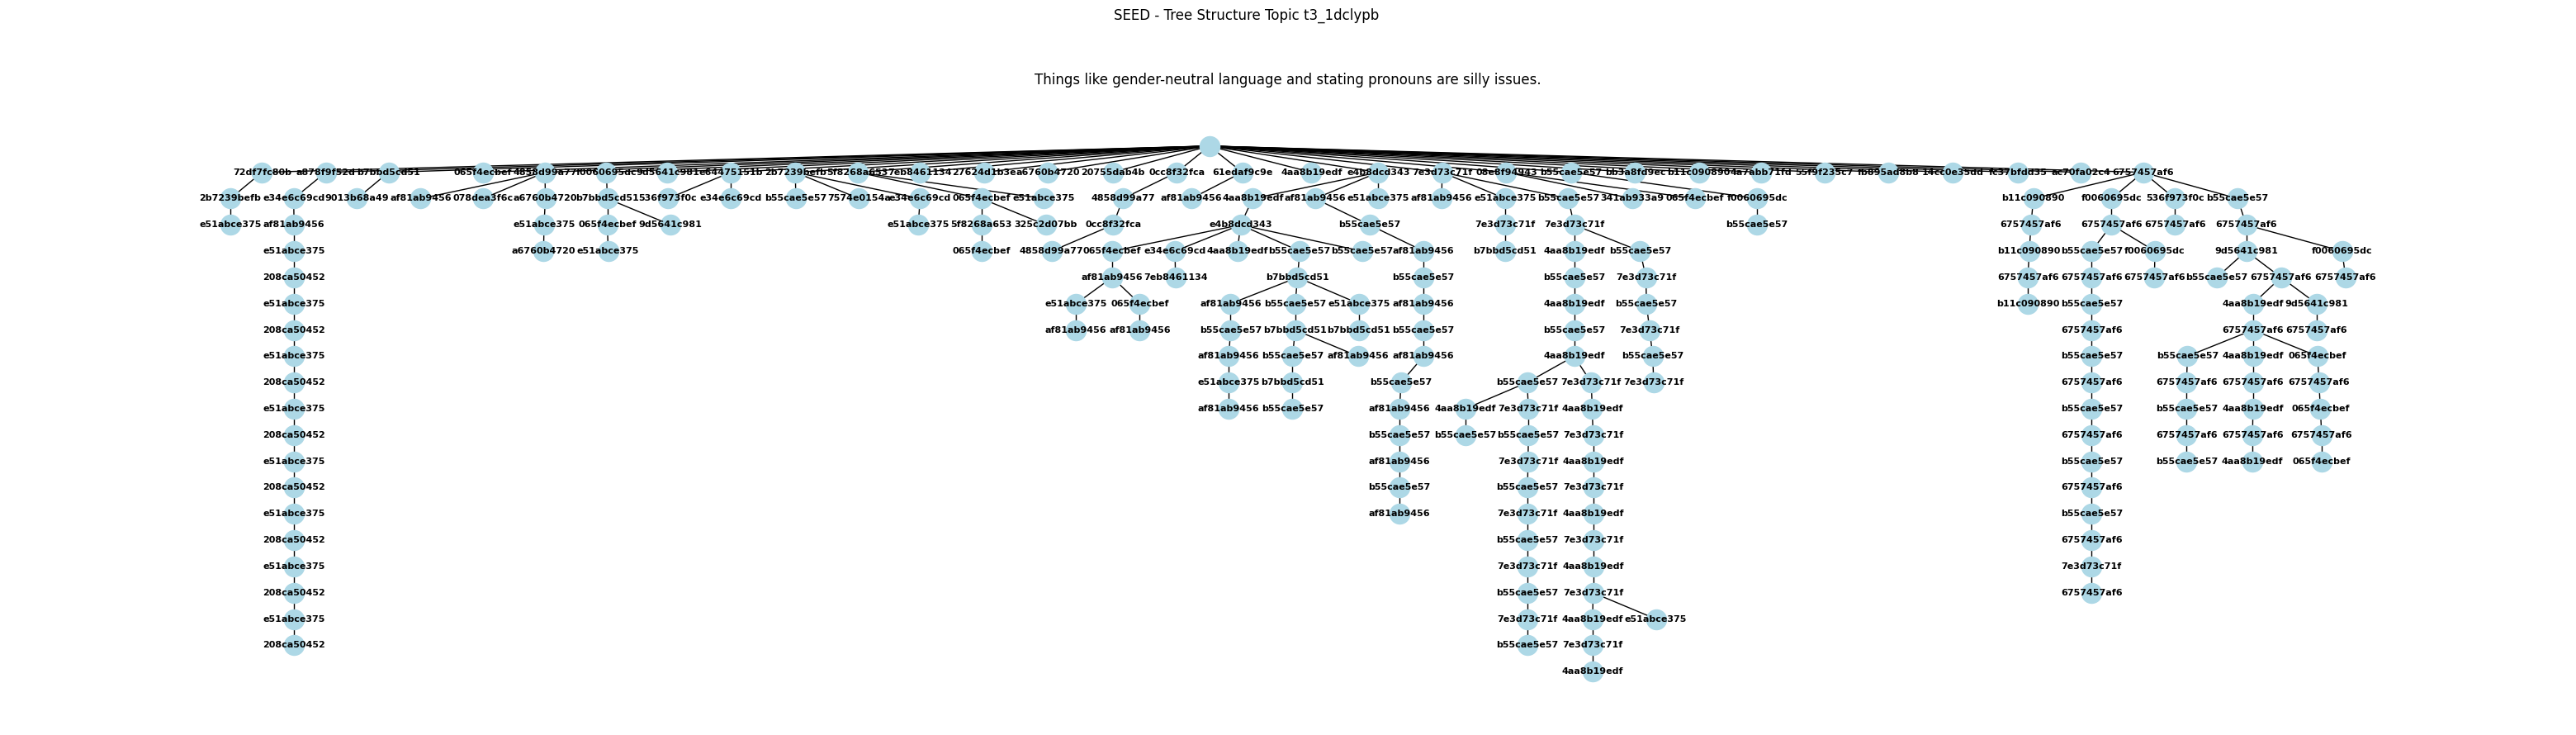

In [101]:
temp = discussions_data[discussions_data["subreddit"] == "DiscussPolitics1"]
seed_network = visualize_thread_tree(temp, data_type="seed")

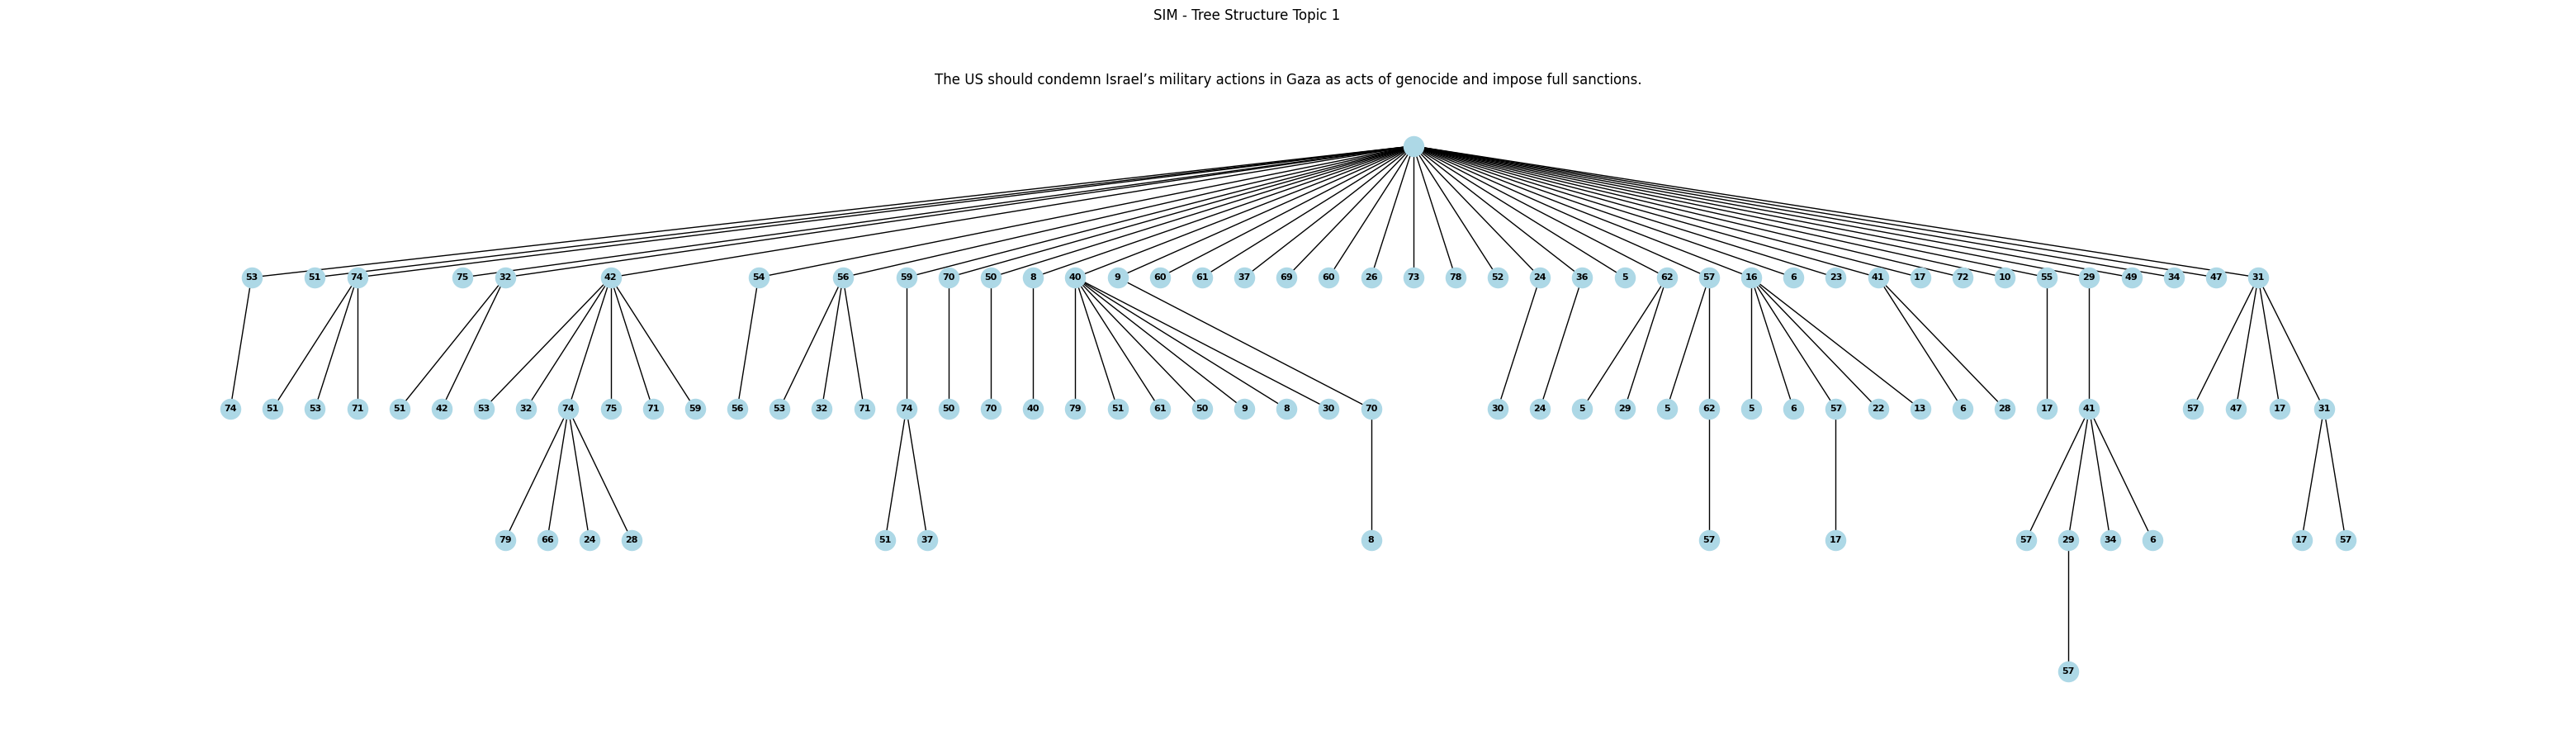

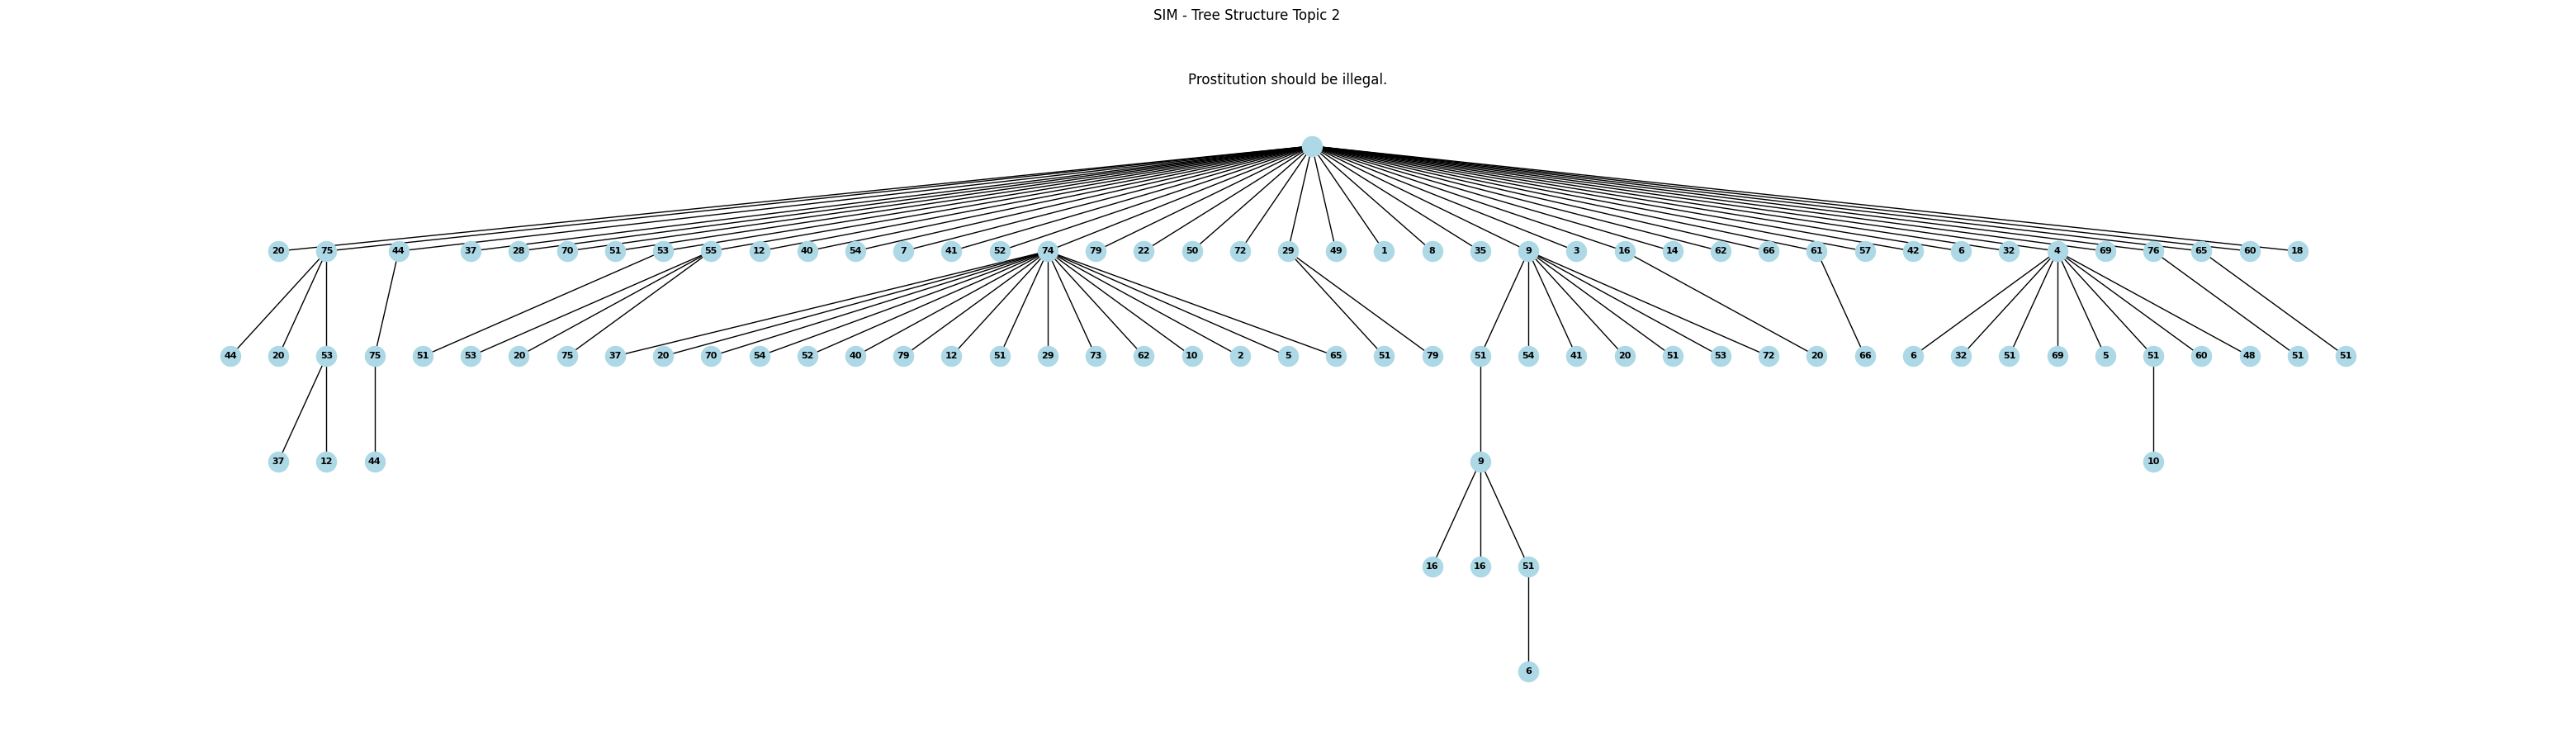

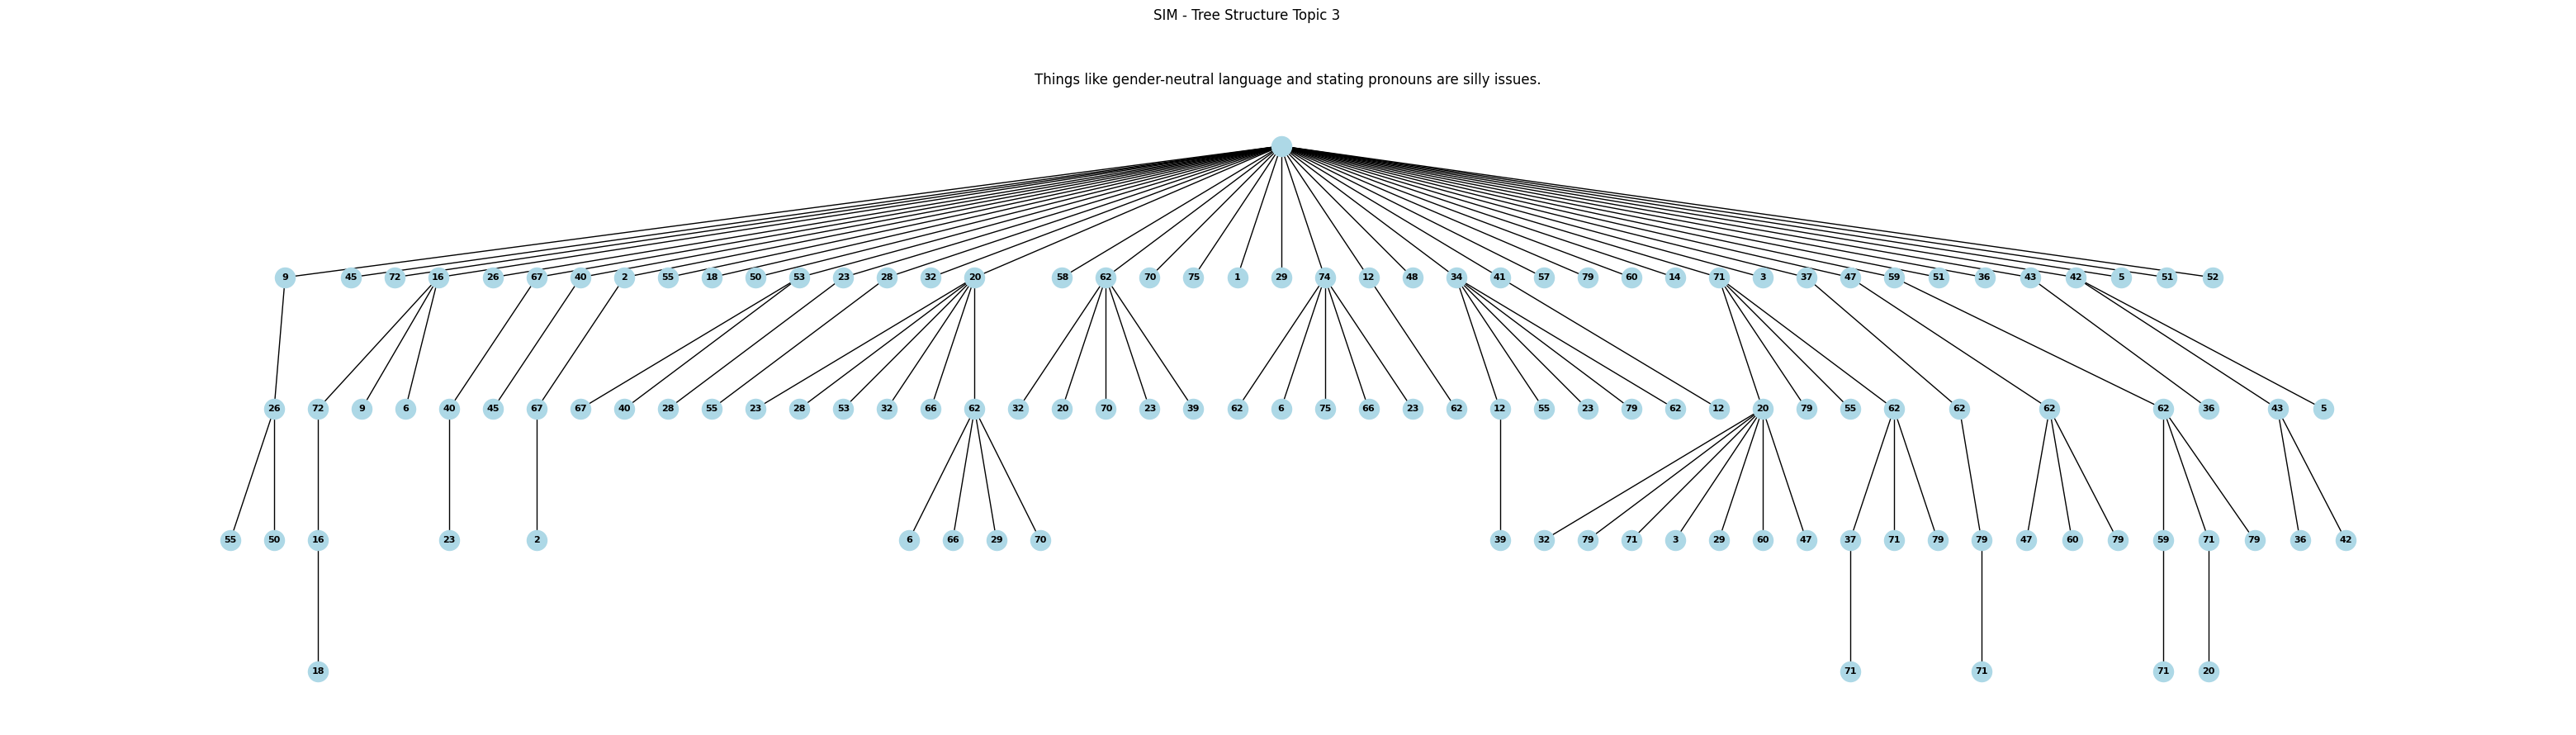

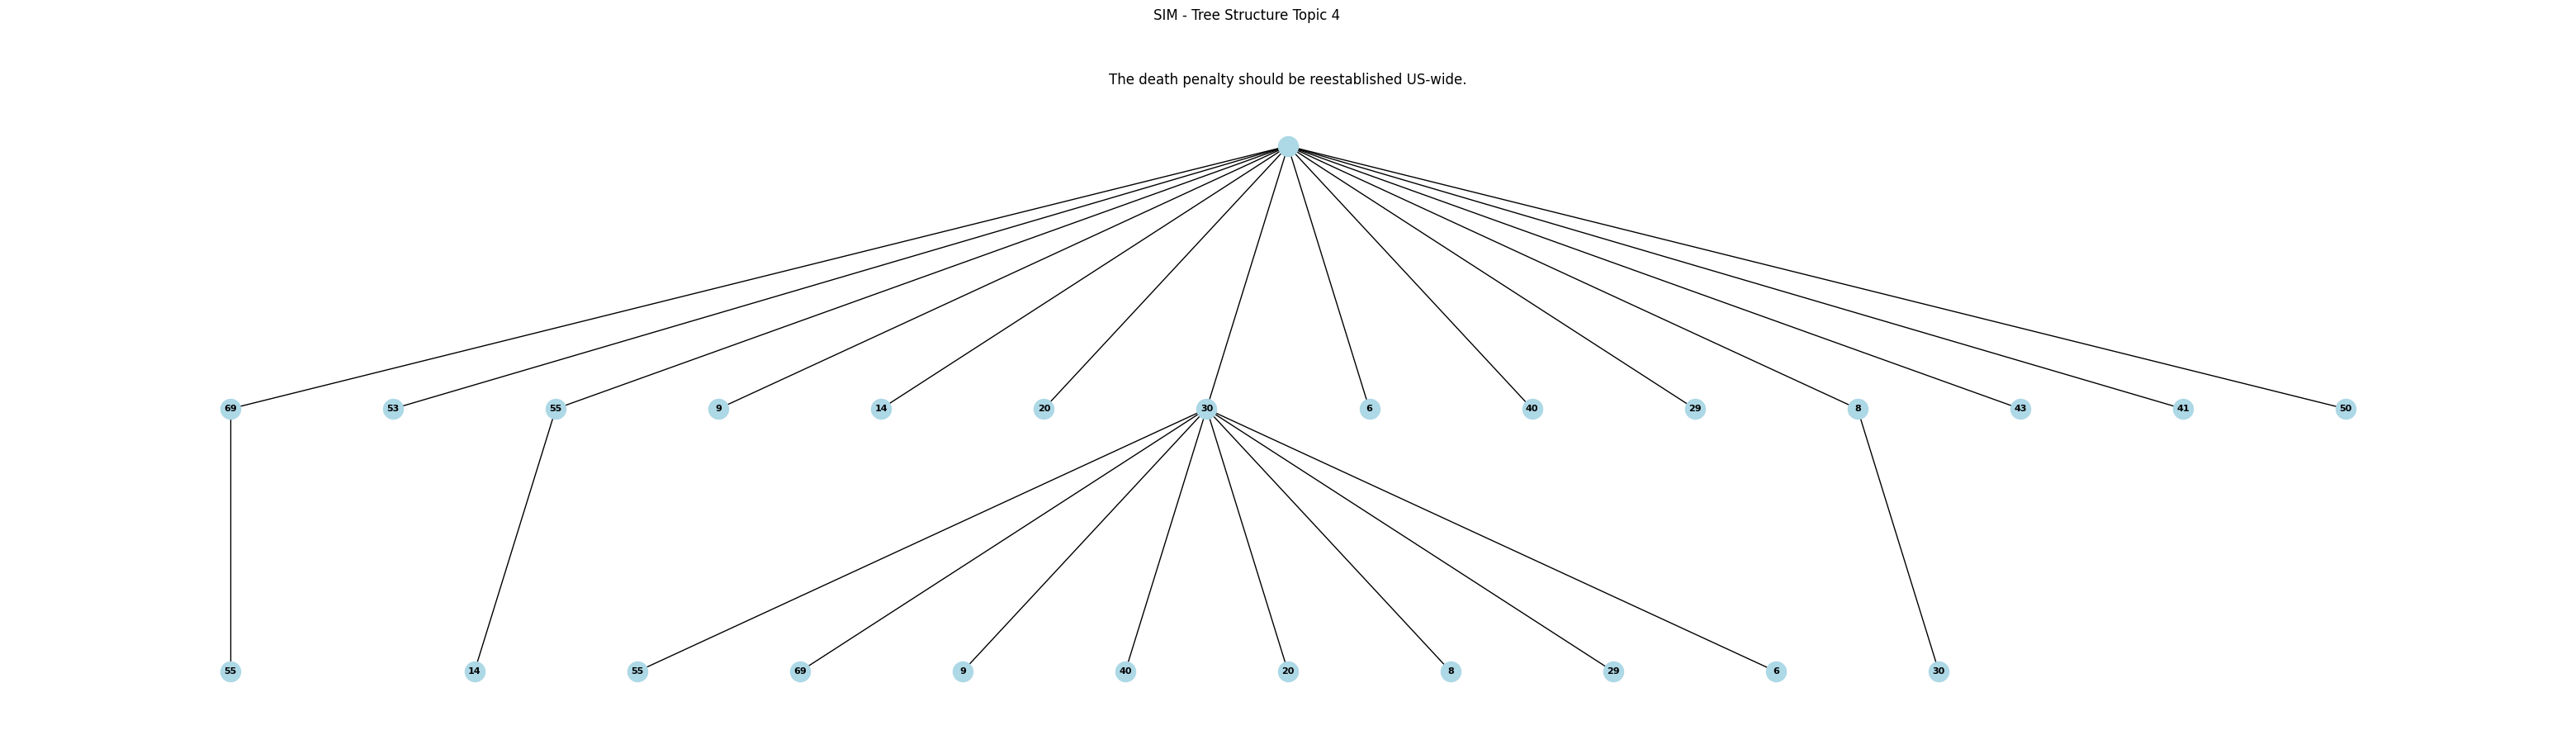

In [102]:
sim_network = visualize_thread_tree(data[start_str], data_type="sim")

In [242]:
seed_avg_density = round_mean(seed_network['density'])
seed_median_density = round_mean(seed_network['density'], mode="median")
seed_avg_depth = round_mean(seed_network['depth'])
seed_median_depth = round_mean(seed_network['depth'], mode="median")
seed_avg_width = round_mean(seed_network['width'])
seed_median_width = round_mean(seed_network['width'], mode="median")

sim_avg_density = round_mean(sim_network['density'])
sim_median_density = round_mean(sim_network['density'], mode="median")
sim_avg_depth = round_mean(sim_network['depth'])
sim_median_depth = round_mean(sim_network['depth'], mode="median")
sim_avg_width = round_mean(sim_network['width'])
sim_median_width = round_mean(sim_network['width'], mode="median")

seed_active_users = round_mean(seed_active_users)
sim_active_users = round_mean(
    [i for j in [i["active"] for i in [structure_data[k] for k in list(structure_data.keys())]] for i in j]
)

print("{:<30}{:^10}|{:^10}".format("Tree Structure", "Seed", "Sim"))
print("{:<30}{:^10}|{:^10}".format("Average Degree:", seed_network['avg_degree'], sim_network['avg_degree']))
print("{:<30}{:^10}|{:^10}".format("Median Degree:", seed_network['median_degree'], sim_network['median_degree']))
print("{:<30}{:^10}|{:^10}".format("Average Density:", seed_avg_density, sim_avg_density))
print("{:<30}{:^10}|{:^10}".format("Median Density:", seed_median_density, sim_median_density))
print("{:<30}{:^10}|{:^10}".format("Average Depth:", seed_avg_depth, sim_avg_depth))
print("{:<30}{:^10}|{:^10}".format("Median Depth:", seed_median_depth, sim_median_depth))
print("{:<30}{:^10}|{:^10}".format("Average Width:", seed_avg_width, sim_avg_width))
print("{:<30}{:^10}|{:^10}".format("Median Width:", seed_median_width, sim_median_width))
print("{:<30}{:^10}|{:^10}".format("% active Users:", seed_active_users, sim_active_users))

Tree Structure                   Seed   |   Sim    
Average Degree:                 1.958   |  1.977   
Median Degree:                   2.0    |   1.0    
Average Density:                0.088   |  0.033   
Median Density:                 0.054   |   0.02   
Average Depth:                   7.19   |   3.75   
Median Depth:                    5.0    |   4.0    
Average Width:                  17.381  |   37.5   
Median Width:                    17.0   |   44.5   
% active Users:                 0.637   |  0.582   


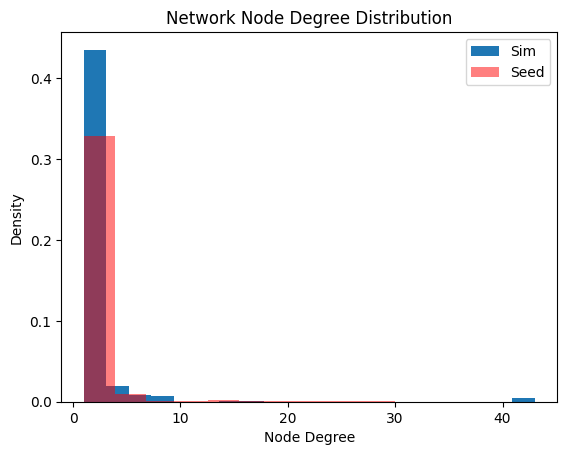

In [98]:
plt.hist([i for j in sim_network["degrees"] for i in j], density=True, bins=20, label="Sim")
plt.hist([i for j in seed_network["degrees"] for i in j], density=True, color="r", alpha=0.5, label="Seed")
plt.xlabel("Node Degree")
plt.ylabel("Density")
plt.legend()
plt.title("Network Node Degree Distribution")
if save_figs:
    plt.savefig("figures/seed-sim_dist_node-degrees.jpg")
plt.show()

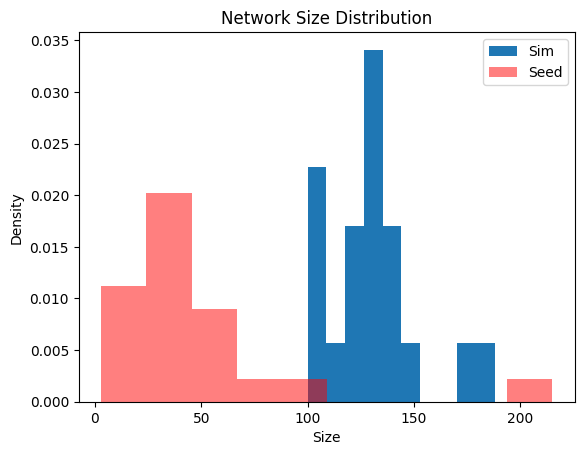

In [291]:
plt.hist(sim_network["size"], density=True, label="Sim")
plt.hist(seed_network["size"], density=True, color="r", alpha=0.5, label="Seed")
plt.xlabel("Size")
plt.ylabel("Density")
plt.legend()
plt.title("Network Size Distribution")
if save_figs:
    plt.savefig("figures/seed-sim_dist_network-size.jpg")
plt.show()

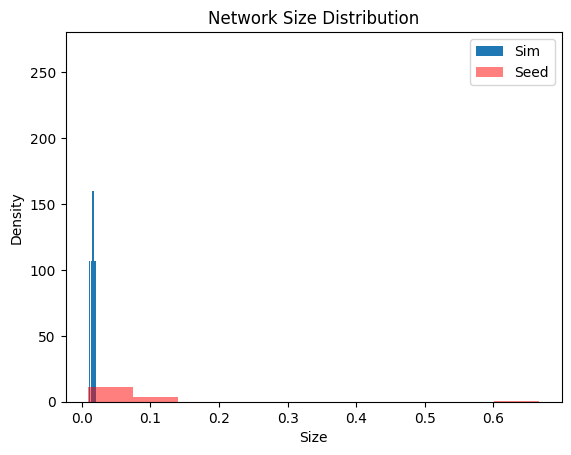

In [288]:
plt.hist(sim_network["density"], density=True, label="Sim")
plt.hist(seed_network["density"], density=True, color="r", alpha=0.5, label="Seed")
plt.xlabel("Size")
plt.ylabel("Density")
plt.legend()
plt.title("Node Density Distribution")
if save_figs:
    plt.savefig("figures/seed-sim_dist_node-density.jpg")
plt.show()

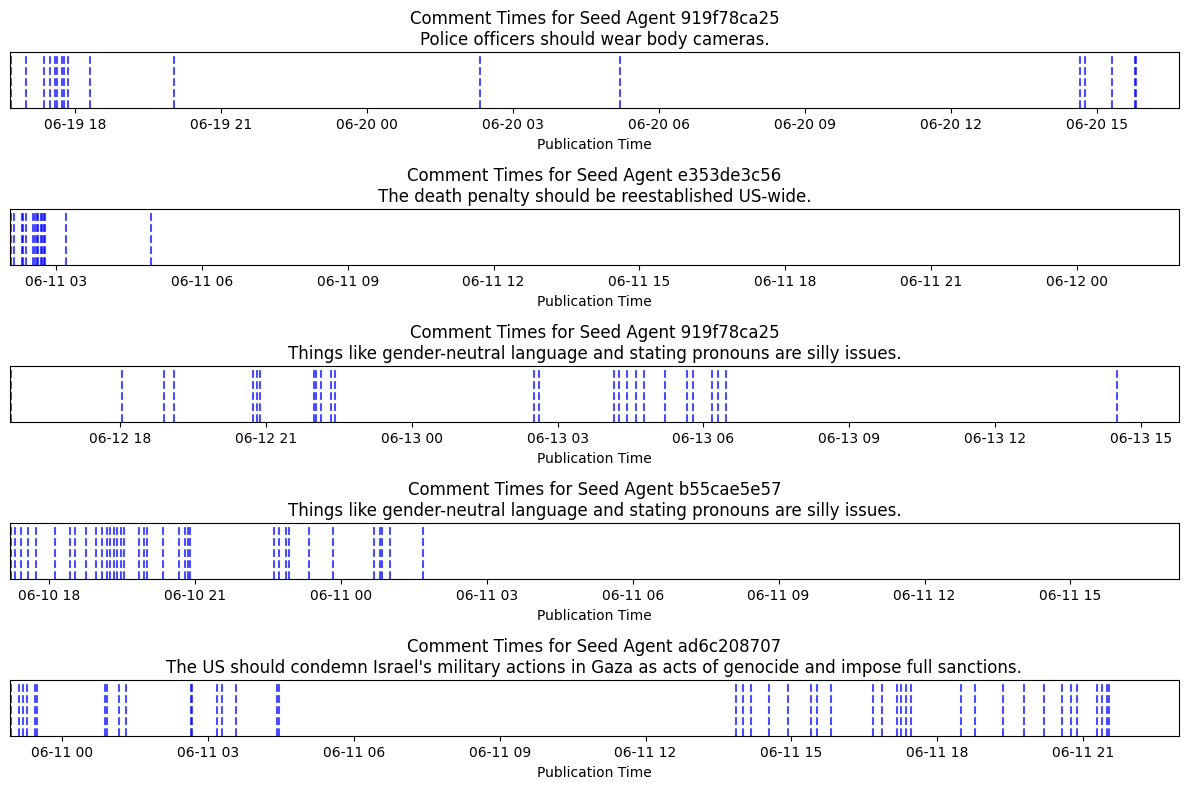

In [261]:
# Seed
temp = discussions_data.groupby(["ParticipantID", "post_title"]).size().sort_values().tail(5)

j = 0
fig, axs = plt.subplots(5, 1, figsize=(12, 8))
for i, r in temp.items():
    comments = discussions_data[
    discussions_data["ParticipantID"] == i[0]
    ]
    comments = comments[comments["post_title"] == i[1]][
    "created_comment"
    ]
    
    for comment in pd.to_datetime(comments):
        axs[j].axvline(x=comment, color='b', linestyle='--', alpha=0.7)
    
    # axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
    #              pd.to_datetime(comments).max() + pd.Timedelta(minutes=1)])
    axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
                 pd.to_datetime(comments).min() + pd.Timedelta(hours=24, minutes=1)])
    # axs[j].set_ylim([0, 0.9])
    axs[j].set_title(f"Comment Times for Seed Agent {i[0]}\n{i[1]}")
    axs[j].set_xlabel("Publication Time")

    axs[j].set_yticks([])

    j += 1

plt.tight_layout()
if save_figs:
    plt.savefig("figures/seed_top-5_burst.jpg")
plt.show()

In [211]:
data[list(data.keys())[1]]["created_at"].max()

'2025-07-21 09:29:57.059220'

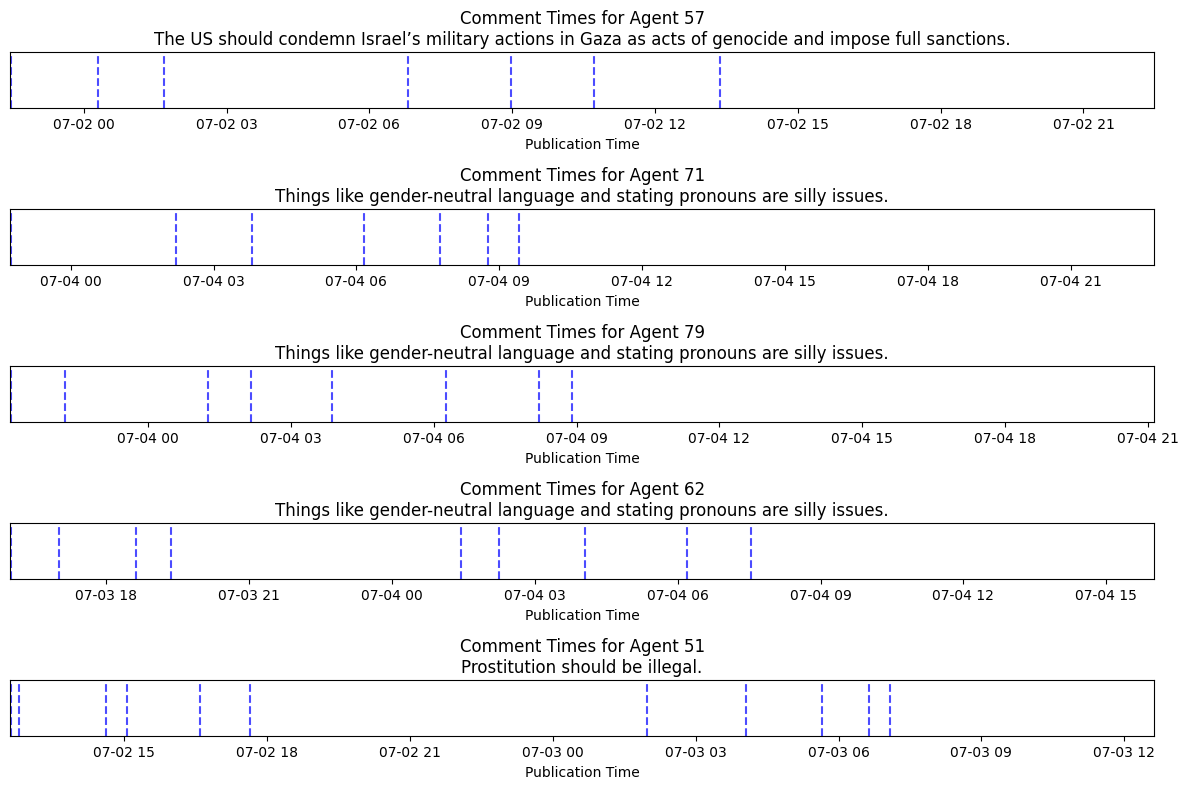

In [99]:
# SIM
n = 5
tem = data[list(data.keys())[0]]
temp = tem.groupby(["user_id", "seed_post_content"]).size().sort_values().tail(n)

j = 0
fig, axs = plt.subplots(n, 1, figsize=(12, 8))
for i, r in temp.items():
    comments = tem[
    tem["user_id"] == i[0]
    ]
    comments = comments[comments["seed_post_content"] == i[1]][
    "created_at"
    ]
    
    for comment in pd.to_datetime(comments):
        axs[j].axvline(x=comment, color='b', linestyle='--', alpha=0.7)
    
    # axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
    #              pd.to_datetime(comments).max() + pd.Timedelta(minutes=1)])
    axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
                 pd.to_datetime(comments).min() + pd.Timedelta(hours=24, minutes=1)])
    axs[j].set_ylim([0, 0.1])
    axs[j].set_title(f"Comment Times for Agent {i[0]}\n{i[1]}")
    axs[j].set_xlabel("Publication Time")

    axs[j].set_yticks([])

    j += 1

plt.tight_layout()
if save_figs:
    plt.savefig("figures/sim_top-5_burst.jpg")
plt.show()

In [27]:
# Determine intial activation prob
k = 0
n = 24
ps = [
    0.0025,
    0.00325,
    0.015, 
    0.05, 
    0.1
]

for p in ps:
    print(f"Min. {k+1} over {n}({p})", round(scipy.stats.binom.sf(k, n, p), 3))

Min. 1 over 24(0.0025) 0.058
Min. 1 over 24(0.00325) 0.075
Min. 1 over 24(0.015) 0.304
Min. 1 over 24(0.05) 0.708
Min. 1 over 24(0.1) 0.92


In [226]:
# Function to help remove outliers via IQR
def get_quartiles(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr
    return lb, ub

# Visualize Seed activation probability function
discussions_data["created_comment"] = pd.to_datetime(
    discussions_data["created_comment"]
)
discussions_data["interevent_diff"] = discussions_data.sort_values(
    ["ParticipantID", "created_comment"]
).groupby("ParticipantID")["created_comment"].diff().dt.total_seconds()

# Get most active seed user
# discussions_data.groupby("ParticipantID").size().sort_values()

temp = discussions_data.copy()

# Intital posts not preceeded by another post hold NA value for ie_diff
print("Oswald: N Total Posts:", len(temp))
print("Oswald: N First Posts:", temp["interevent_diff"].isna().sum())
temp.dropna(subset=["interevent_diff"], inplace=True)
temp = temp[temp["interevent_diff"] != 0.0]
# remove outliers
temp = temp[temp["interevent_diff"] <= get_quartiles(
    temp["interevent_diff"]
)[1]]
temp = temp["interevent_diff"].sort_values()
print("Oswald: N Posts:", len(temp))
ie_times_seed = temp

Oswald: N Total Posts: 5792
Oswald: N First Posts: 334
Oswald: N Posts: 4863


In [227]:
intraevent_data = discussions_data[discussions_data["interevent_diff"] <= 10800]
interevent_data = discussions_data[discussions_data["interevent_diff"] > 10800]

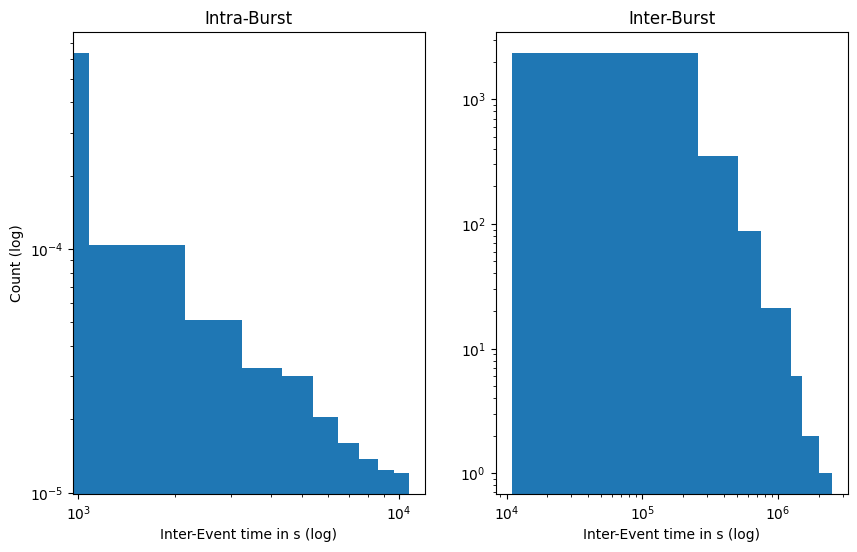

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))

axs[0].hist(intraevent_data["interevent_diff"], density=True)
axs[1].hist(interevent_data["interevent_diff"])

axs[0].set_title("Intra-Burst")
axs[0].set_xscale("log")
axs[0].set_xlabel("Inter-Event time in s (log)")
axs[0].set_yscale("log")
axs[0].set_ylabel("Count (log)")

axs[1].set_title("Inter-Burst")
axs[1].set_xscale("log")
axs[1].set_xlabel("Inter-Event time in s (log)")
axs[1].set_yscale("log")

if save_figs:
    plt.savefig("figures/seed_intra-inter-burst-dists.jpg")
plt.show()

In [31]:
# intraevent_data.to_csv("/../abyss/home/oasis/data/intraevent.csv", index=False)

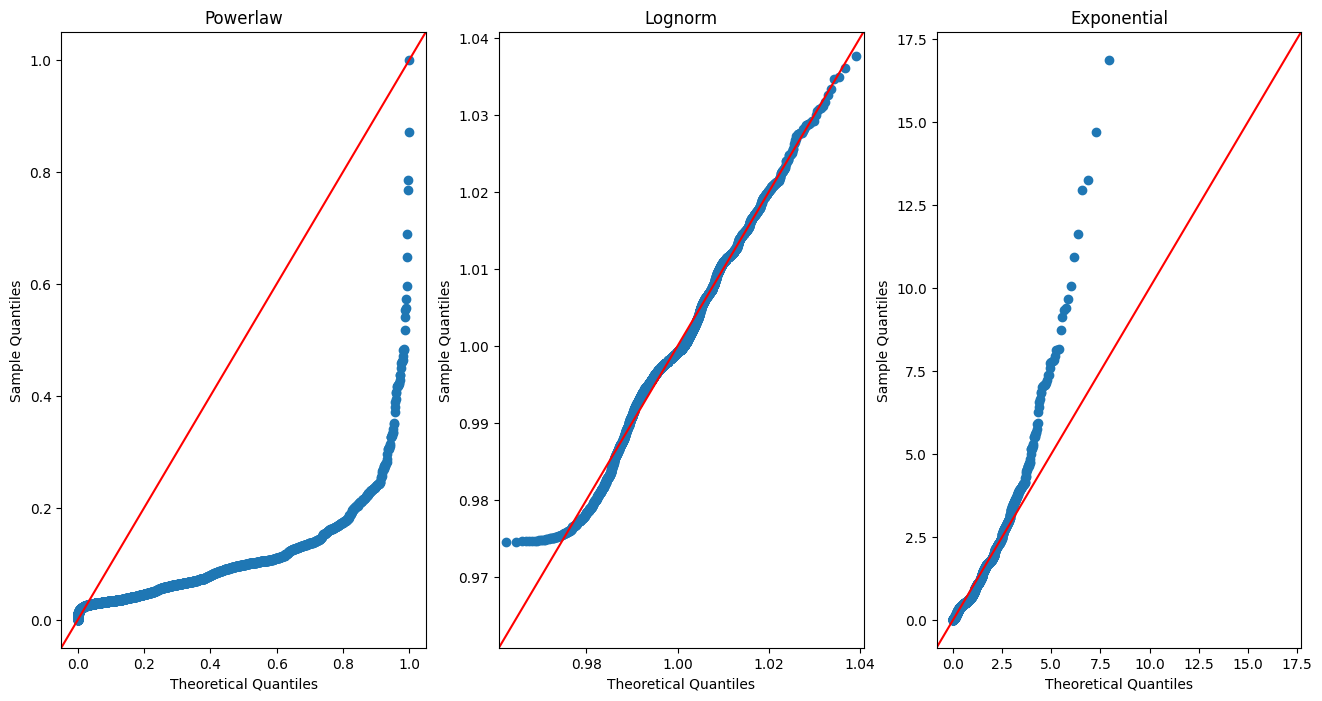

In [243]:
# Interevent
temp = interevent_data
temp = temp["interevent_diff"]

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

qqplot(temp, scipy.stats.distributions.powerlaw, line="45", fit=True, ax=ax[0])
ax[0].set_title("Powerlaw")

qqplot(np.log(temp), scipy.stats.distributions.lognorm, line="45", fit=True, ax=ax[1])
ax[1].set_title("Lognorm")

qqplot(temp, scipy.stats.distributions.expon, line="45", fit=True, ax=ax[2])
ax[2].set_title("Exponential")

if save_figs:
    plt.savefig("figures/seed_inter-event-qqplots.jpg")
plt.show()

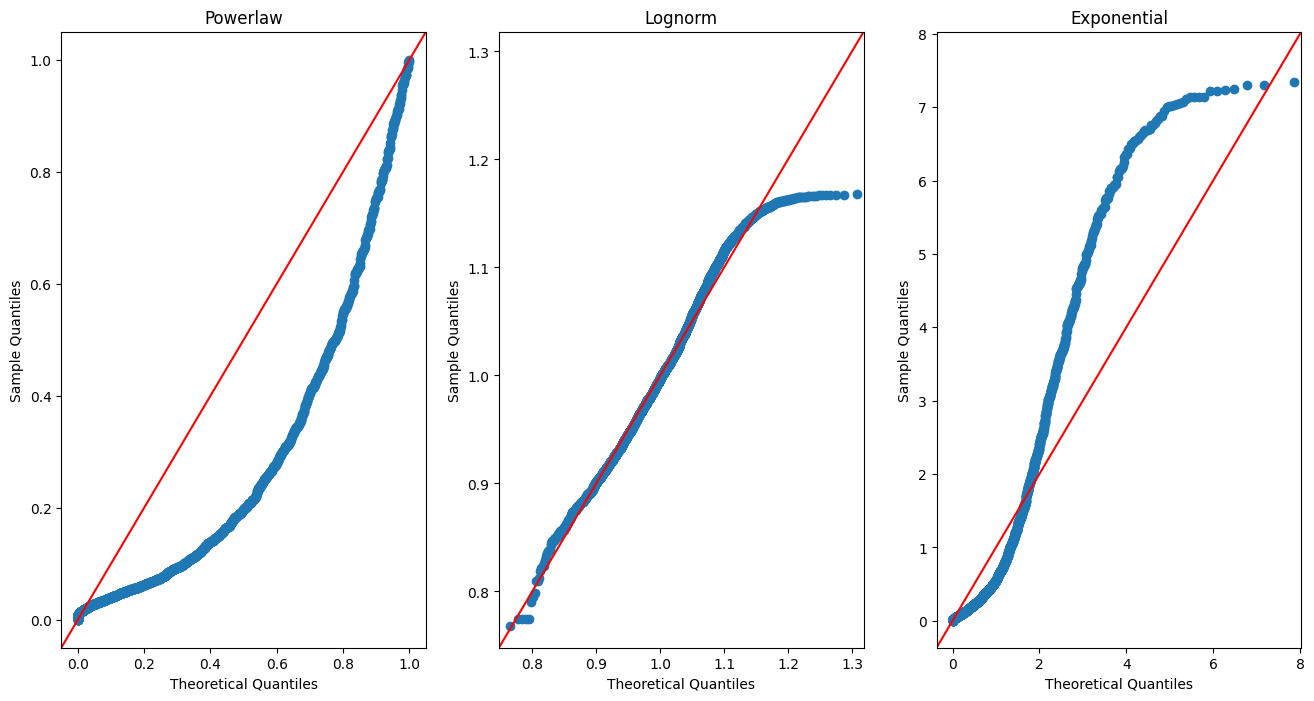

In [244]:
# Intraevent
temp = intraevent_data
temp = temp[temp["interevent_diff"] != 0.0]["interevent_diff"]

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

qqplot(temp, scipy.stats.distributions.powerlaw, line="45", fit=True, ax=ax[0])
ax[0].set_title("Powerlaw")

qqplot(np.log(temp), scipy.stats.distributions.lognorm, line="45", fit=True, ax=ax[1])
ax[1].set_title("Lognorm")

qqplot(temp, scipy.stats.distributions.expon, line="45", fit=True, ax=ax[2])
ax[2].set_title("Exponential")

if save_figs:
    plt.savefig("figures/seed_inter-event-qqplots.jpg")
plt.show()

In [245]:
# Perform Kolmogorov-Smirnov test
fit = powerlaw.Fit(xmin=temp.min(), xmax=temp.max(), data=temp)

for i, j in zip([fit.power_law.cdf, fit.lognormal.cdf, fit.exponential.cdf], ["powerlaw", "lognormal", "expon"]):
    ks_statistic, p_value = kstest(temp, i)

    print(f"{j} KS Statistic: {ks_statistic}")
    print(f"{j} P-value: {p_value}")

powerlaw KS Statistic: 0.43762688314000786
powerlaw P-value: 0.0
lognormal KS Statistic: 0.05537867556435472
lognormal P-value: 2.0153693393366497e-07
expon KS Statistic: 0.2234002544533915
expon P-value: 2.6283537388746673e-115


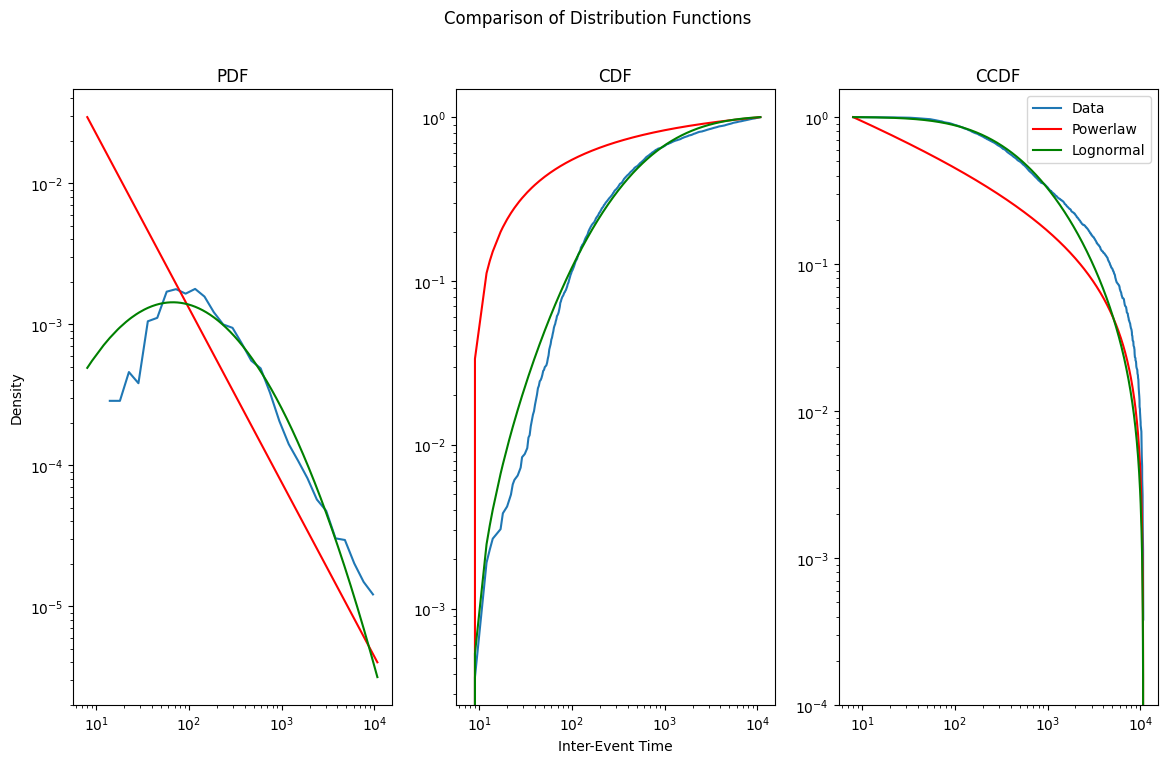

In [246]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

fit.plot_pdf(ax=axs[0])
fit.power_law.plot_pdf(color="r", ax=axs[0])
fit.lognormal.plot_pdf(color="g", ax=axs[0])
# fit.exponential.plot_pdf(color="r", ax=axs[0])

fit.plot_cdf(ax=axs[1])
fit.power_law.plot_cdf(color="r", ax=axs[1])
fit.lognormal.plot_cdf(color="g", ax=axs[1])
# fit.exponential.plot_cdf(color="r", ax=axs[1])

fit.plot_ccdf(ax=axs[2], label="Data")
fit.power_law.plot_ccdf(color="r", ax=axs[2], label="Powerlaw")
fit.lognormal.plot_ccdf(color="g", ax=axs[2], label="Lognormal")
# fit.exponential.plot_ccdf(color="r", ax=axs[2], label="Exponential")

axs[0].set_ylabel("Density")
axs[0].set_title("PDF")

axs[1].set_xlabel("Inter-Event Time")
axs[1].set_title("CDF")

axs[2].set_title("CCDF")

plt.legend()
plt.suptitle("Comparison of Distribution Functions")
if save_figs:
    plt.savefig("figures/seed_inter-event-pdf.jpg")
plt.show()

In [361]:
fit.lognormal.ccdf(60*10)

array([0.46682533])

In [36]:
mu = fit.lognormal.mu
sigma = fit.lognormal.sigma
alpha = fit.power_law.alpha

print(f"Lognorm mu: {mu}")
print(f"Lognorm sigma: {sigma}")
print(f"Powerlaw alpha: {alpha}")

Lognorm mu: 6.312551096119925
Lognorm sigma: 1.451879815770913
Powerlaw alpha: 1.2357730271233747


In [37]:
# Compare power law with exponential distribution
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"power-law vs. exponential: R = {R}, p = {p}")

# Compare power law with log-normal distribution
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"power-law vs. log-normal: R = {R}, p = {p}")

power-law vs. exponential: R = -1243.879884309322, p = 9.34905812667221e-124
power-law vs. log-normal: R = -1736.8911810257712, p = 0.0


In [45]:
# Lognormal dist fits data best ()
x = 3600
cdf_value = round(scipy.stats.lognorm.sf(x, s=fit.lognormal.sigma, scale=np.exp(fit.lognormal.mu)), 3)
print(f"P(i) at {round(x/60/60, 2)}h ({x}s) is {cdf_value}")

P(i) at 1.0h (3600s) is 0.098


In [325]:
temp = data[start_str]

# Visualize SIM activation probability function
temp["created_at"] = pd.to_datetime(
    temp["created_at"]
)
temp["interevent_diff"] = temp.sort_values(
    ["user_id", "created_at"]
).groupby("user_id")["created_at"].diff().dt.total_seconds()

# Get most active seed user
# discussions_data.groupby("ParticipantID").size().sort_values()

temp = temp.copy()

# Intital posts not preceeded by another post hold NA value for ie_diff
print("SIM: N Total Posts:", len(temp))
print("SIM: N initial Posts:", temp["interevent_diff"].isna().sum())
print("SIM: N IE Posts:", len(temp) - temp["interevent_diff"].isna().sum())
temp.dropna(subset=["interevent_diff"], inplace=True)
temp = temp[temp["interevent_diff"] != 0.0]
# remove outliers
temp = temp[temp["interevent_diff"] <= get_quartiles(
    temp["interevent_diff"]
)[1]]
temp = temp["interevent_diff"].sort_values()
ie_times_sim = temp

SIM: N Total Posts: 2577
SIM: N initial Posts: 82
SIM: N IE Posts: 2495


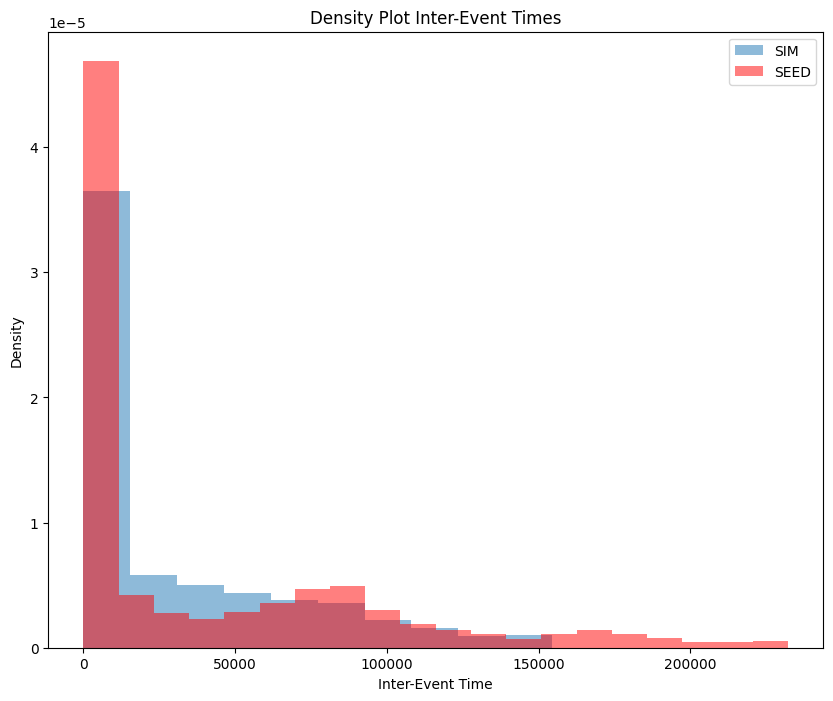

In [328]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.hist(ie_times_sim, density=True, alpha=0.5, label="SIM")
axs.hist(ie_times_seed, density=True, alpha=0.5, bins=20, label="SEED", color="r")
# axs.hist(temp, density=True, bins=5468)

axs.set_xlabel("Inter-Event Time")
# axs.set_xscale("log")
# axs.set_xlim(0, 10000)
axs.set_ylabel("Density")
# axs.set_yscale("log")


plt.title("Density Plot Inter-Event Times")
plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_ie-times-dist.jpg")
plt.show()

***
# Merge Sim and Seed Agent Data

In [249]:
sim_data = pd.DataFrame()

for i in data.values():
    sim_data = pd.concat([sim_data, i]).reset_index(drop=True)

print(f"SIM: N contributions: {len(sim_data)}")

SIM: N contributions: 13089


In [250]:
# Merge LLM Agents with their respective Seed Users
seed_sub_1_data = seed_data[seed_data["subreddit"] == "DiscussPolitics1"]

seed_sub_1_data = seed_sub_1_data[[
    "ParticipantID",
    "polinterest",
    "time_online",
    "social_media",
    "comments_online",
    "comment_count",
]]

print(len(seed_sub_1_data))

80


In [253]:
sim_data["sim_comment_count"] = sim_data["user_id"].map(
    sim_data.groupby("user_id")["content"].nunique()
)

In [254]:
merge = sim_data.merge(
    seed_data, left_on="seed_user_id", right_on="ParticipantID"
)

***
# Interaction Analysis

In [257]:
discussions_data["created_comment"] = pd.to_datetime(
    discussions_data["created_comment"]
)
discussions_data.groupby(["subreddit", "post_title"])["created_comment"].transform(
    lambda x: x.max() - x.min()
).median()

Timedelta('6 days 01:04:52')

In [258]:
# Correlation between self-reported vars and comment # for llm agents
for j in ["polinterest", "time_online", "social_media", "comments_online"]:
        corr = scipy.stats.spearmanr(merge["sim_comment_count"],
                                     merge[j])
        if corr.pvalue <= 0.05:
            print(j, corr)

polinterest SignificanceResult(statistic=np.float64(0.05472538287203399), pvalue=np.float64(0.0054556290133354925))
time_online SignificanceResult(statistic=np.float64(0.20786296390025857), pvalue=np.float64(1.5074103696636002e-26))
social_media SignificanceResult(statistic=np.float64(0.23840688150357037), pvalue=np.float64(1.2484932531542423e-34))
comments_online SignificanceResult(statistic=np.float64(0.8605436301298757), pvalue=np.float64(0.0))


In [37]:
corr = scipy.stats.spearmanr(merge["polinterest"],
                             merge["sim_comment_count"])

temp = {"stat" : [], "p" : []}
temp["stat"].append(corr.statistic)
temp["p"].append(corr.pvalue)

print("polinterest", pu.fisher(temp))

polinterest (np.float64(-0.06936003407096164), np.float64(0.0004128323362095898))


In [38]:
corr = scipy.stats.spearmanr(merge["time_online"],
                             merge["sim_comment_count"])

temp = {"stat" : [], "p" : []}
temp["stat"].append(corr.statistic)
temp["p"].append(corr.pvalue)

print("polinterest", pu.fisher(temp))

polinterest (np.float64(0.18945694340890157), np.float64(0.0))


In [39]:
corr = scipy.stats.spearmanr(merge["social_media"],
                             merge["sim_comment_count"])

temp = {"stat" : [], "p" : []}
temp["stat"].append(corr.statistic)
temp["p"].append(corr.pvalue)

print("polinterest", pu.fisher(temp))

polinterest (np.float64(0.21816012493946443), np.float64(0.0))


In [40]:
corr = scipy.stats.spearmanr(merge["comments_online"],
                             merge["sim_comment_count"])

temp = {"stat" : [], "p" : []}
temp["stat"].append(corr.statistic)
temp["p"].append(corr.pvalue)

print("polinterest", pu.fisher(temp))

polinterest (np.float64(0.9038872241744631), np.float64(0.0))


/abyss/home/oasis/oasis-rutschmanna/scripts/utils/processing_utils.py:325: RuntimeWarning: divide by zero encountered in log
  log_p = np.sum(np.log(data["p"]))


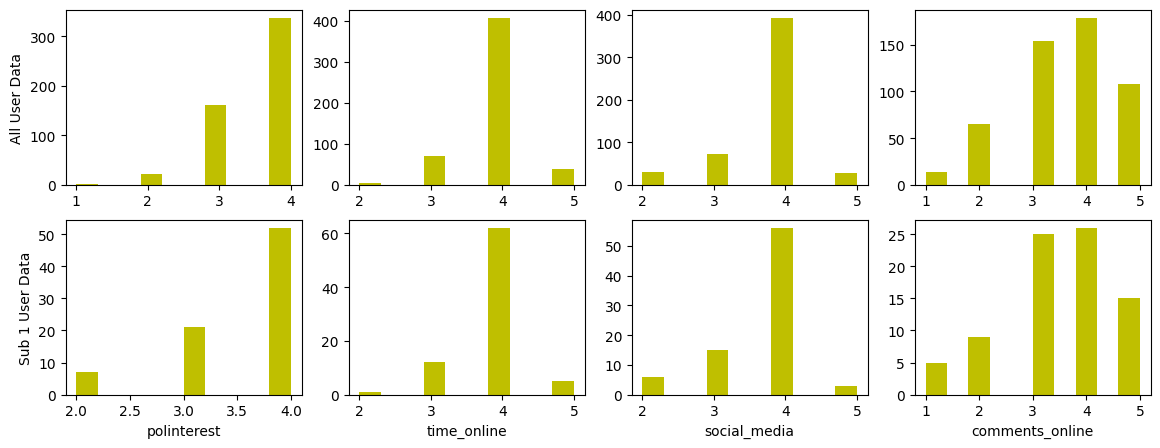

In [41]:
# Comparison of self-reported vars in whole sample vs. Sub 1
plt.rcParams['axes.prop_cycle'] = plt.cycler(color="r")
fig, axs = plt.subplots(2, 4, figsize=(14, 5))

axs[0,0].hist(seed_data["polinterest"])
axs[0,0].set_ylabel("All User Data")

axs[0,1].hist(seed_data["time_online"])

axs[0,2].hist(seed_data["social_media"])

axs[0,3].hist(seed_data["comments_online"])

axs[1,0].hist(seed_sub_1_data["polinterest"])
axs[1,0].set_xlabel("polinterest")
axs[1,0].set_ylabel("Sub 1 User Data")

axs[1,1].hist(seed_sub_1_data["time_online"])
axs[1,1].set_xlabel("time_online")

axs[1,2].hist(seed_sub_1_data["social_media"])
axs[1,2].set_xlabel("social_media")

axs[1,3].hist(seed_sub_1_data["comments_online"])
axs[1,3].set_xlabel("comments_online")

if save_figs:
    plt.savefig("figures/whole-sub1_self-reports.jpg")
plt.show()

In [42]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["polinterest"], 
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.07959907085369836), pvalue=np.float64(0.0697318497152728))

In [43]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["time_online"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(-0.06097692149655422), pvalue=np.float64(0.1650050053764535))

In [44]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["social_media"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.04920081140413537), pvalue=np.float64(0.2627438135586968))

In [45]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["comments_online"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.13399045580204383), pvalue=np.float64(0.0021992413183149007))

***
# Content Analysis

In [256]:
with open("perspective_secret.txt", "r") as f:
    api_key = f.read()

perspective_data = pu.query_perspective_df(merge, "content", api_key)

perspective_data.to_csv("/../abyss/home/oasis/data/sub-2_perspective.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2577/2577 [50:12<00:00,  1.17s/it]


In [310]:
perspective_data.head()

comment_id  post_id  parent_comment_id  user_id  subreddit_x  \
0           1        1                 -1        0            2   
1           2        1                 -1       57            2   
2           3        1                 -1       53            2   
3           4        1                 -1       72            2   
4           5        1                 -1       71            2   

                                             content  \
0  While I agree the US should push for a ceasefi...   
1  I agree with the need for a ceasefire and huma...   
2  I agree with the original statement. Labeling ...   
3  I support humanitarian aid and a ceasefire, bu...   
4  I strongly agree with the original statement. ...   

                   created_at  num_likes  num_dislikes seed_user_id  ...  \
0  2025-07-01 12:12:52.457040          2             0   2c2913be6d  ...   
1  2025-07-01 12:23:13.660500          0             0   1fc57dabcd  ...   
2  2025-07-01 12:27:42.756780          0             0   1ff83e22aa  ...   
3  2025-07-01 12:35:45.851760          0             0   a5054de0d3  ...   
4  2025-07-01 12:38:54.141060          1             0   d47304de2f  ...   

            cynicism                 polint  leftrightnocenter  in_party_feel  \
0     Somewhat agree        Very interested                3.0           79.0   
1  Somewhat disagree        Very interested                3.0           58.0   
2     Somewhat agree        Very interested                1.0           69.0   
3     Somewhat agree        Very interested                4.0           64.0   
4     Strongly agree  Moderately interested                3.0           27.0   

  out_party_feel  affective_polarization  efficacy  on_reddit  comment_count  \
0           17.0                    62.0  2.666667          1            0.0   
1            4.0                    54.0  3.000000          1            0.0   
2           17.0                    52.0  3.000000          1           28.0   
3            5.0                    59.0  2.666667          1           38.0   
4            0.0                    27.0  2.666667          1            6.0   

  content_toxicity  
0         0.101325  
1         0.093515  
2         0.043152  
3         0.176317  
4         0.112747  

[5 rows x 106 columns]

In [323]:
print(perspective_data["content_toxicity"].mean())
perspective_data.groupby("seed_post_content")["content_toxicity"].apply(np.mean)

0.03798140542836632


seed_post_content
A universal basic income would kill the economy.                                                          0.054426
Airbnb should be banned in cities.                                                                        0.030156
Artificial intelligence should replace humans where possible.                                             0.030354
Climate change is one of the greatest threats to humanity.                                                0.024420
Employers should mandate vaccination.                                                                     0.015773
Fur clothing should be banned.                                                                            0.020506
Immigration should be regulated more strictly.                                                            0.034044
Police officers should wear body cameras.                                                                 0.022844
Prostitution should be illegal.                               

In [324]:
print(discussions_data["comment_toxicity"].mean())
discussions_data[discussions_data["subreddit"] == "DiscussPolitics2"].groupby("post_title")["comment_toxicity"].apply(np.mean)

0.10989353141602316


post_title
A universal basic income would kill the economy.                                                          0.064974
Airbnb should be banned in cities.                                                                        0.072092
Artificial intelligence should replace humans where possible.                                             0.080554
Climate change is one of the greatest threats to humanity.                                                0.079247
Employers should mandate vaccination.                                                                     0.068173
Fur clothing should be banned.                                                                            0.093737
Immigration should be regulated more strictly.                                                            0.118989
Police officers should wear body cameras.                                                                 0.042571
Prostitution should be illegal.                                      

***
# Junk yard

In [ ]:
st = datetime(2025, 6, 4, 13, 00, 00)

class Clock:
    r"""Clock used for the sandbox."""

    def __init__(self, k: int = 1):
        self.real_start_time = st
        self.k = k
        self.time_step = 0

    def time_transfer(self, now_time: datetime,
                      start_time: datetime) -> datetime:
        time_diff = now_time - self.real_start_time
        adjusted_diff = self.k * time_diff
        adjusted_time = start_time + adjusted_diff
        return adjusted_time

    def get_time_step(self) -> str:
        return str(self.time_step)

class Env:
    def __init__(self):
        self.start_time = st
        self.sandbox_clock = Clock(60)

In [ ]:
env = Env()

In [ ]:
import sqlite3
import pandas as pd
import random
from datetime import datetime, timedelta

def activation_function(
    data,
    db_path,
    env,
    mapping_type="comments",
    print_info=True,
    initiation_ie_time=3600,
    inter_burst_time=3600*3,
    distribution_type="lognorm",
    sigma=2.759,
    mu=8.465,
    recurring_activation_prob_modifier=0.1
):
    """
    Determines the activation of LLM agents in the OASIS simulation.
    Each agent is assigned a probability of activation depending
    on the seed user's self reported online behavior.

    Parameters
    data: seed user data (contains self-reported online behavior)
        indexed by ParticipantID (seed_id)
    db_path: path to OASIS simulation data base
    """

    current_time = env.sandbox_clock.time_transfer(
                datetime.now(), env.start_time)
    
    if mapping_type == "comments":
        mapping = {
            1: 0.005,  # never
            2: 0.0075, # once per month
            3: 0.03,   # once per week
            4: 0.05,   # almost daily
            5: 0.1,    # multiple times a day
        }
    elif mapping_type == "social_media": # very high!
        mapping = {
            1: 0.01, # not at all
            2: 0.03, # a couple of times per week
            3: 0.08, # about once per day
            4: 0.12, # multiple times per day
            5: 0.15, # almost constantly
        }
    
    # Create empty list to hold IDs of activated agents
    activated_agents_step = []

    # Access content from "live" db
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # User data
    cursor.execute("SELECT user_id, user_name FROM user")

    rows = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    db_content = [dict(zip(columns, row)) for row in rows]

    # Comment data
    cursor.execute("SELECT user_id, created_at FROM comment")

    rows = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    previous_activations = [dict(zip(columns, row)) for row in rows]
    
    conn.close()

    activated_agents = {}

    for i in previous_activations:
        timestamp_str = i["created_at"]
        timestamp = datetime.fromisoformat(timestamp_str)
        if i["user_id"] not in activated_agents.keys():
            activated_agents[i["user_id"]] = [timestamp]
        else:
            activated_agents[i["user_id"]].append(timestamp)
    
    # Decide agent activation
    for i in db_content:
        i["comments_online"] = data.at[i["user_name"], "comments_online"]
        i["activation_prob"] = mapping[i["comments_online"]]
        try:
            last_initiation = activated_agents[i["user_id"]][-1]
            # print(activated_agents[i["user_id"]][::-1])
            for j in activated_agents[i["user_id"]][::-1]:
                # print("Diff:", last_initiation - j)
                if last_initiation - j <= timedelta(seconds=initiation_ie_time):
                    last_initiation = j
                else:
                    break
            i["last_initiation"] = last_initiation
        except:
            i["last_initiation"] = datetime(1970, 1, 1, 0, 0, 0)

        activation_threshold = random.random()
        if i["user_id"] not in activated_agents:
            activation_prob = i["activation_prob"] 
            i["activated"] = (
                True if activation_threshold < activation_prob else False
            )
        
        else:
            # Estimated mu: 8.465372775046776
            # Estimated sigma: 2.7585282466115832
            x = (current_time - i["last_initiation"]).total_seconds()
            recurring_activation_prob = round(
                scipy.stats.lognorm.sf(x, s=sigma, scale=np.exp(mu)),
                3
            ) * recurring_activation_prob_modifier
            activation_prob = i["activation_prob"] + recurring_activation_prob
            # print(i["activation_prob"], x, recurring_activation_prob, activation_prob)
            i["activated"] = (
                True if activation_threshold < activation_prob else False
            )
        
        if i["activated"] == True:
            activated_agents_step.append(i["user_id"])

    if print_info:
        print("#" * 20)      
        print("Activation function activated:", len(activated_agents_step), "users.")
        print("#" * 20)
    return activated_agents_step

In [ ]:
activation_function(
    sample_data.set_index("ParticipantID"), 
    "../data/test_dbs/all_subs/reddit-sim_dp1_qwen-24h_00-03.db",
    env,
    recurring_activation_prob_modifier=0.2
)

In [ ]:
# Implement interaction burst dynamics
import sqlite3

db_path = "../data/test_dbs/all_subs/reddit-sim_dp1_qwen-24h_00-03.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT user_id, created_at FROM trace")

rows = cursor.fetchall()
columns = [col[0] for col in cursor.description]
comment_content = [dict(zip(columns, row)) for row in rows]

conn.close()

comment_content